# Τεχνικές Εξόρυξης Δεδομένων - 1η εργασία - Εαρινό 2021
* Χαράλαμπος Μαραζιάρης - `1115201800105`
* Σπυρίδων Χαλκιάς - `1115201800209`

## 0. Εισαγωγή βιβλιοθηκών και φόρτωση των Datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from google.colab import drive

warnings.filterwarnings('ignore')  # Ignore warnings

# IMPORTANT: If you want to import from drive, set this to "True".
import_from_drive = False

if import_from_drive:
  drive.mount('/content/drive')
  nx_t = 'netflix_titles.csv'
  imdb_m = 'IMDb movies.csv'
  imdb_r = 'IMDb ratings.csv'
  at = r'/content/drive/MyDrive/DataMining_data/project1/'
else:
  at = 'http://users.uoa.gr/~sdi1800105/tede/hw1/'
  nx_t = 'netflix_titles.csv'
  imdb_m = 'IMDb_movies.csv'
  imdb_r = 'IMDb_ratings.csv'

# Netflix titles
nx_df = pd.read_csv(at + nx_t)

# IMDb movies
imdb_m_df = pd.read_csv(at + imdb_m)

# IMDb ratings
imdb_r_df = pd.read_csv(at + imdb_r)

### Συμπλήρωση κενών πεδίων

Παρατηρώντας το DataSet `netflix_titles`, οι στήλες **director, cast** και **country** έχουν αρκετή έλλειψη πληροφορίας, με αποτέλεσμα οι απαντήσεις των απαιτούμενων ερωτημάτων να μην εκμεταλλεύονται τον πλήρη όγκο πληροφορίας που παρέχεται. Στο παρακάτω κελί κώδικα συμπληρώνεται ένα σύνολο κενών πεδίων του   DataSet `netflix_titles` με τα αντίστοιχα γεμάτα πεδία του DataSet `IMDb_movies`, όσον αφορά στις στήλες **director, cast** και **country**. 

In [ ]:
# Data Preparation
#------------------

# Perform left join => [nx_df OUTER LEFT JOIN imdb_m_df]
nx_df = nx_df.merge(imdb_m_df, on='title', how='left', suffixes=('', '_y'))

# Drop any duplicate from the join
nx_df = nx_df.drop_duplicates(subset='show_id').reset_index(drop=True)

# Find any NaN cell from nx_df and replace it with the respective imdb_m_df value
nx_df['director'][nx_df['director'].isnull()] = nx_df['director_y']
nx_df['cast'][nx_df['cast'].isnull()] = nx_df['actors']
nx_df['country'][nx_df['country'].isnull()] = nx_df['country_y']

# Form the appropriate column list to drop from nx_df
imdb_cols = imdb_m_df.columns.to_list()
[imdb_cols.remove(c) for c in ['title', 'country', 'director', 'duration', 'description']]
[imdb_cols.append(c) for c in ['country_y', 'director_y', 'duration_y', 'description_y']]

# Remove any unecessairy column 
nx_df.drop(columns=imdb_cols, inplace=True)

## 1. Ερωτήματα

### Ερώτημα 1.
*Ποιό είδος υπερτερεί, οι ταινίες ή οι σειρές;*

There are more existing movies than TV shows!
Movies: 5377 | TV Shows: 2410


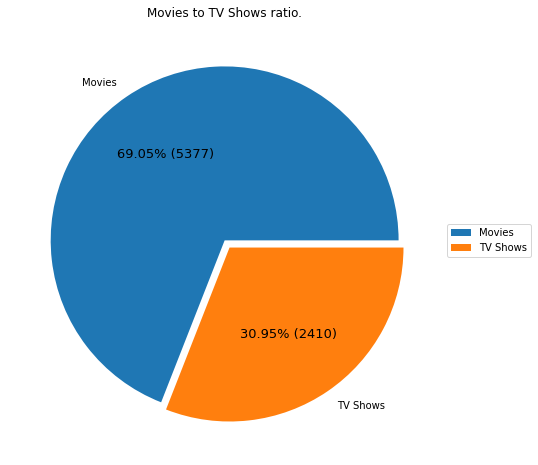

In [ ]:
''' 
In the netflix dataset, there exist either movies 
or shows, so if we find the total number of movies, we 
can automatically compute the number of TV Shows, since the 
total row number is being stored in pandas.DataFrame.
'''

# Get the total number of movies
total_movies = nx_df['type'].where(nx_df['type'] == 'Movie').count()
# Get the total number of rows
total_rows = nx_df.index.stop

# If the total number of movies is greater than the half
# dataframe's rows, movies are more
if total_movies > total_rows // 2:
    print('There are more existing movies than TV shows!') 
# If the total number of movies is less than the half
# dataframe's rows, TV shows are more
elif total_movies < total_rows // 2:
    print('There are more existing TV shows than movies!')
# Otherwise, movies are equal to TV shows
else:
    print('TV series and movies are equal!')
print(f'Movies: {total_movies} | TV Shows: {total_rows - total_movies}')

# Draw a pie plot to display the results
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = plt.pie(x=[total_movies, total_rows - total_movies], labels=['Movies', 'TV Shows'], 
        explode=(0, 0.05), autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, (p/100)*total_rows))

ax.legend(wedges, ['Movies', 'TV Shows'],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=13)

ax.set_title("Movies to TV Shows ratio.")

plt.show()

### Ερώτημα 2.
*Τα τελευταία χρόνια το netflix επενδύει περισσότερο σε ταινίες ή σε σειρές;*

Ερμηνεύουμε τον όρο "επενδύει" με βάση την προσθήκη περιεχομένου (ταινιών ή σειρών) κάθε χρόνο.

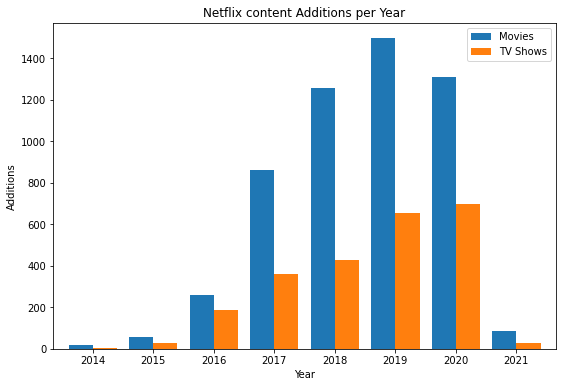

In [ ]:
def get_info2(nx_df, title):  # title is either 'Movie' or 'TV Show'

  # Get titles and date added
  info = nx_df[['type', 'date_added']].where(nx_df['type'] == title).dropna()
  
  # Replace 'date_added' field with *year* added
  info['date_added'] = info.apply(lambda row : str(row.date_added)[-4:], axis=1)
  info = info.groupby(by=['date_added']).count()
  info.rename({'type' : (title +'s')}, axis=1, inplace=True)
  return info


def content_additions(latest_years_to_show = 8):
  movie_info = get_info2(nx_df, 'Movie')
  show_info = get_info2(nx_df, 'TV Show')

  # Concatenate Movies and Shows per year, and fill NaN with 0, indicating years without Movies or Series.
  total_info = pd.concat([movie_info, show_info], axis=1).fillna(0)
  total_info[['Movies', 'TV Shows']] = total_info[['Movies', 'TV Shows']].astype(int)

  total_info.tail(latest_years_to_show).plot(kind='bar', legend=True, width=0.8, xlabel='Year', 
              ylabel='Additions', title='Netflix content Additions per Year', figsize = (9, 6))
  plt.xticks(rotation=0)
  plt.show()

content_additions()

Με βάση τη μετρική που ορίσαμε, είναι εμφανές και από το γράφημα ότι το Netflix επενδύει περισσότερο στις **ταινίες**.
Ιδιαίτερα τις χρονιές 2017, 2018 και 2019, προστέθηκαν τουλάχιστον διπλάσιες ταινίες απ' ότι σειρές στην πλατφόρμα.

### Ερώτημα 3.
*Ποιά χώρα έχει το περισσότερο περιεχόμενο;*

Country with the most content is United States, having produced 3297 movies and tv shows.


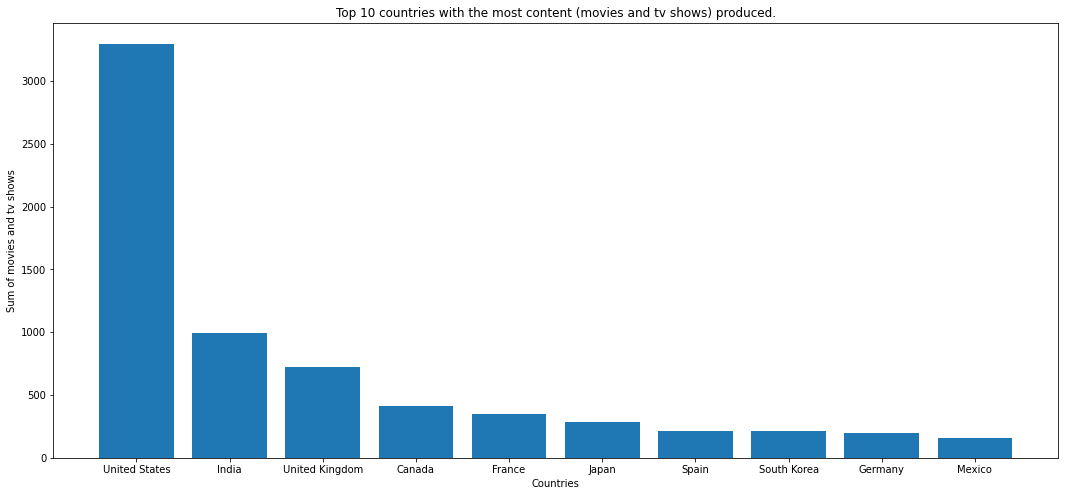

In [ ]:
'''
Store all participating countries in a dictionary
and save the number of productions of each country.
e.g: {Greece: 15, France: 26, Russia: 45}
'''
def countries_content(df, countries={}):
    # For each row
    for producers in df['country'].dropna():
        # Split the row into multiple countries (if necessary)
        for country in str(producers).strip().split(','):
            c = country.strip()
            # Store each country in the dictionary
            countries[c] = 1 if c not in countries else countries[c] + 1
    return countries

countries = countries_content(nx_df)
# The country with the most content is simply the max of the countries' dictionary
win_countr = max(countries, key=countries.get)

print(f'Country with the most content is {win_countr}, having produced {countries[win_countr]} movies and tv shows.')

# Sort the countries and draw a bar plot for demonstration purposes
countries = dict(sorted(countries.items(), key=lambda item: item[1], reverse=True))

topn = 10
fig, ax = plt.subplots(1, 1, figsize=[18, 8])
plt.bar(x=[i for j,i in enumerate(countries) if j < topn], height=[countries[i] for j,i in enumerate(countries) if j < topn])
ax.set_title(f'Top {topn} countries with the most content (movies and tv shows) produced.')
ax.set_xlabel('Countries')
ax.set_ylabel('Sum of movies and tv shows')
plt.show()

### Ερώτημα 4.
*Τι είδους περιεχόμενο έχει κάθε χώρα;*

Ερμηνεύουμε το περιεχόμενο ως "Ταινίες" ή "Σειρές". Ως περιεχόμενο μιας χώρας, θεωρούμε τις ταινίες και τις σειρές που γυρίστηκαν εξ ολοκλήρου ή εν μέρει στη χώρα αυτή (δηλαδή, η χώρα υπάρχει στο πεδίο 'country' της παραγωγής).

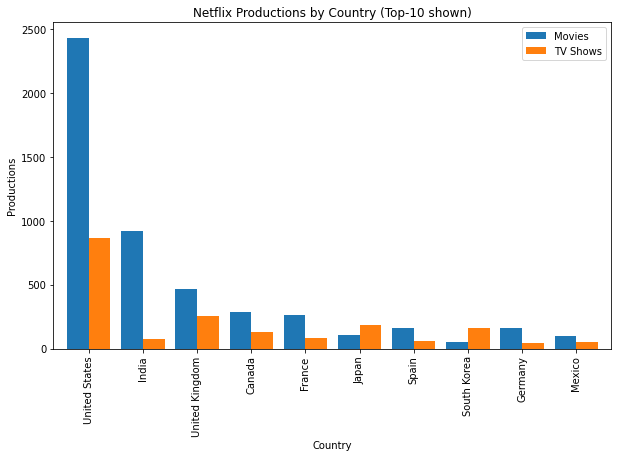

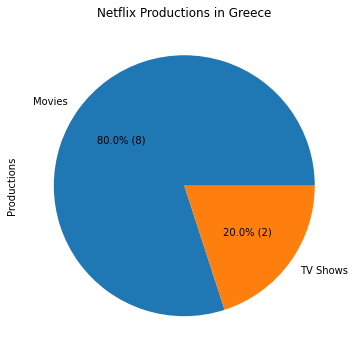

In [ ]:
def get_info4(nx_df, title):  # title is either 'Movie' or 'TV Show'
  # Get types of content and countries of production 
  info = nx_df[['type', 'country']].where(nx_df['type'] == title).dropna()
  # Create new rows, each having exactly 1 country (by splitting multi-country productions)
  info['country'] = info['country'].str.strip().str.split(',')
  info = info.explode('country')
  info['country'] = info['country'].str.strip()
  info = info.explode('country')
  info = info.groupby(by=['country']).count()
  info.rename({'type' : (title + 's')}, axis=1, inplace=True)
  return info


def content_per_country():
  movie_info = get_info4(nx_df, 'Movie')
  show_info = get_info4(nx_df, 'TV Show')

  # Concatenate Movies and Shows per country, and fill NaN with 0, 
  # indicating countries without Movies or Series produced
  total_info = pd.concat([movie_info, show_info], axis=1).fillna(0)
  total_info[['Movies', 'TV Shows']] = total_info[['Movies', 'TV Shows']].astype(int)
  # Sort countries by most productions
  total_info = total_info.assign(f = total_info['Movies'] + 
              total_info['TV Shows']).sort_values('f', ascending=False).drop('f', axis=1)

  def plot_content_by_country(info, topk = 10, country = None):
    if country is not None and country in info.index:
      total_prod = info.loc[country]['Movies'] + info.loc[country]['TV Shows']
      info.loc[country].plot(kind='pie', figsize = (6, 6), autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_prod),
                          title=f'Netflix Productions in {country}', ylabel='Productions')
    else:
      info.head(topk).plot(kind='bar', legend=True, width=0.8, xlabel='Country', figsize = (10, 6),
                          ylabel='Productions', title=f'Netflix Productions by Country (Top-{topk} shown)')
    plt.show()
    print()

  plot_content_by_country(total_info, topk=10)
  plot_content_by_country(total_info, country='Greece')

content_per_country()

Κάποια ενδιαφέροντα στοιχεία που μπορούμε να εξάγουμε από τα δεδομένα είναι:
* Η συντριπτικά μεγαλύτερη παραγωγή ταινιών απ' ότι σειρών στην **Ινδία**.
* Η παραγωγή περισσότερων σειρών απ' ότι ταινιών στην **Ιαπωνία** και στη **Νότια Κορέα**, που ενδεχομένως σχετίζεται με την κοντινή γεωγραφική τους θέση στην Ασιατική ήπειρο.

### Ερώτημα 5.
*Ετοιμάστε γραφήματα που δειχνουν τους ηθοποιούς με τις περισσότερες ταινίες σε
κάθε χώρα. Κάντε το ίδιο και για τις σειρές.*

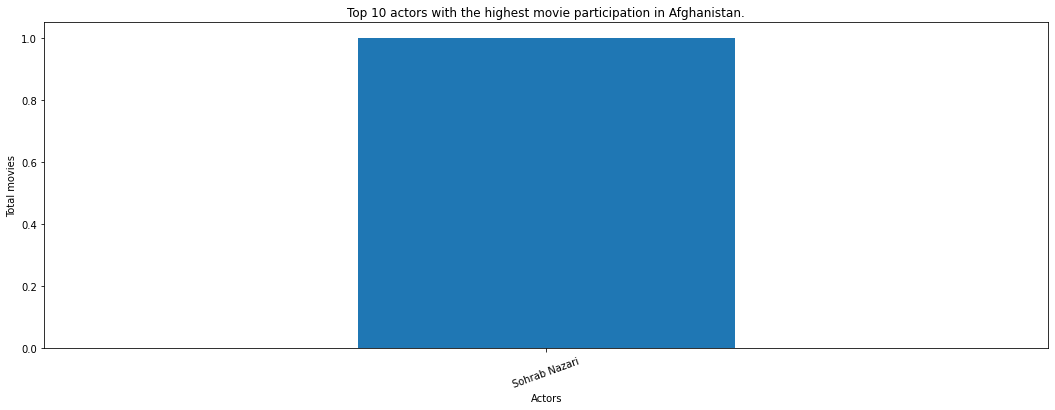

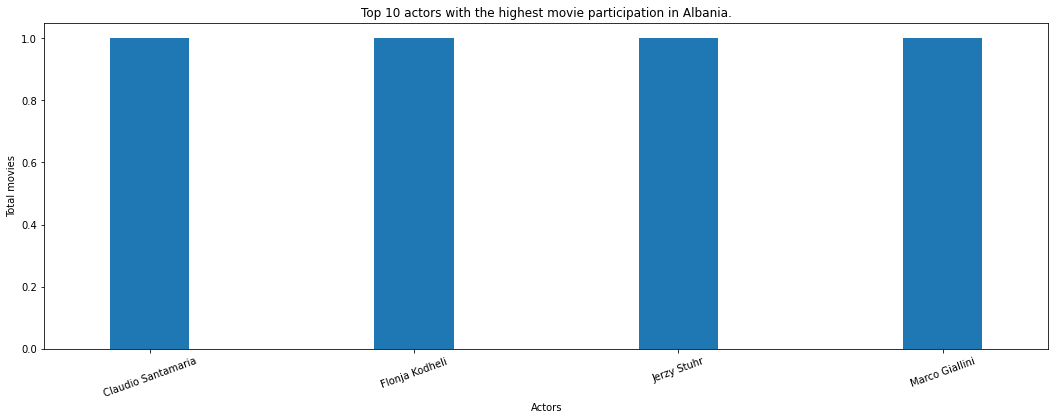

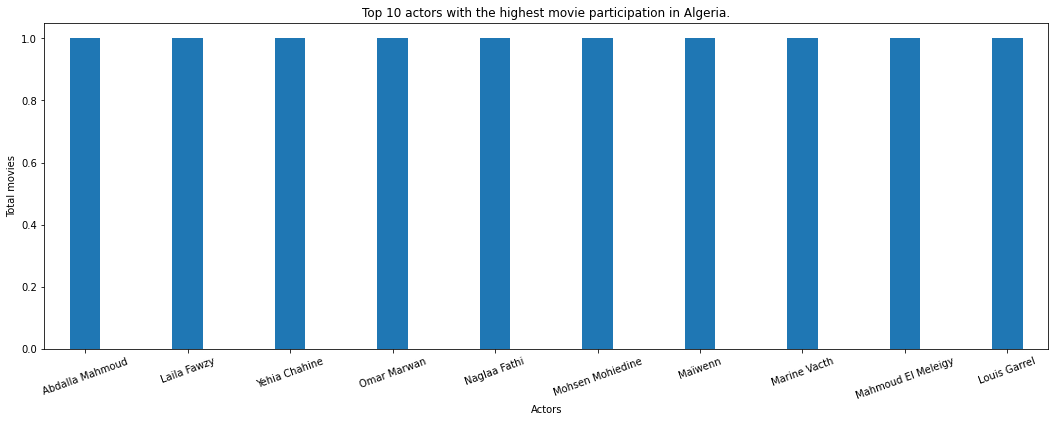

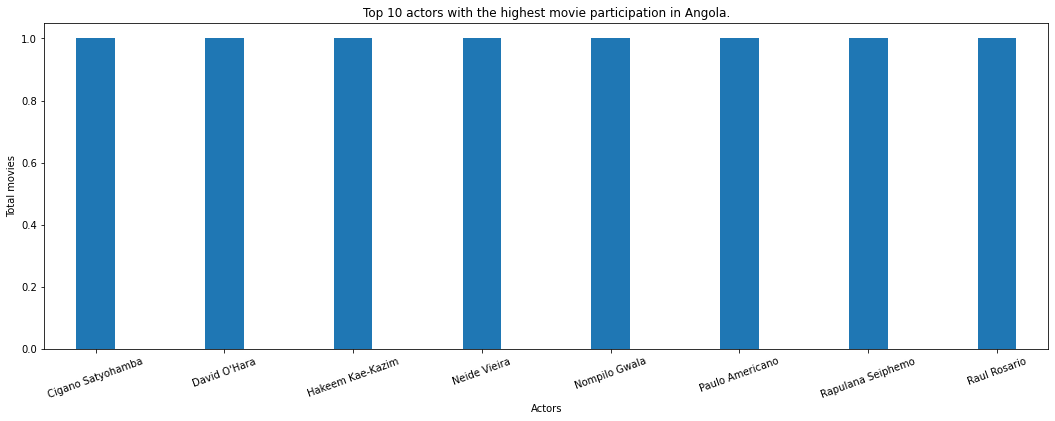

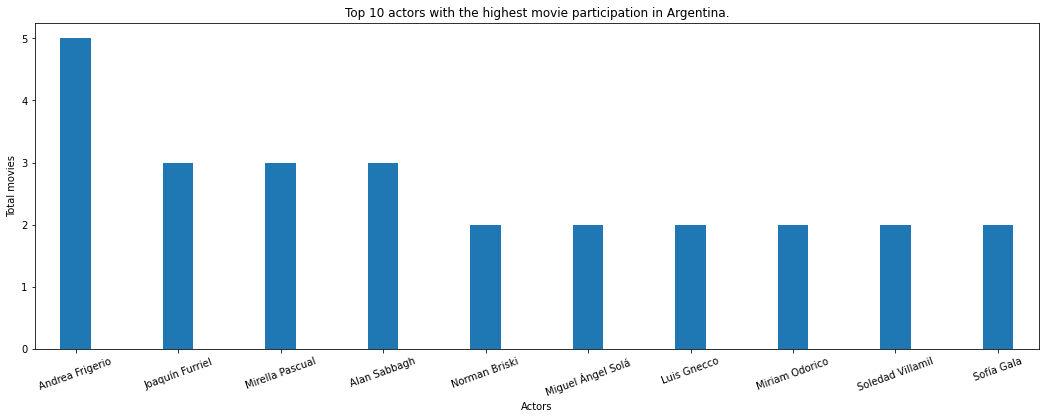

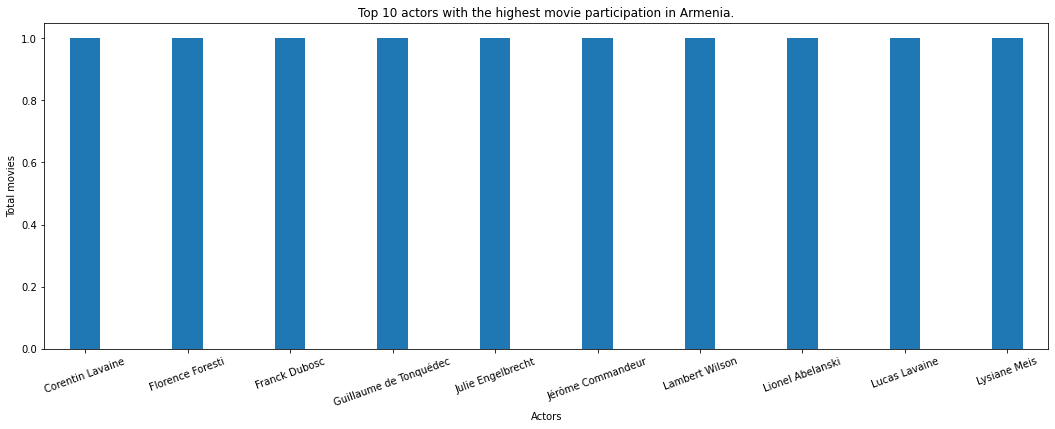

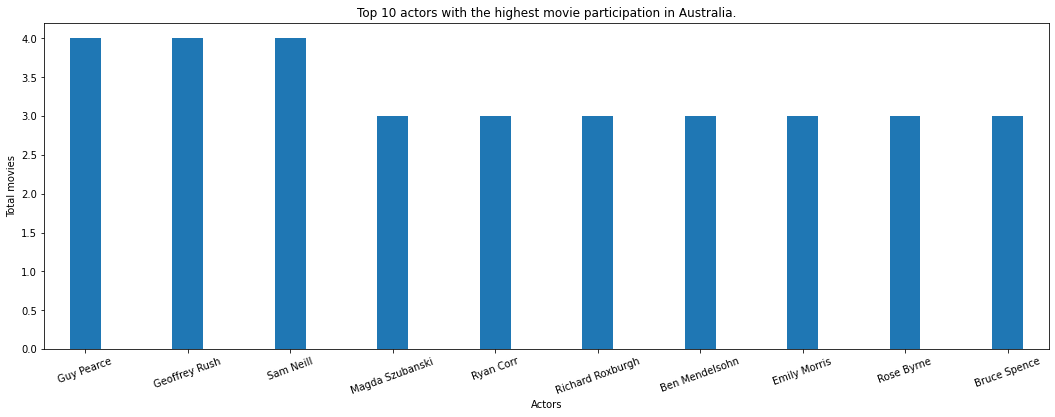

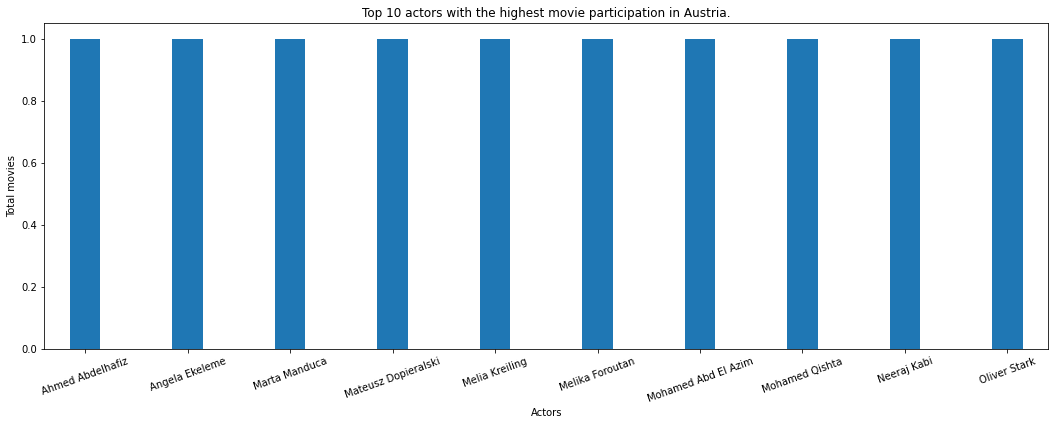

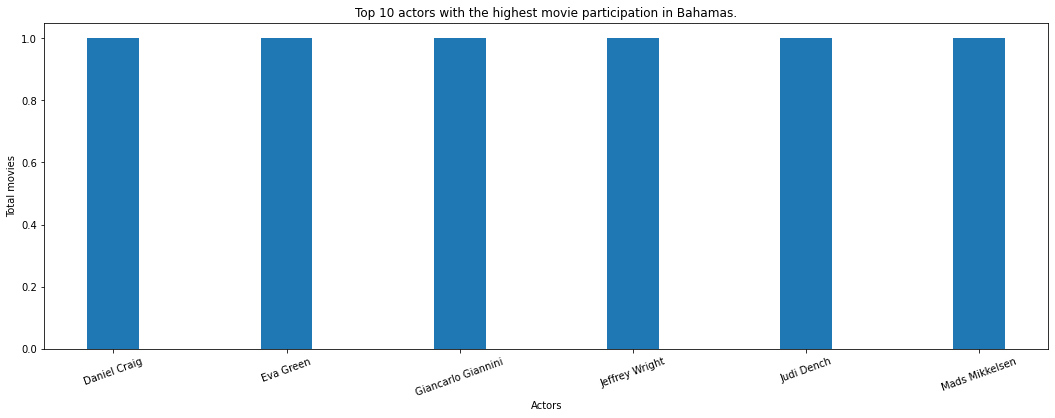

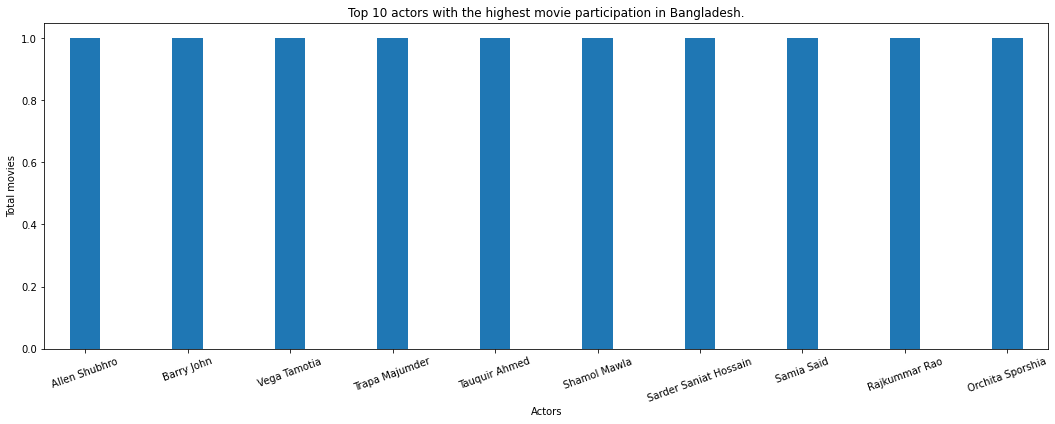

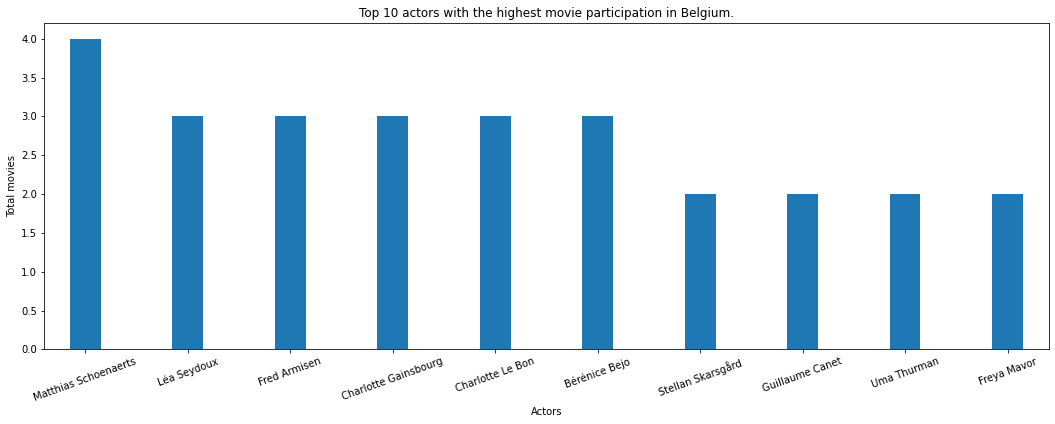

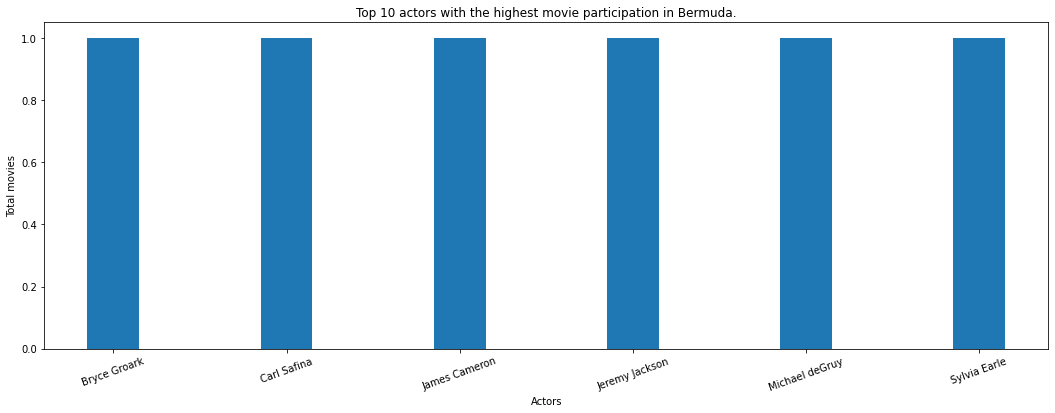

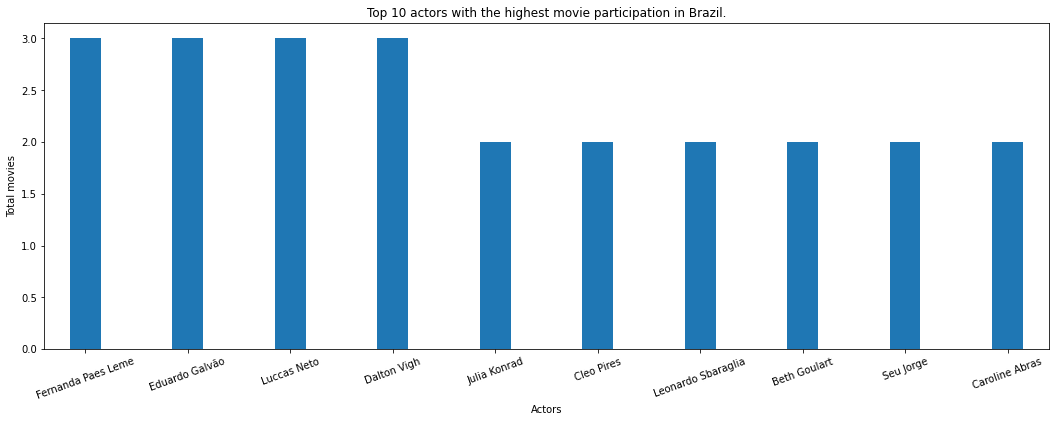

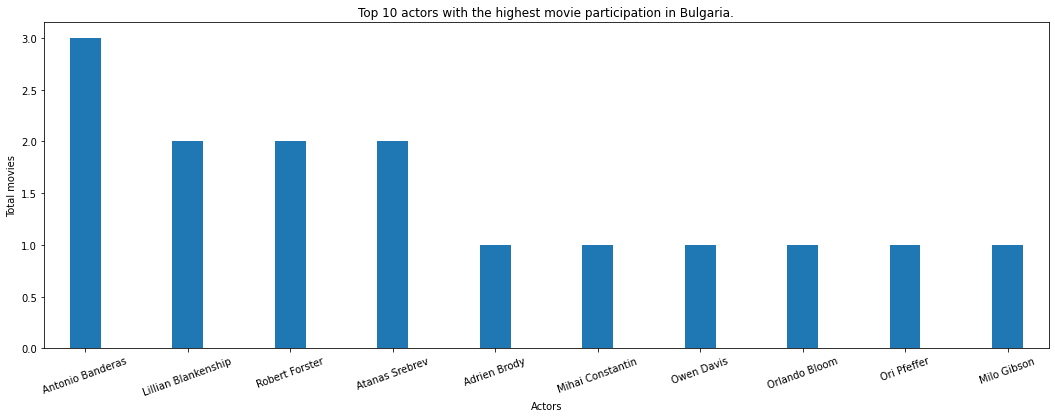

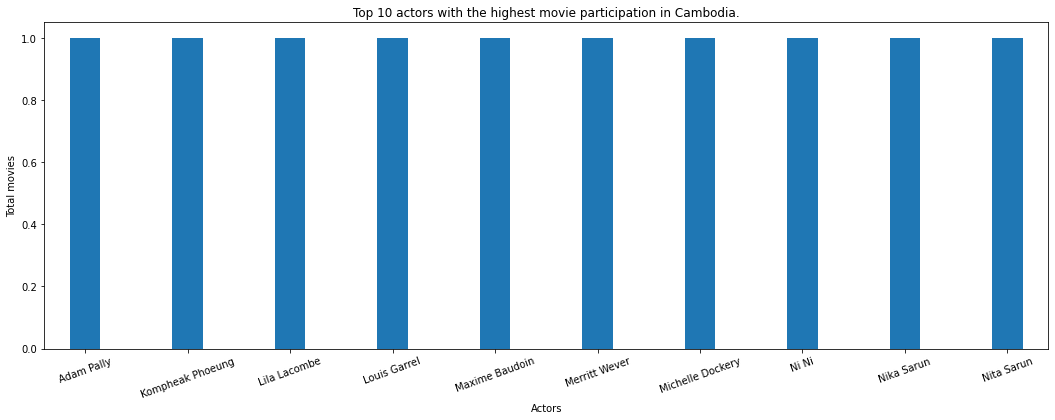

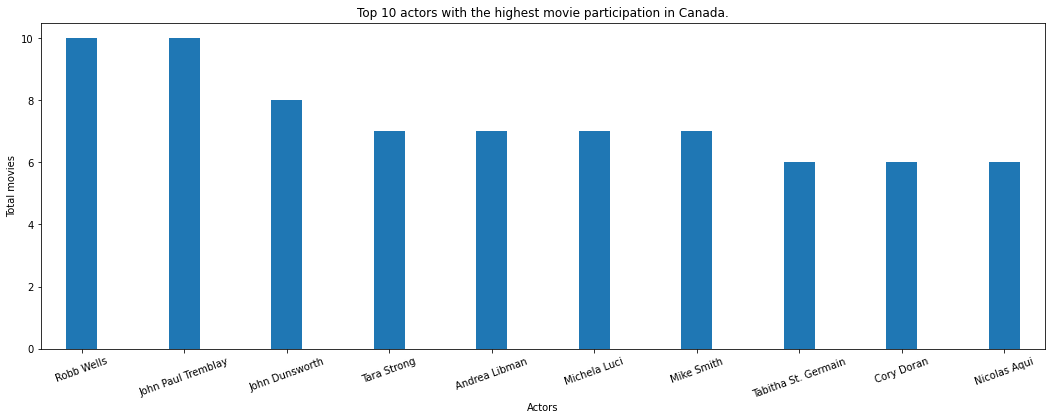

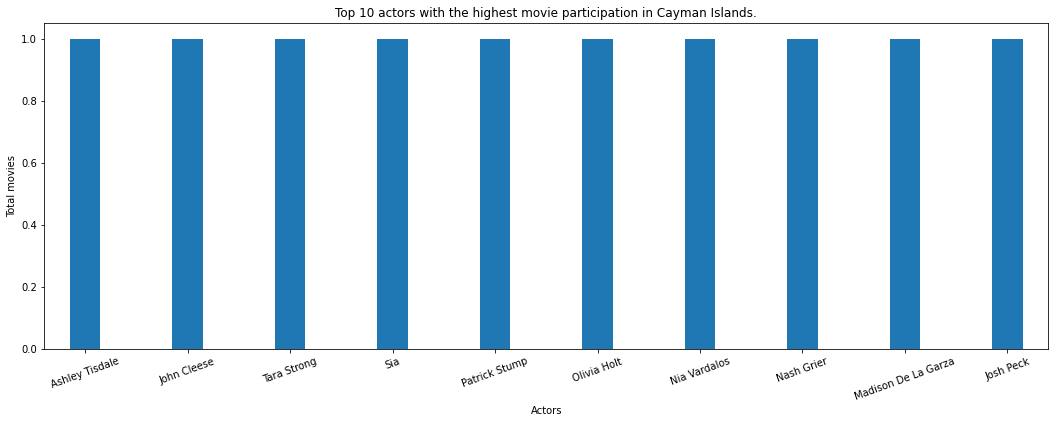

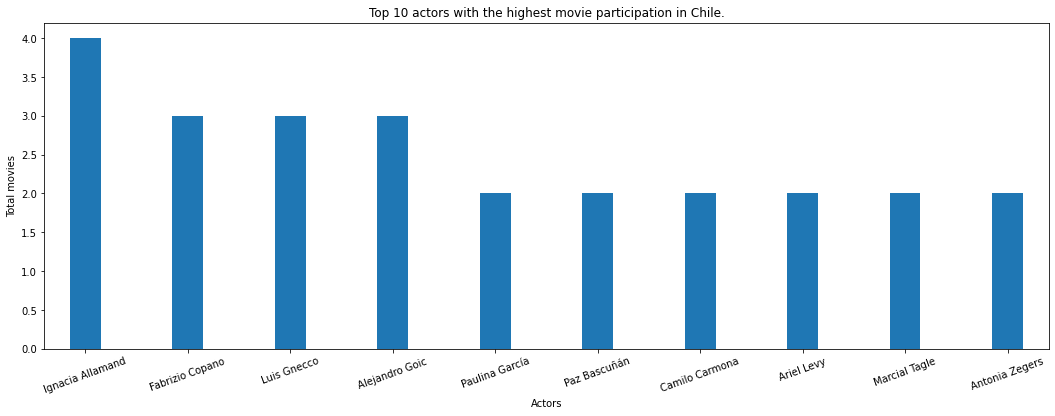

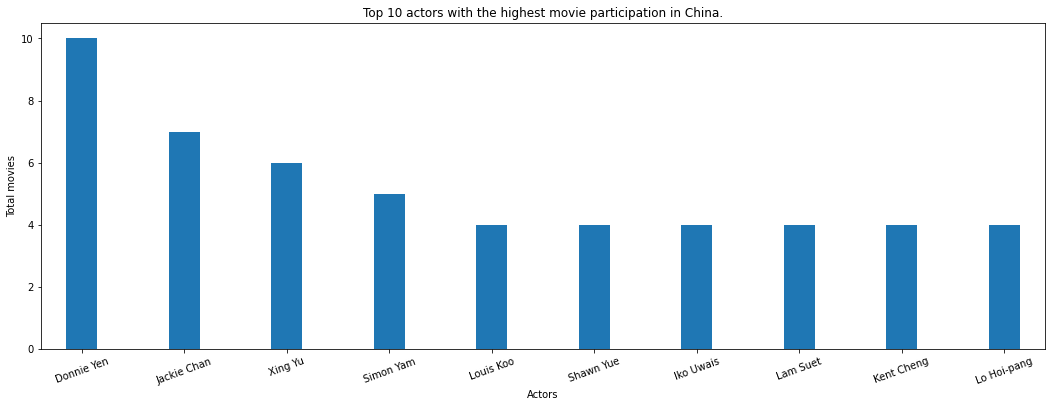

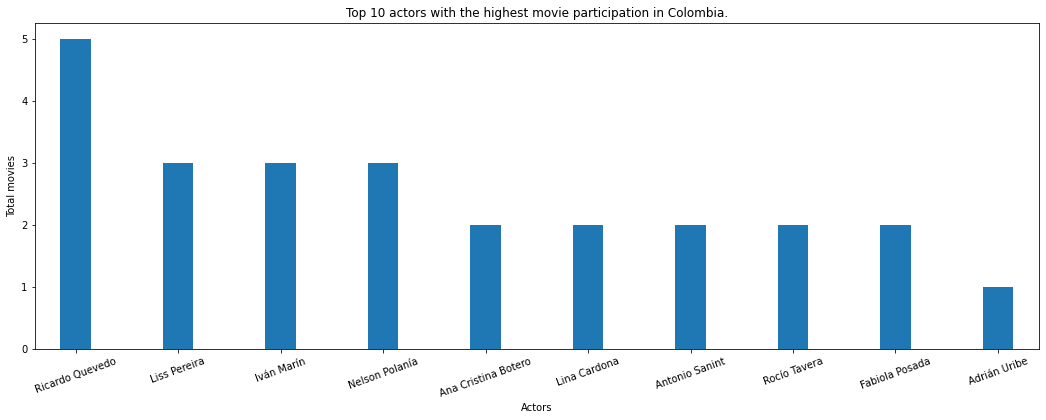

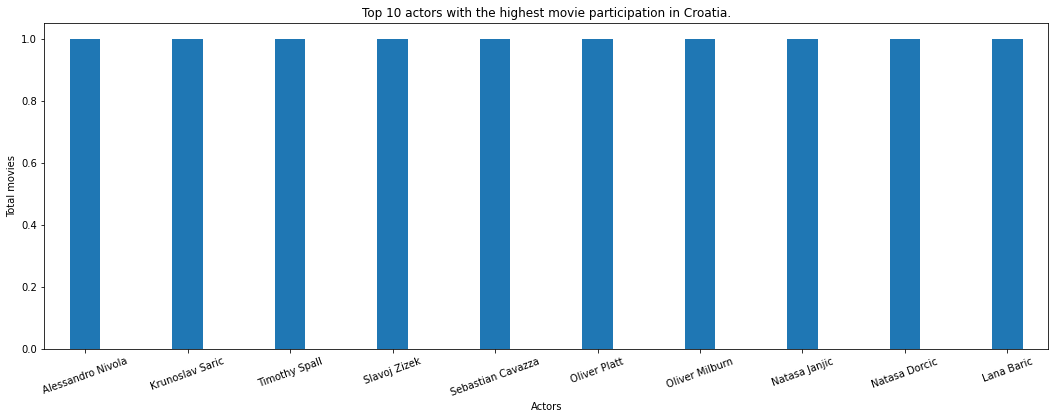

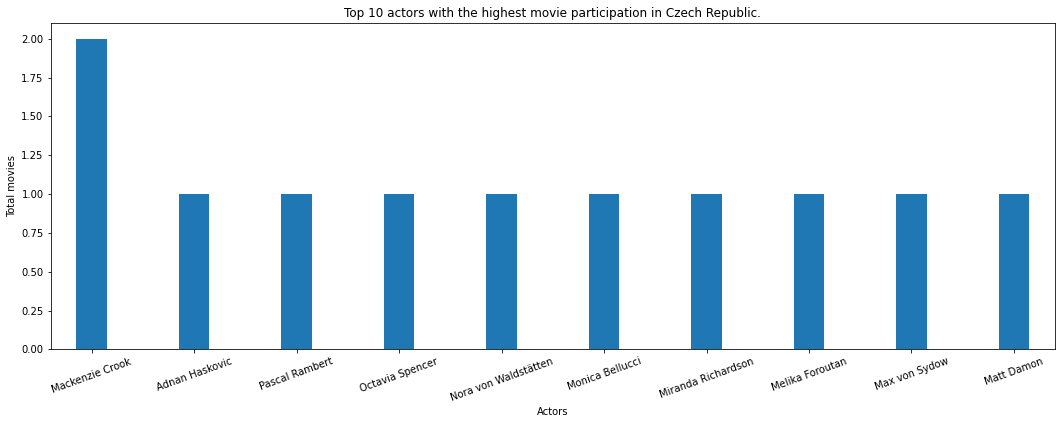

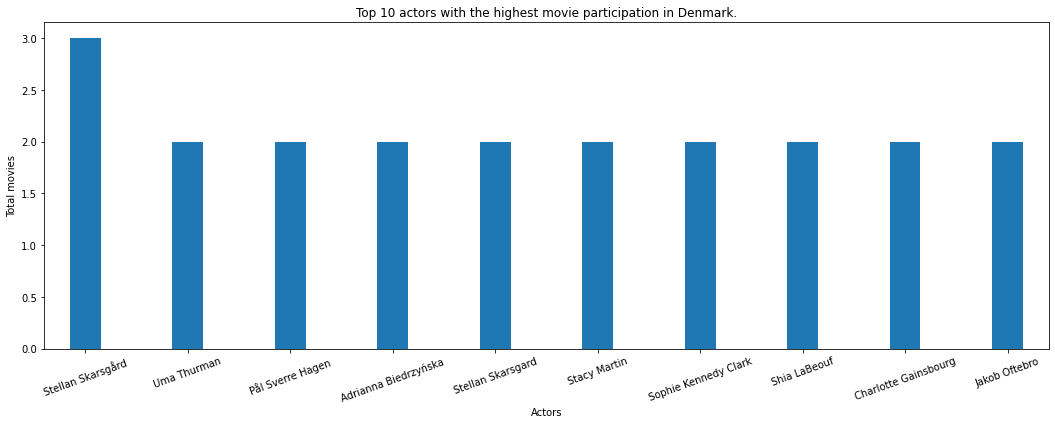

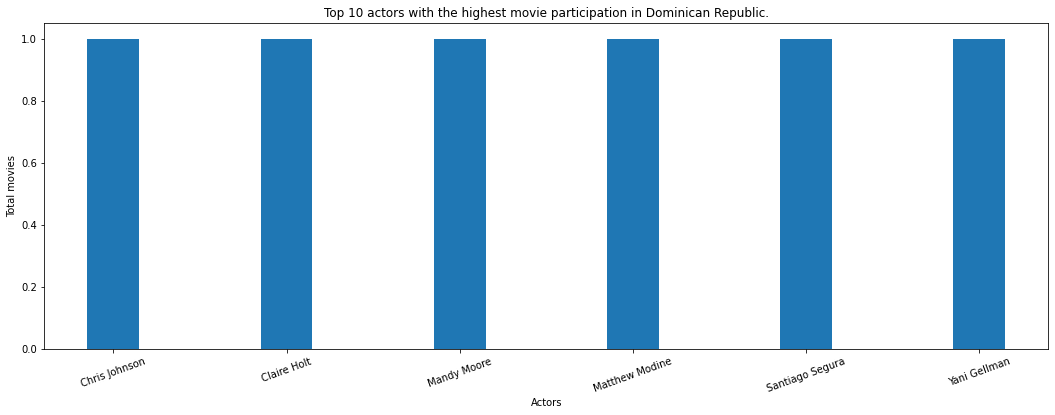

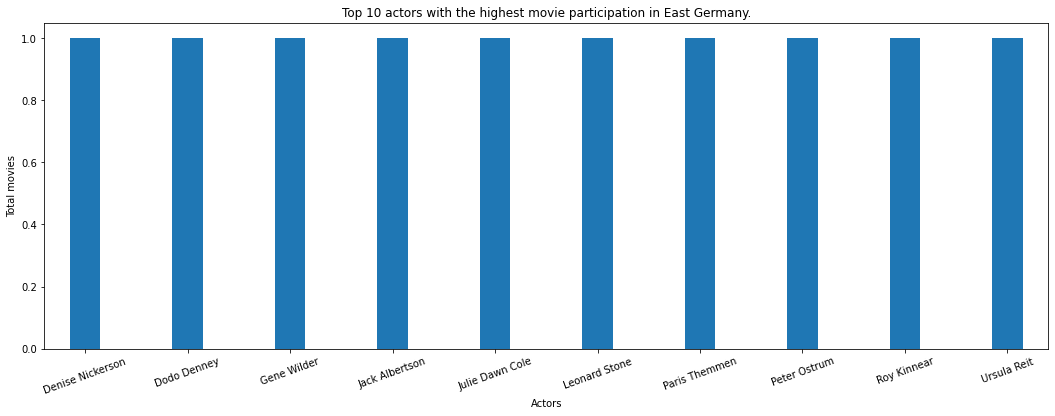

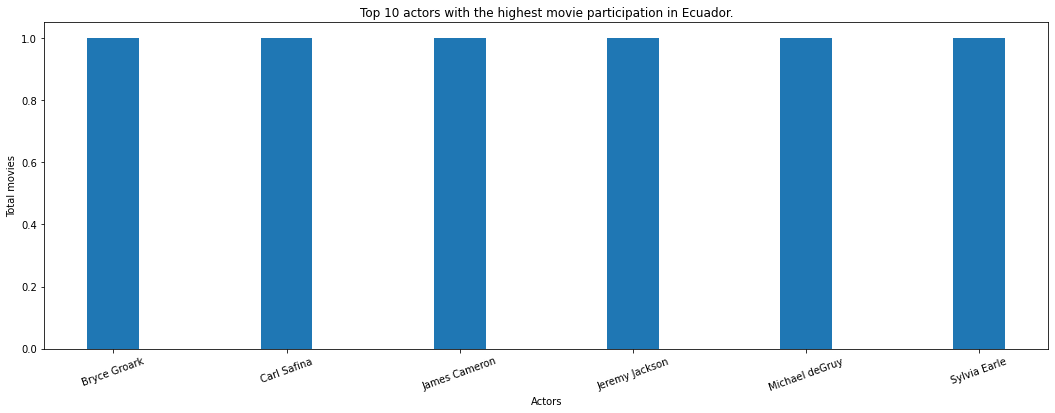

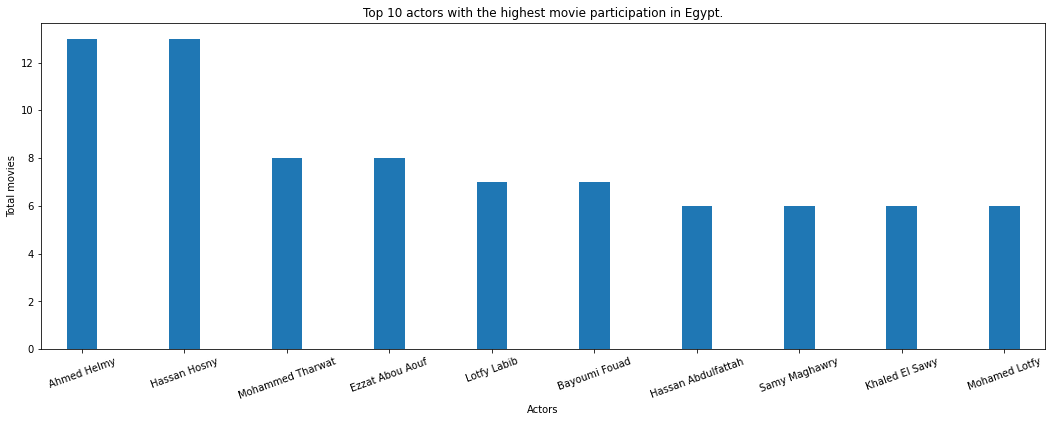

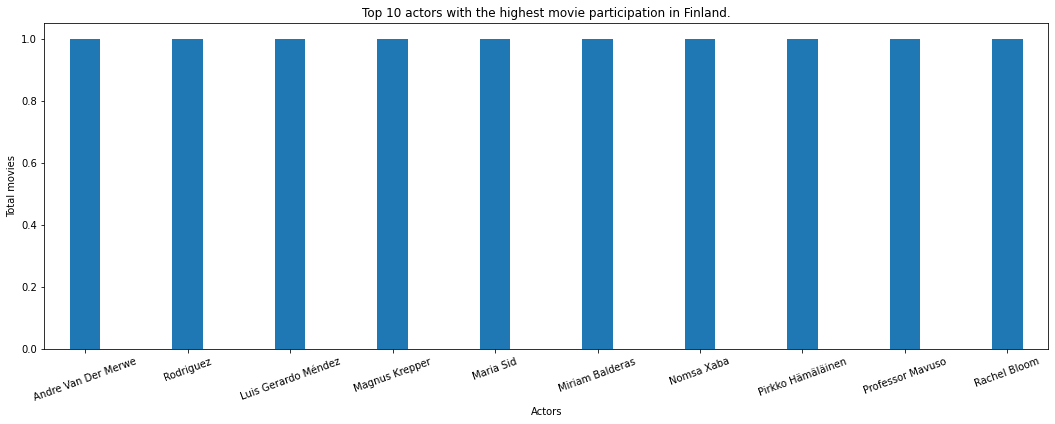

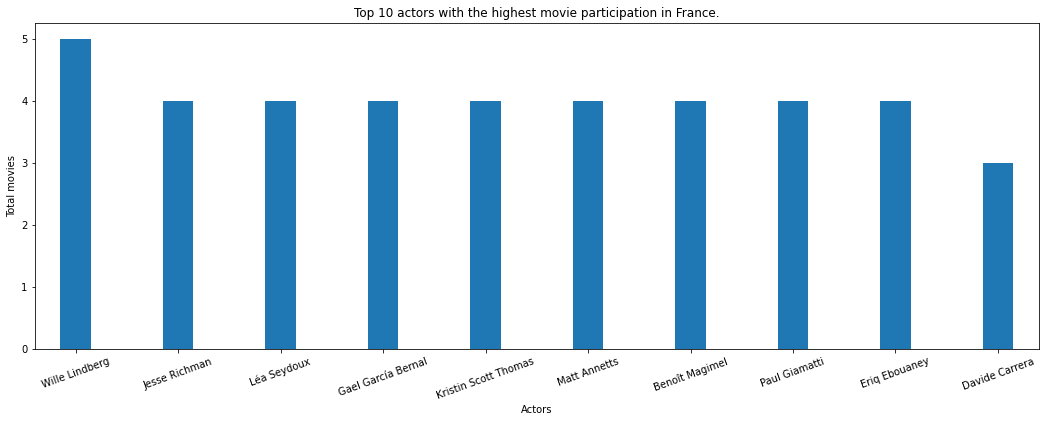

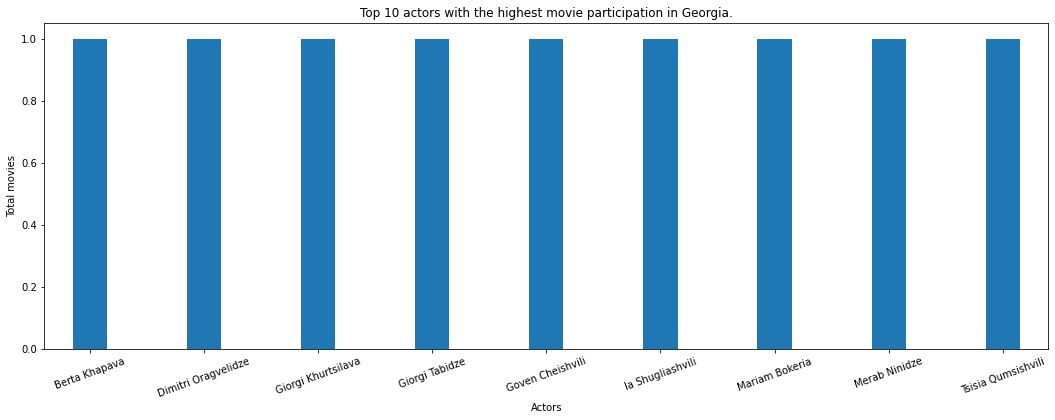

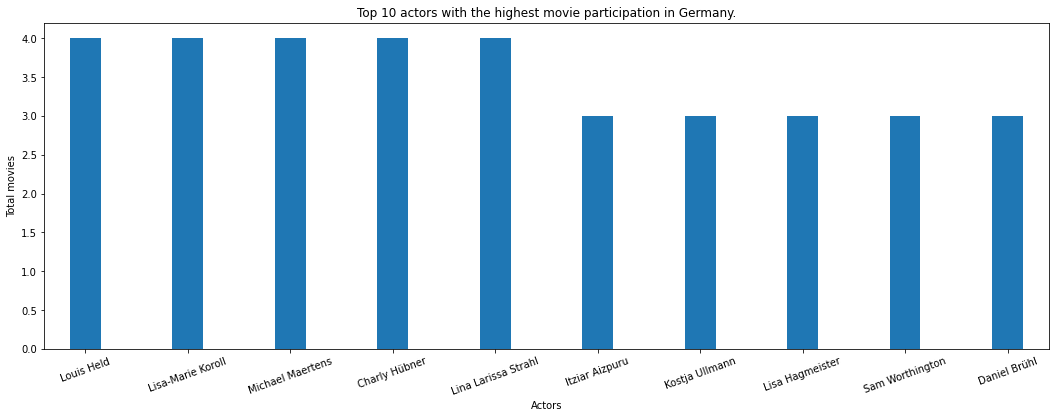

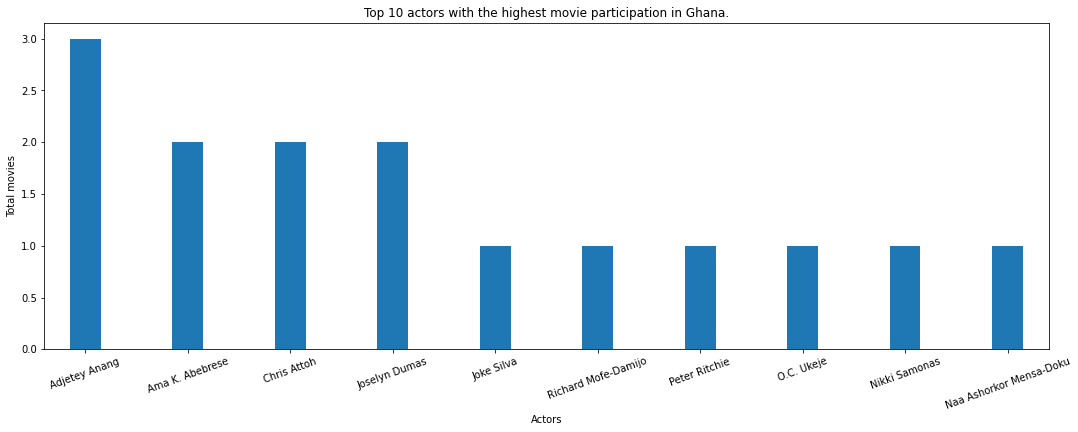

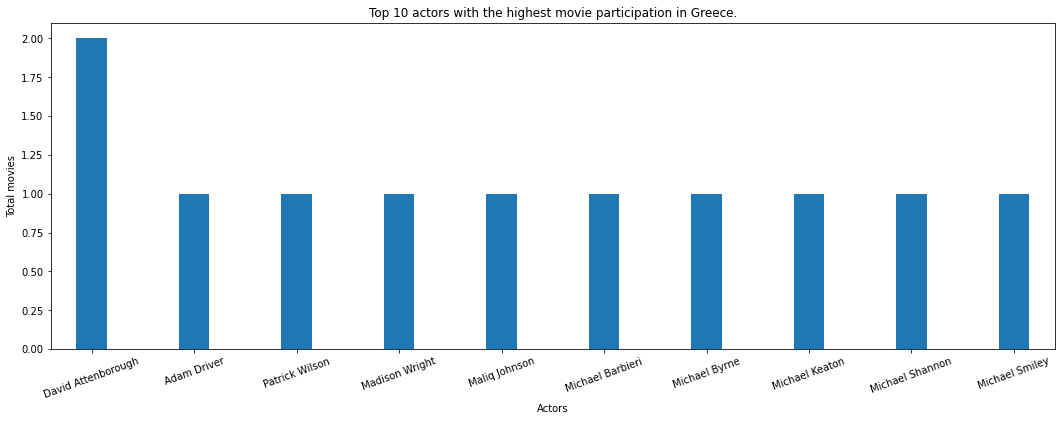

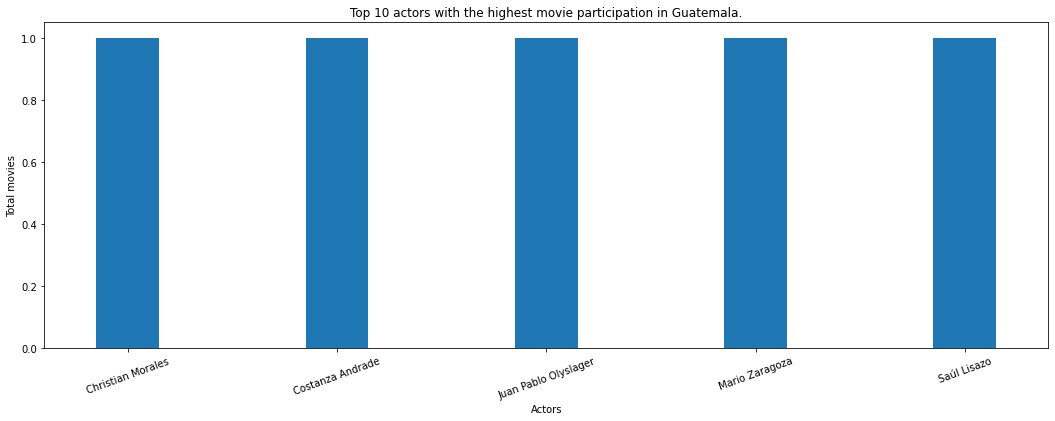

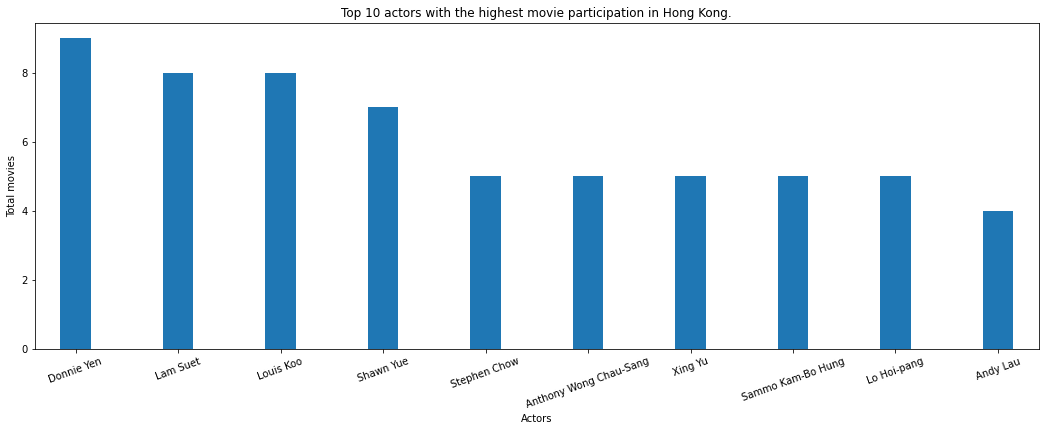

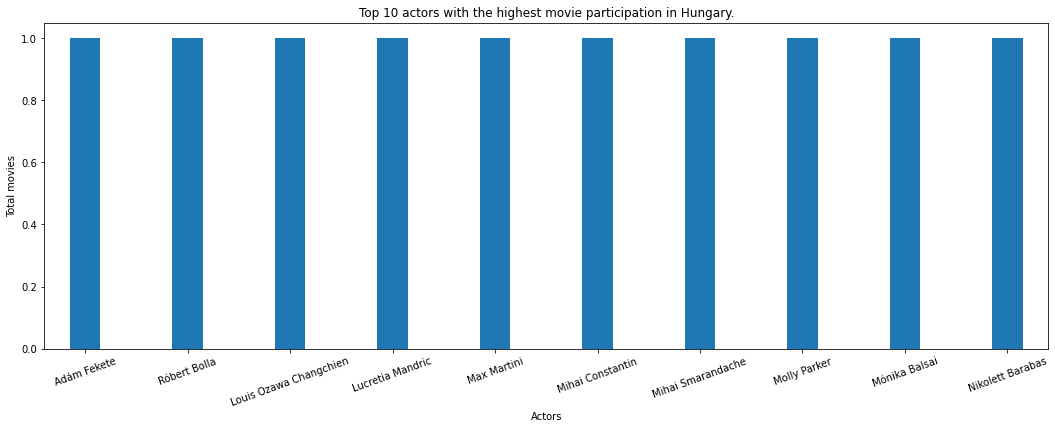

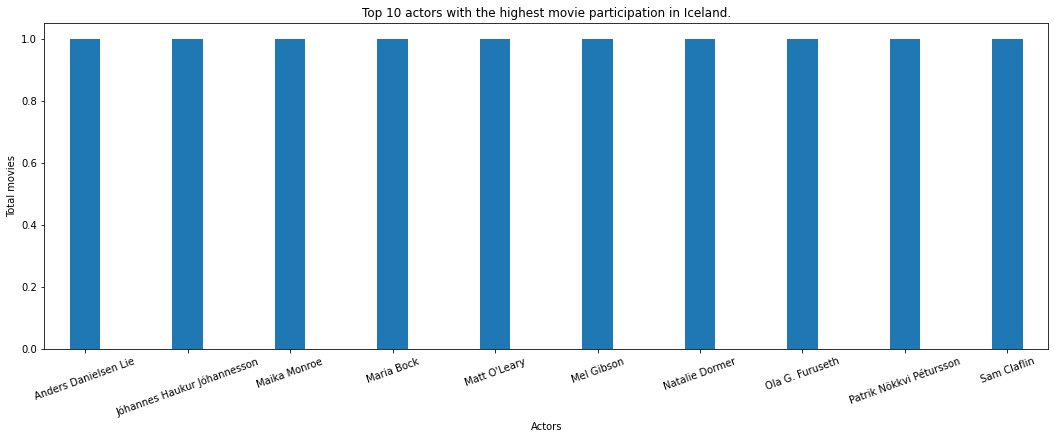

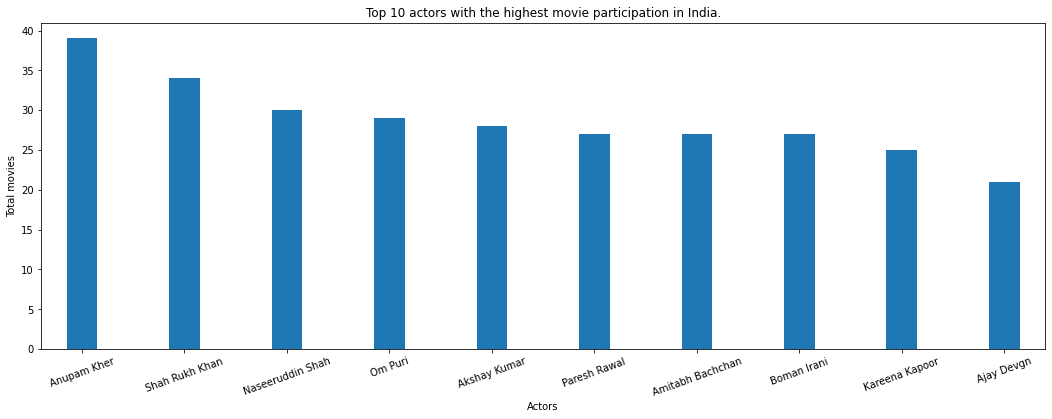

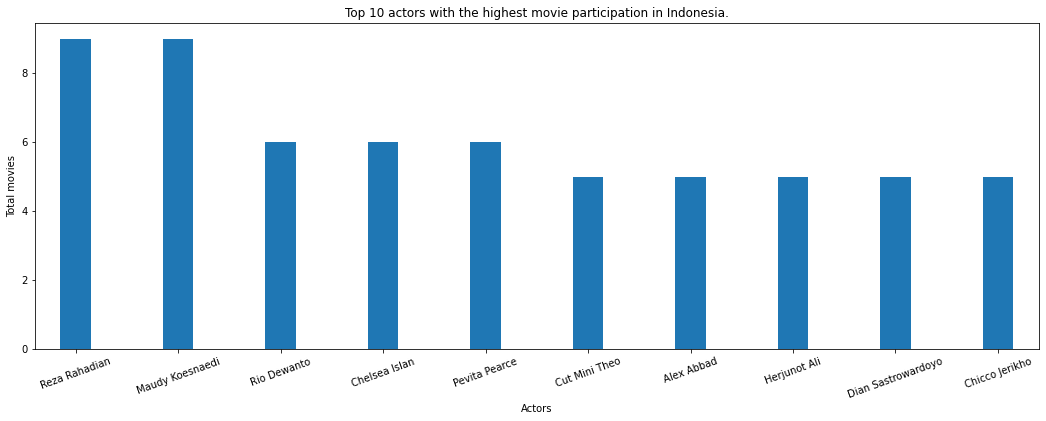

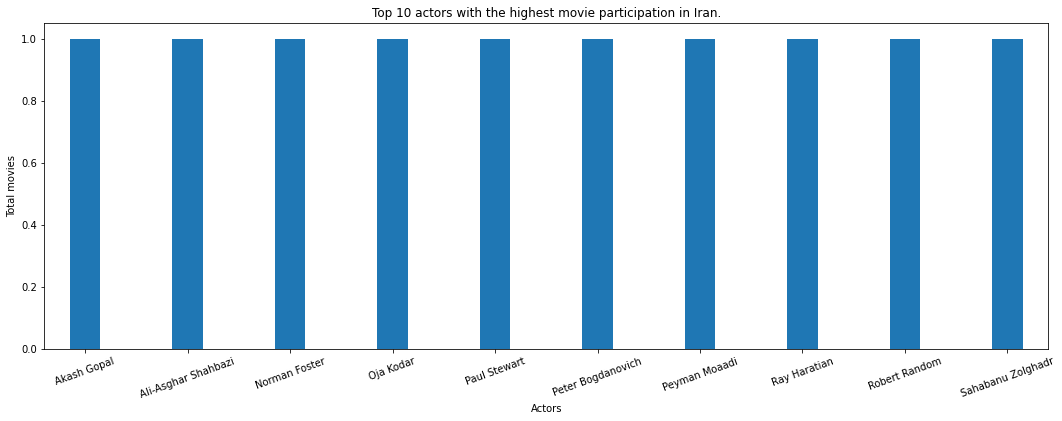

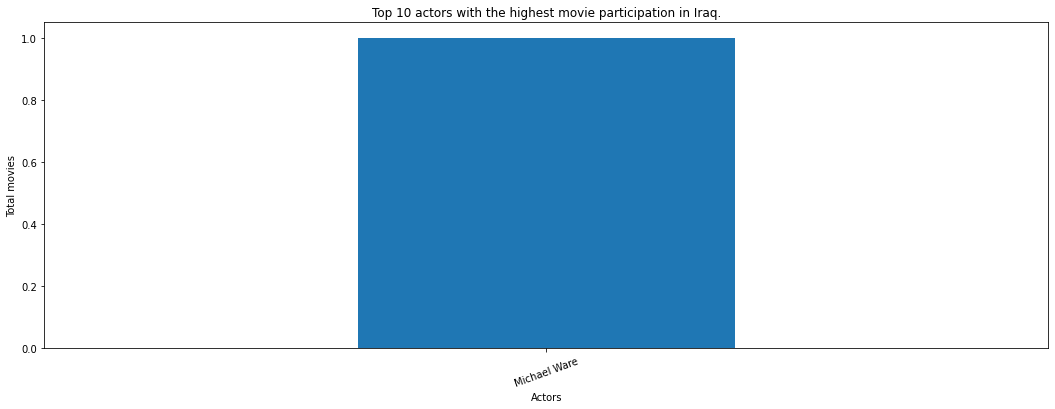

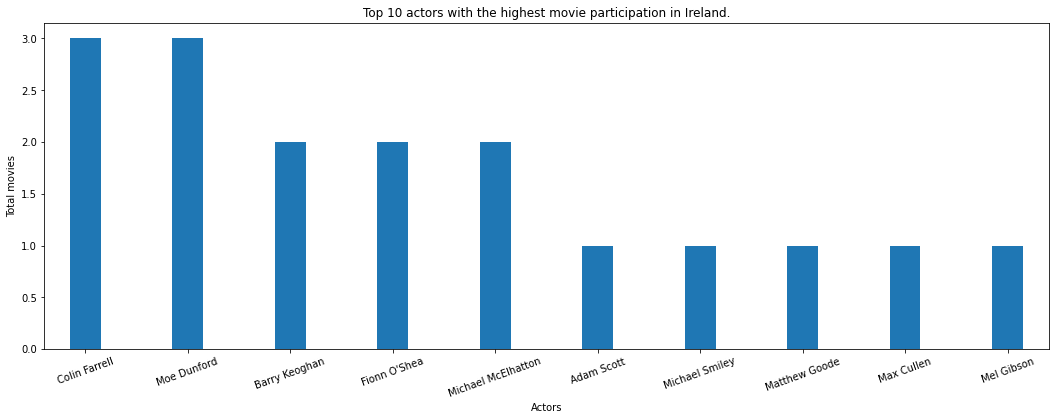

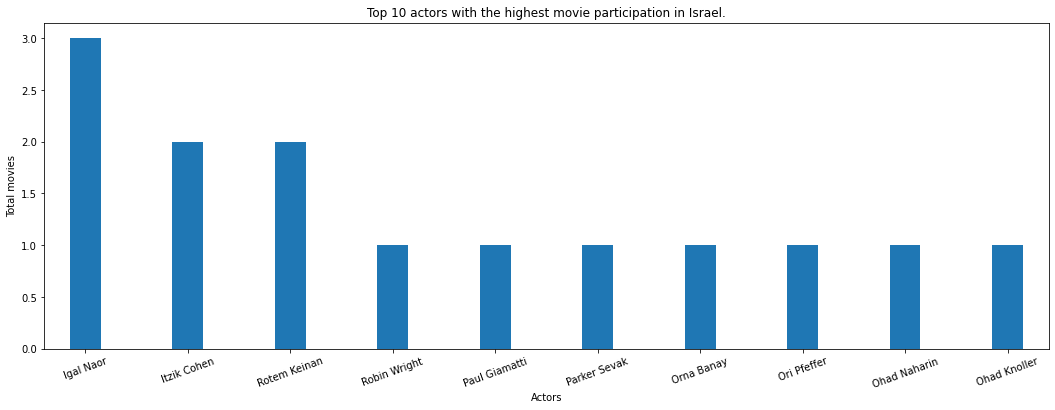

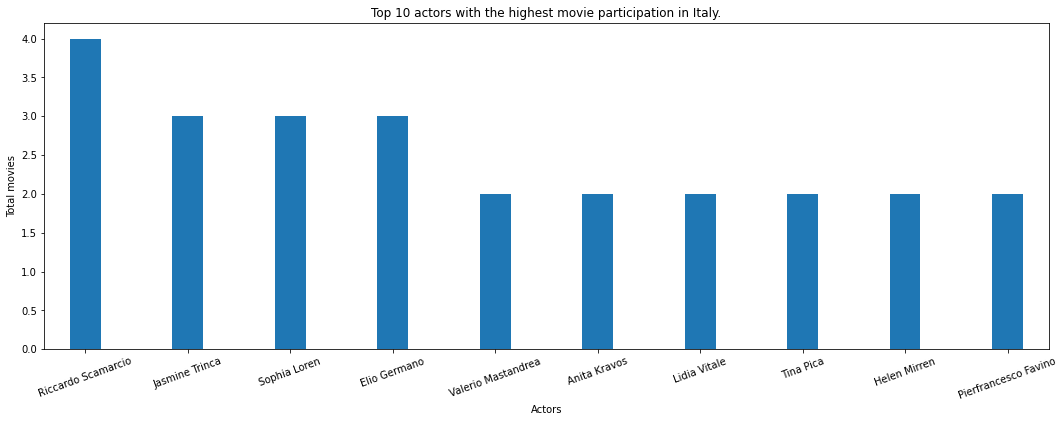

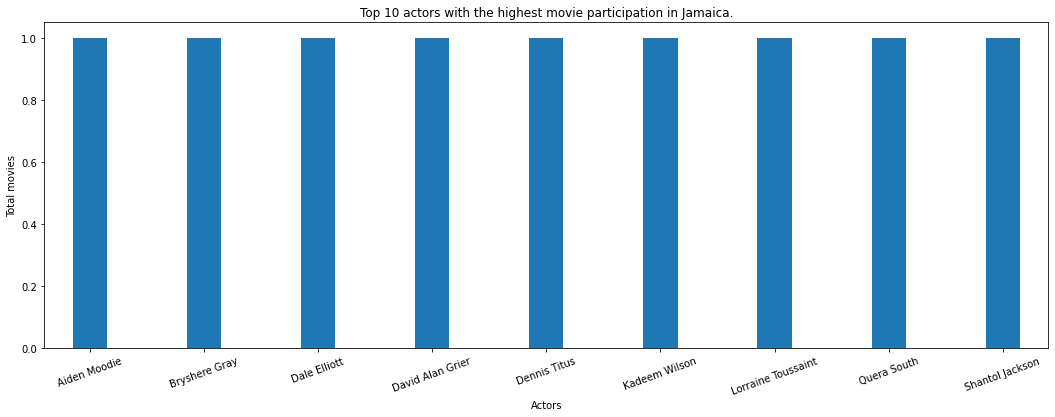

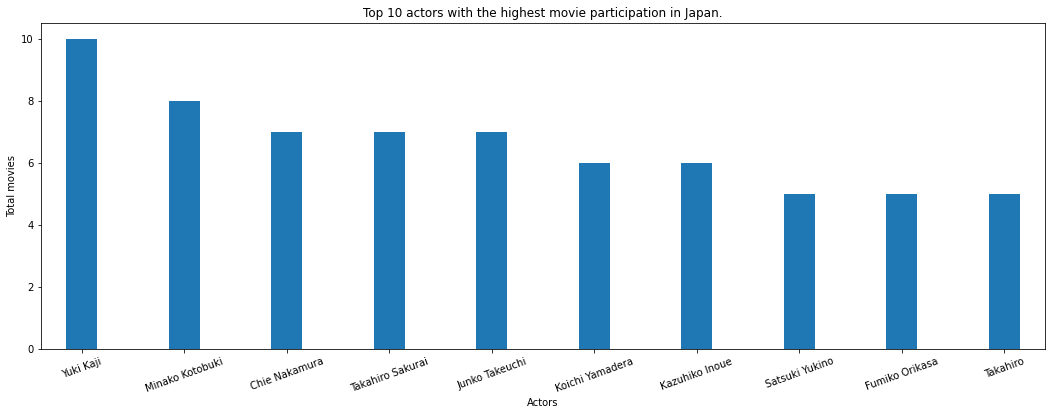

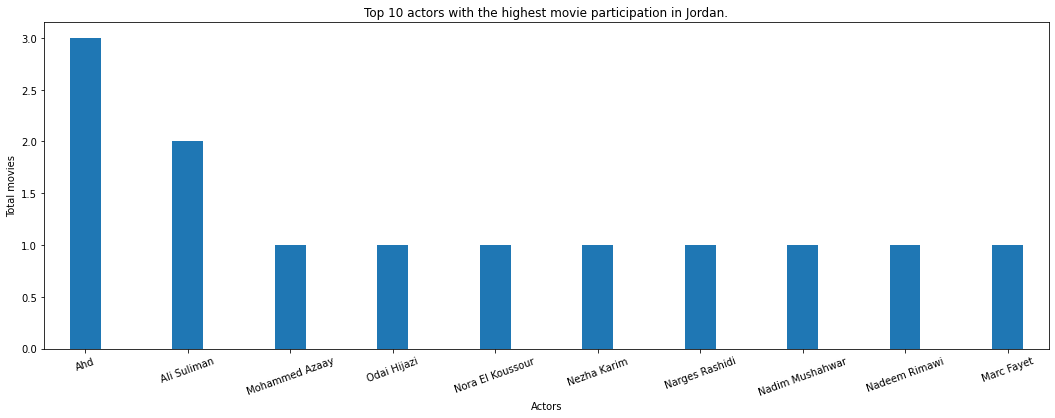

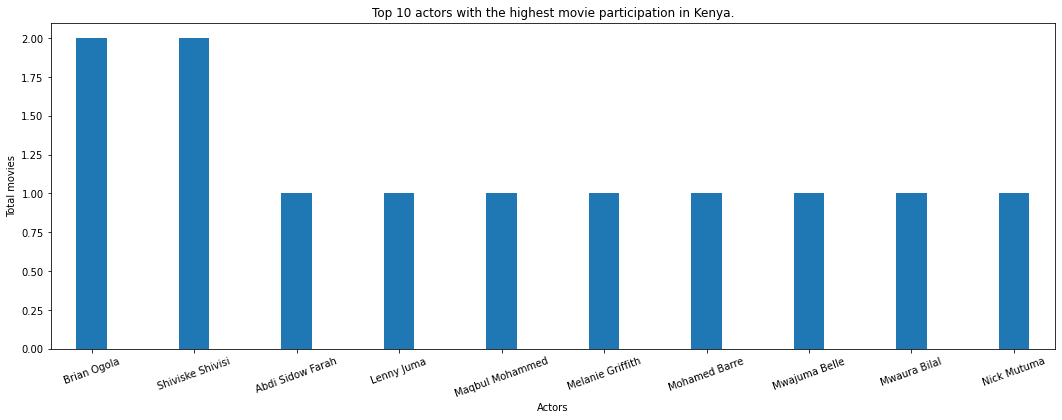

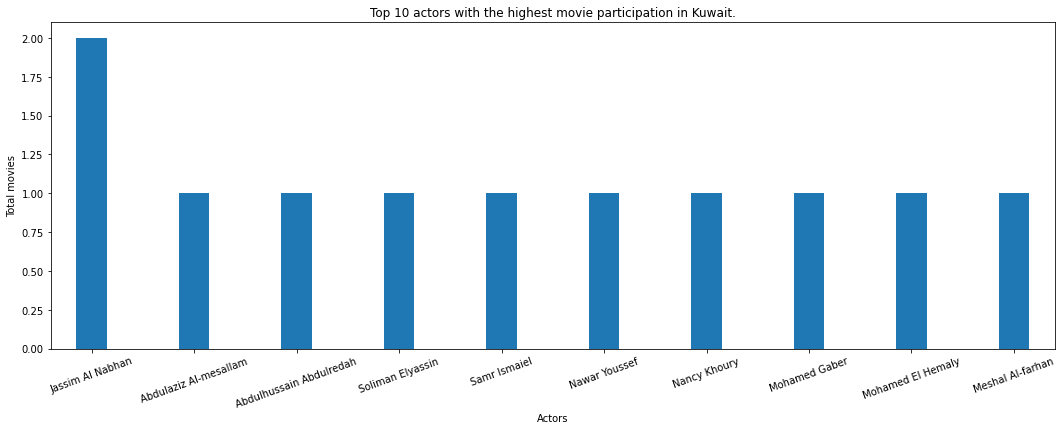

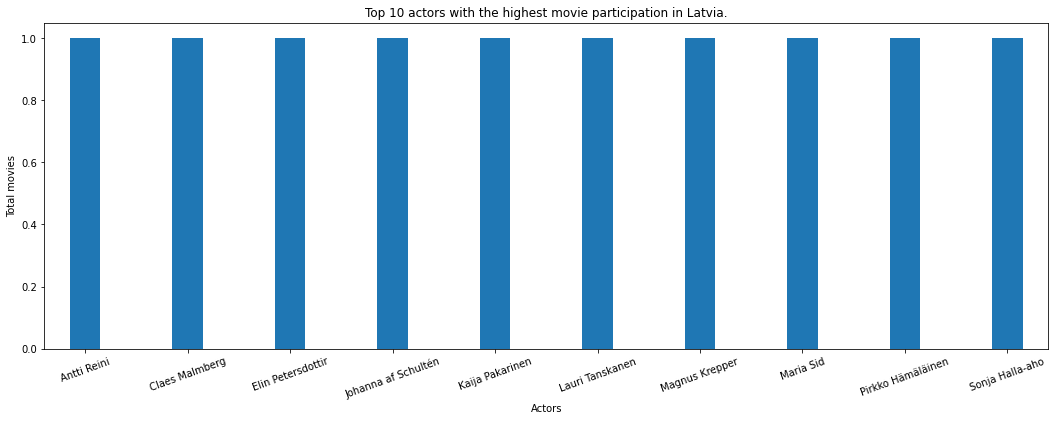

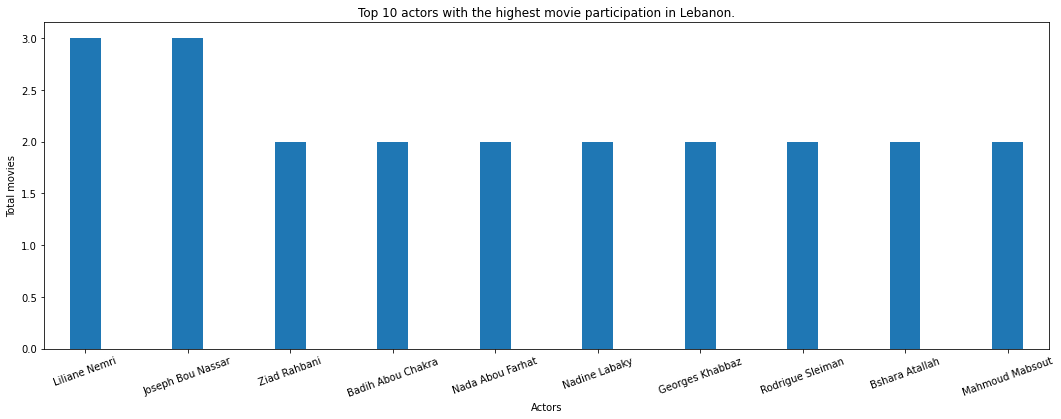

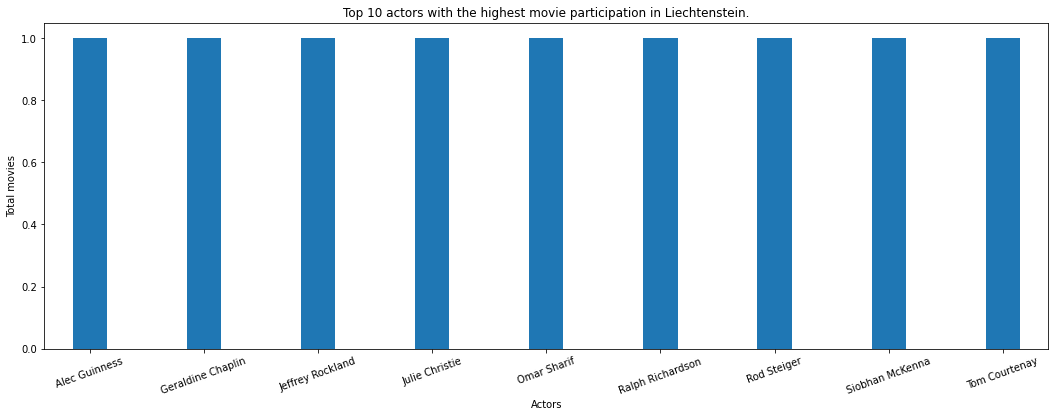

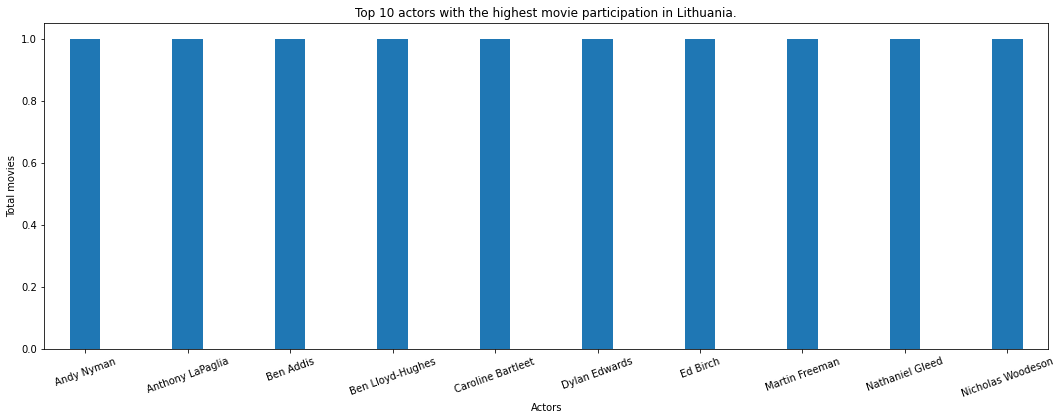

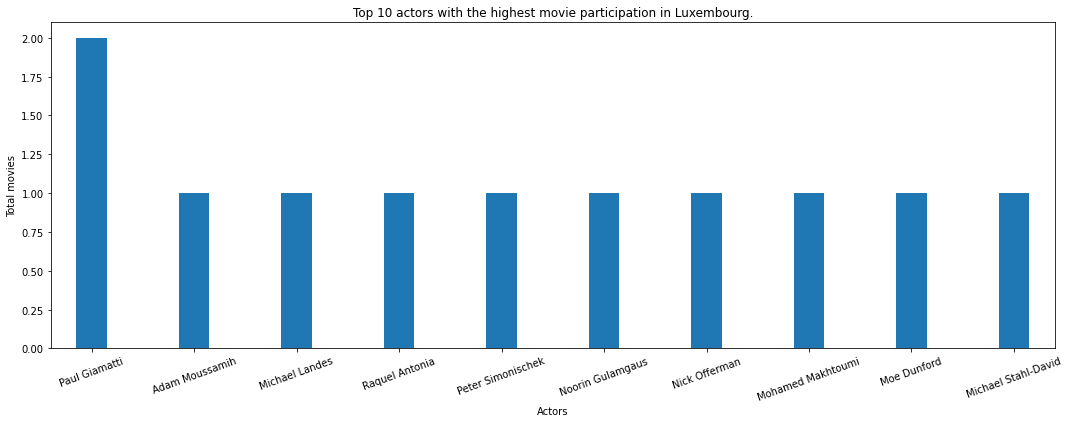

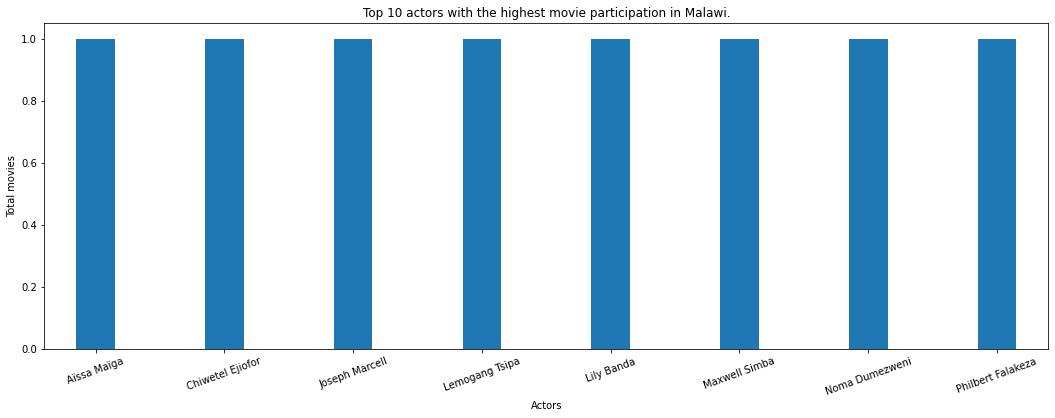

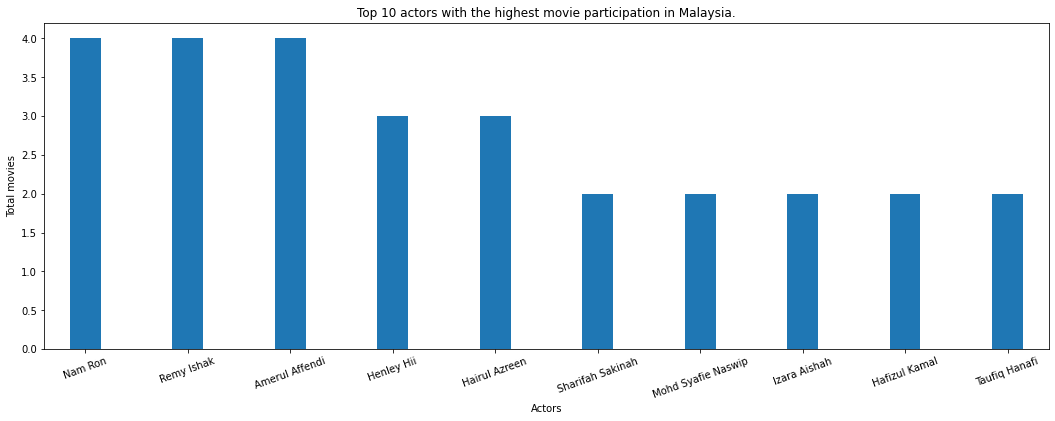

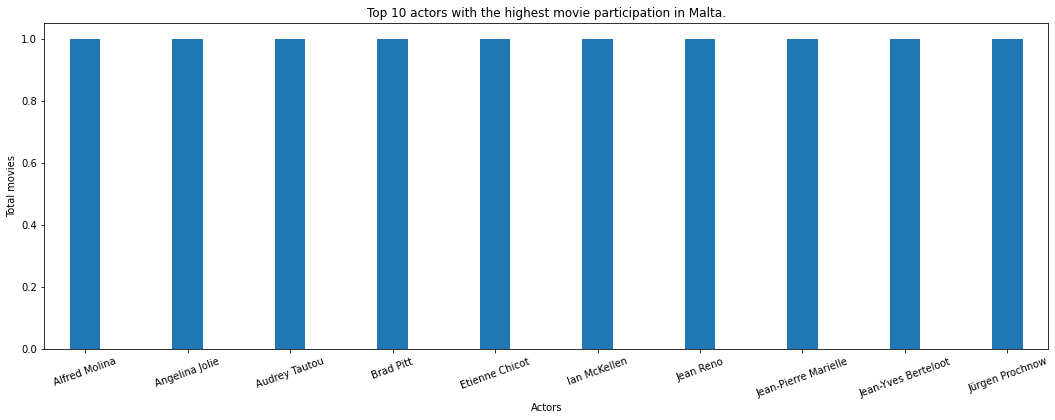

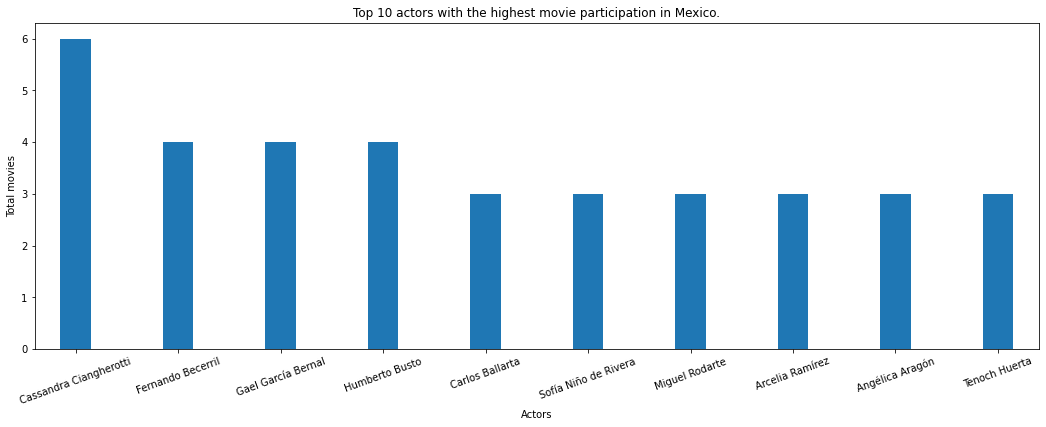

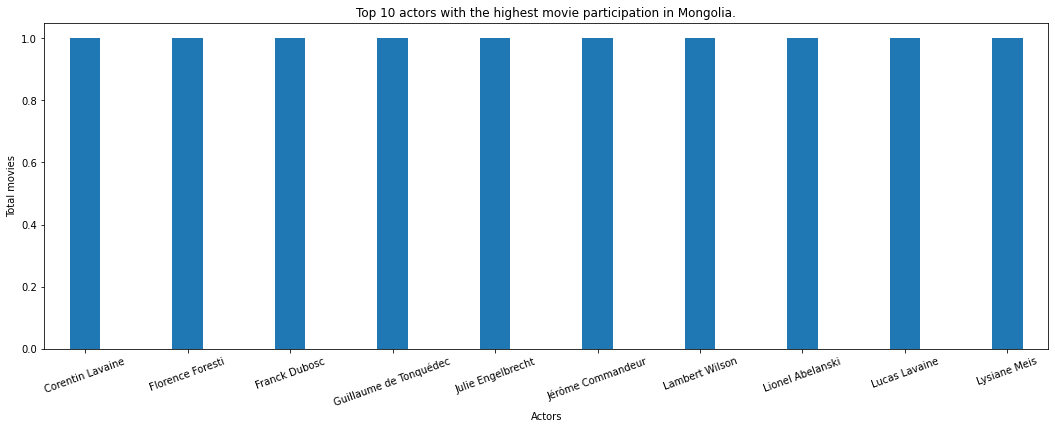

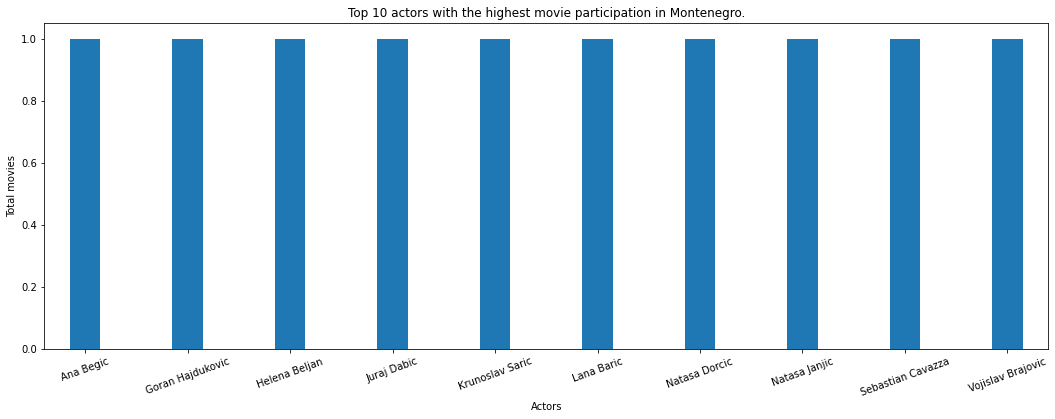

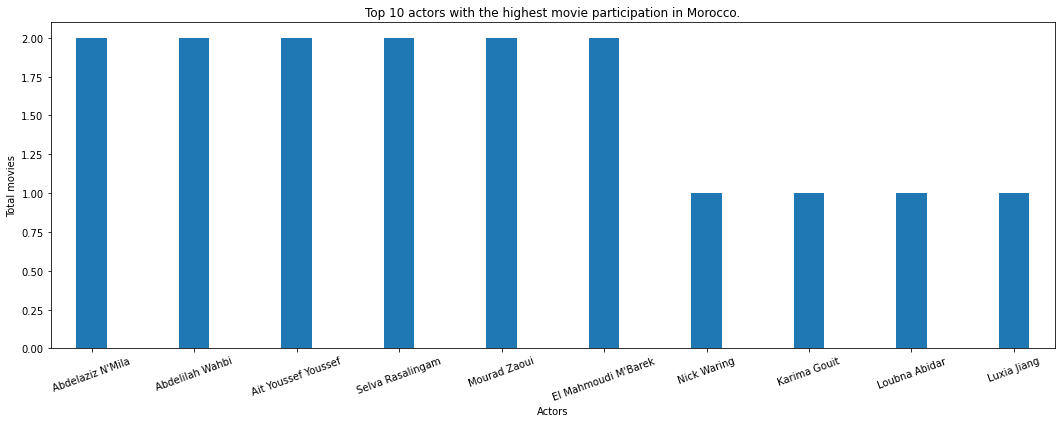

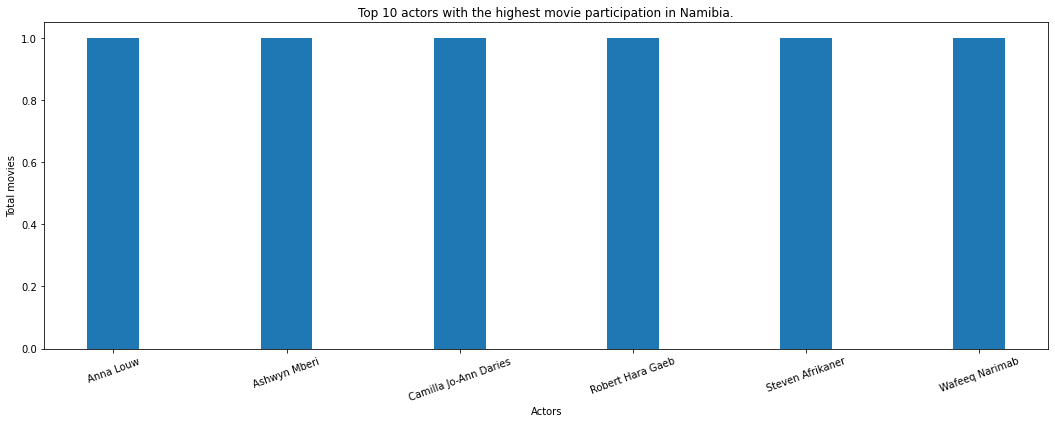

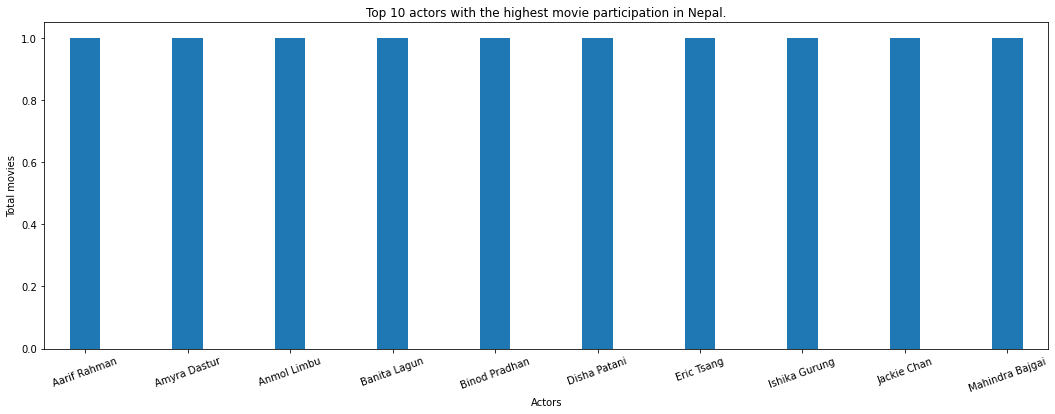

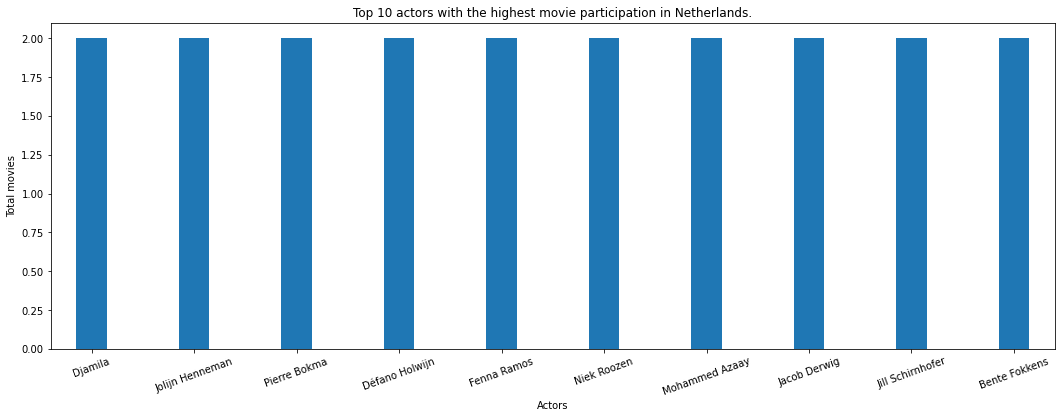

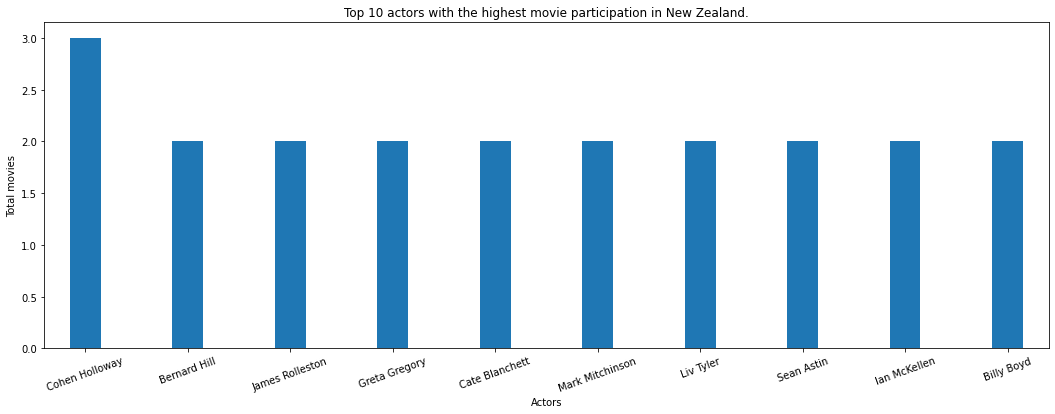

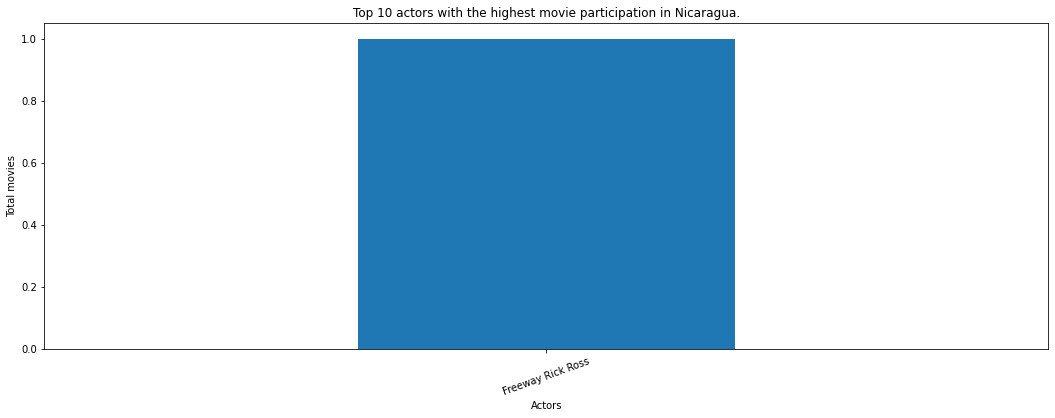

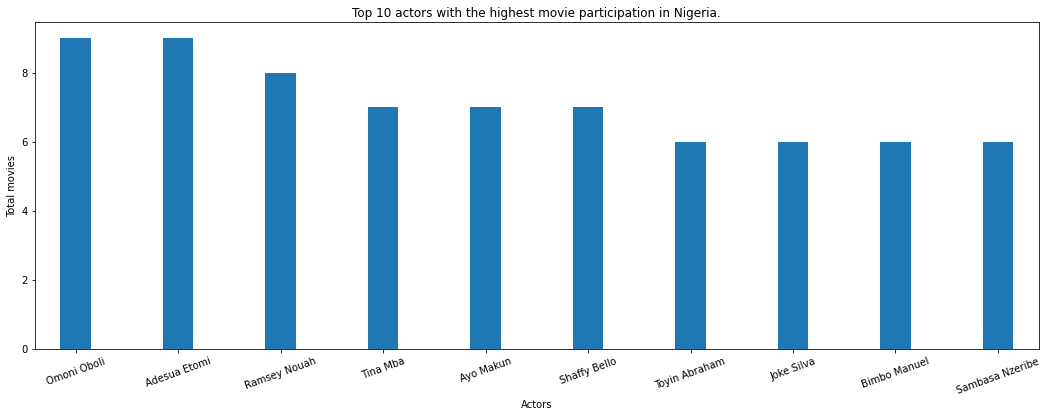

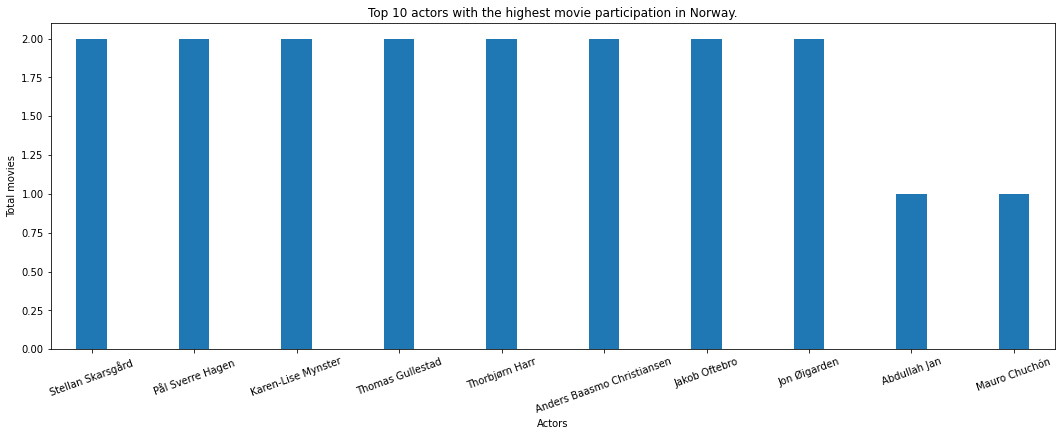

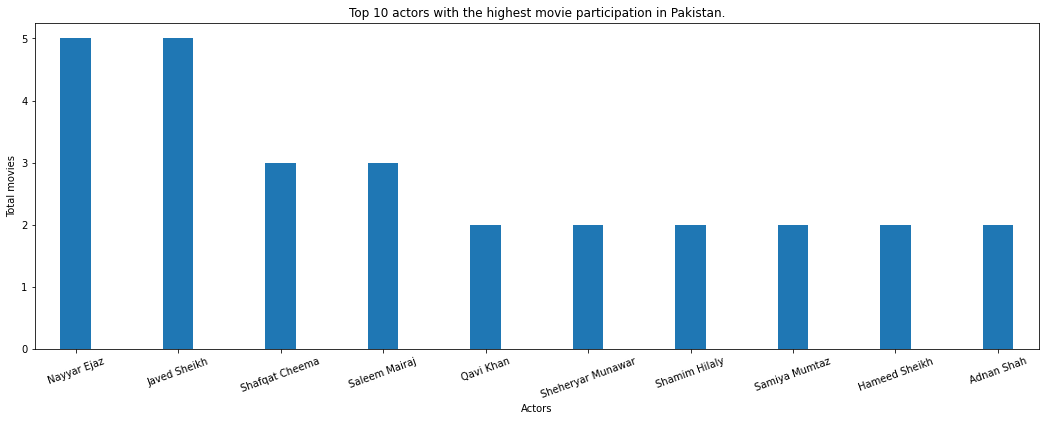

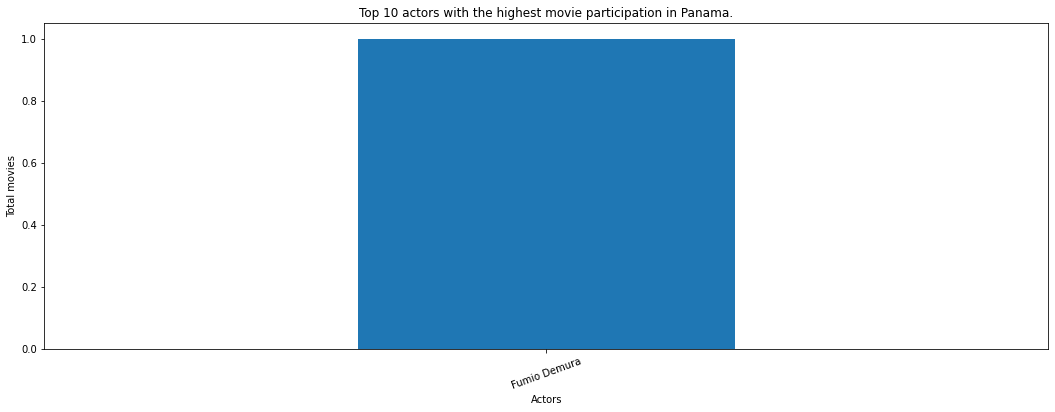

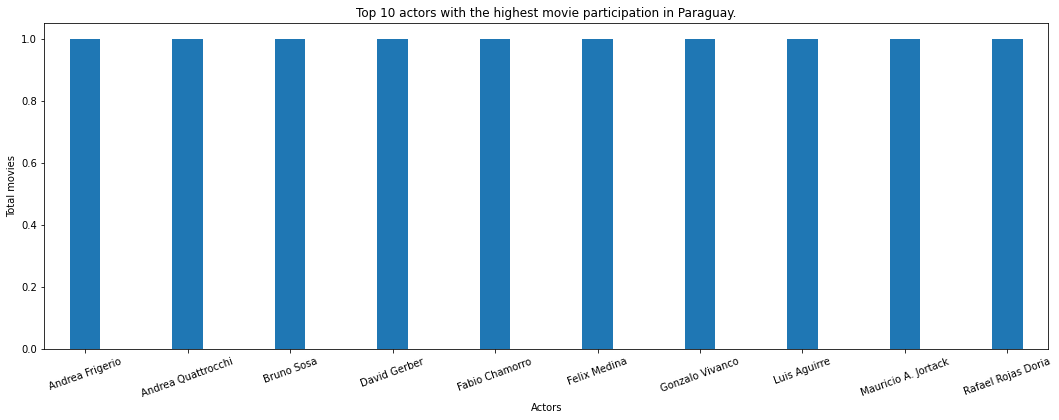

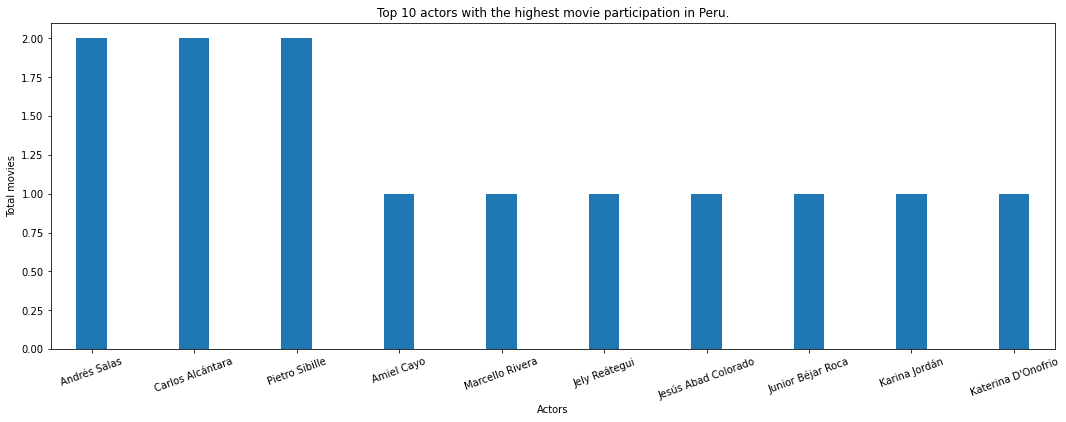

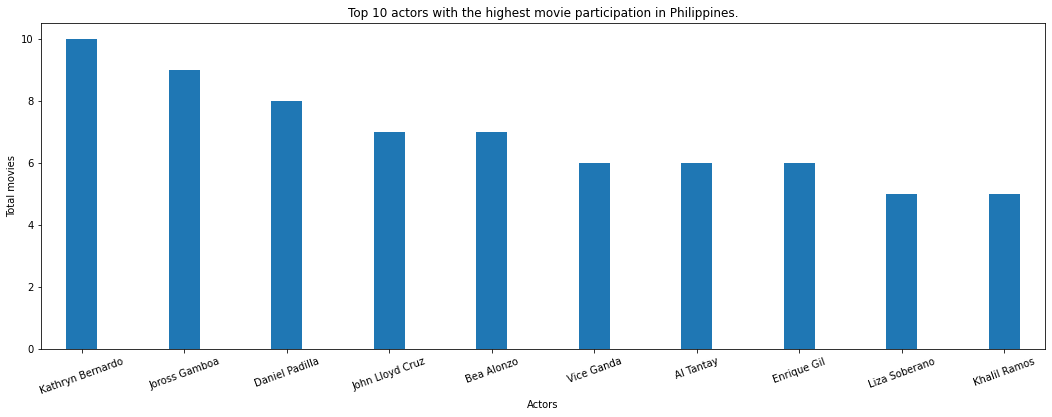

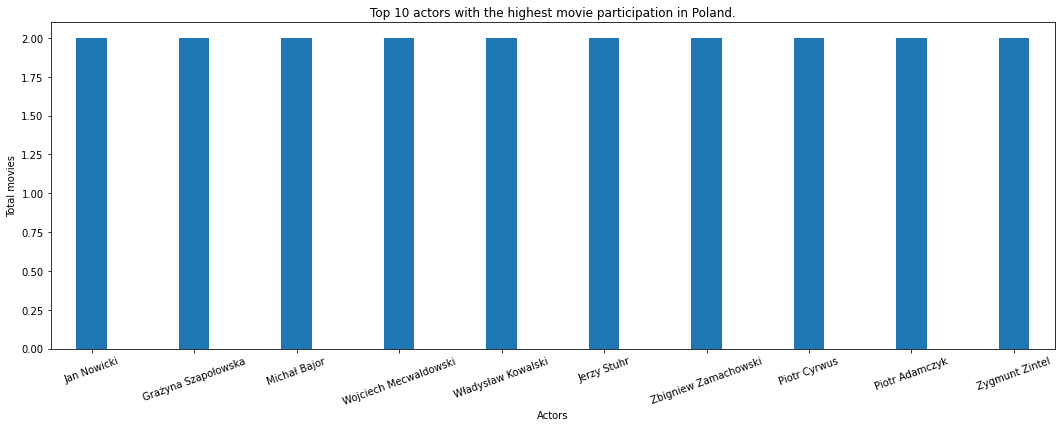

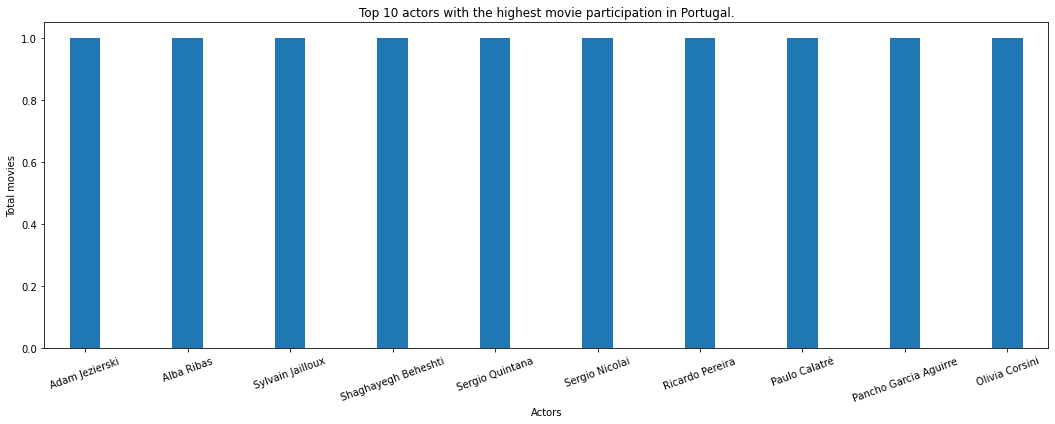

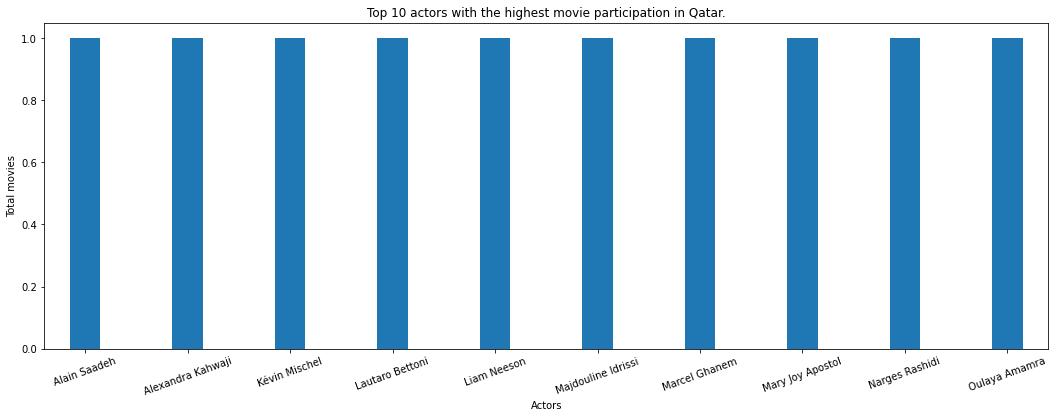

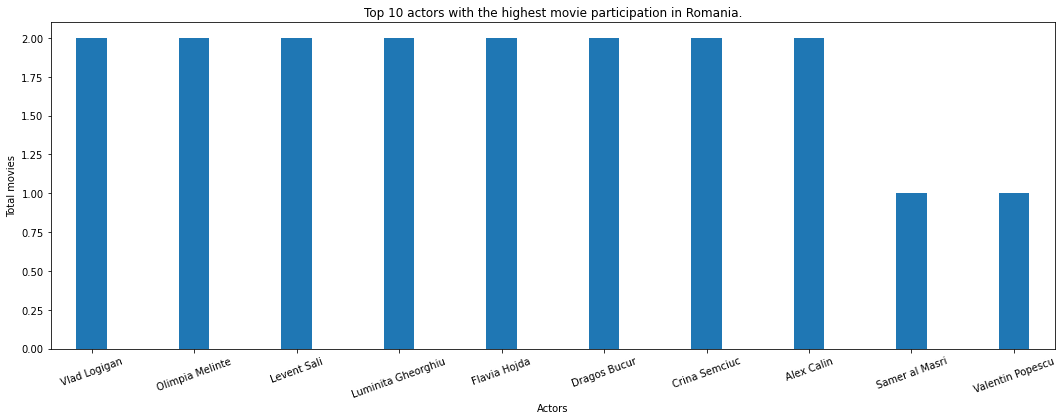

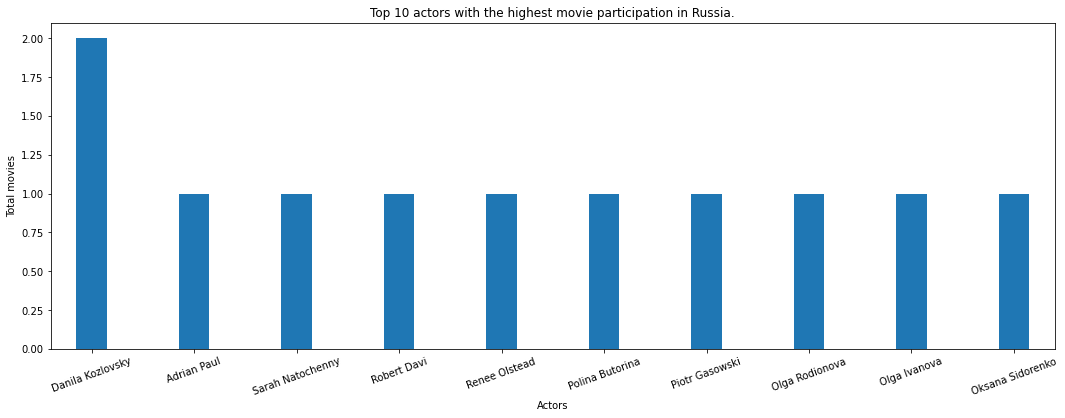

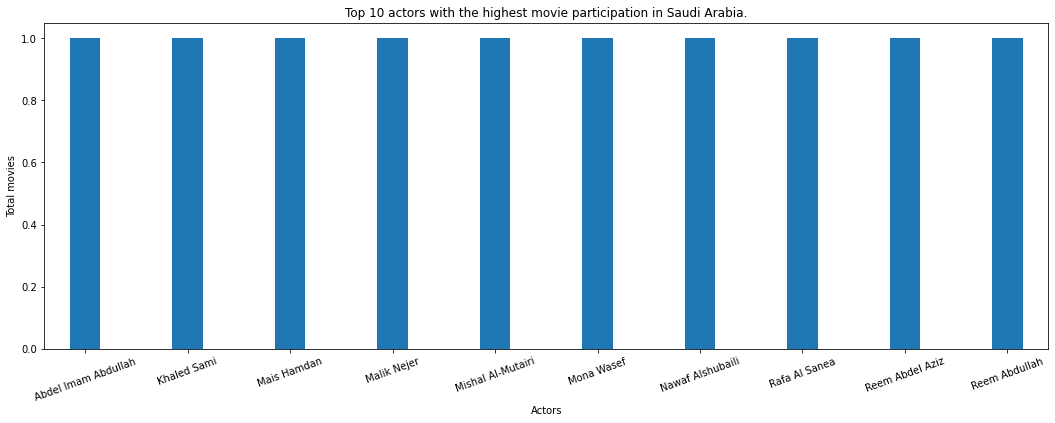

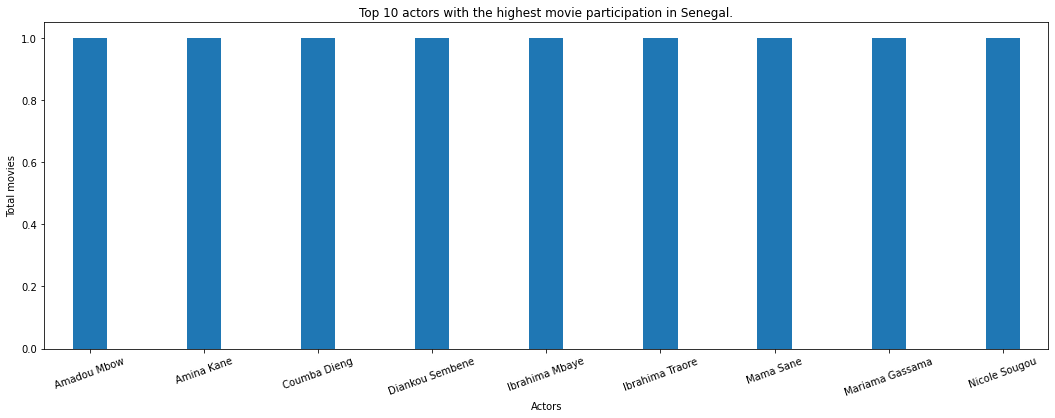

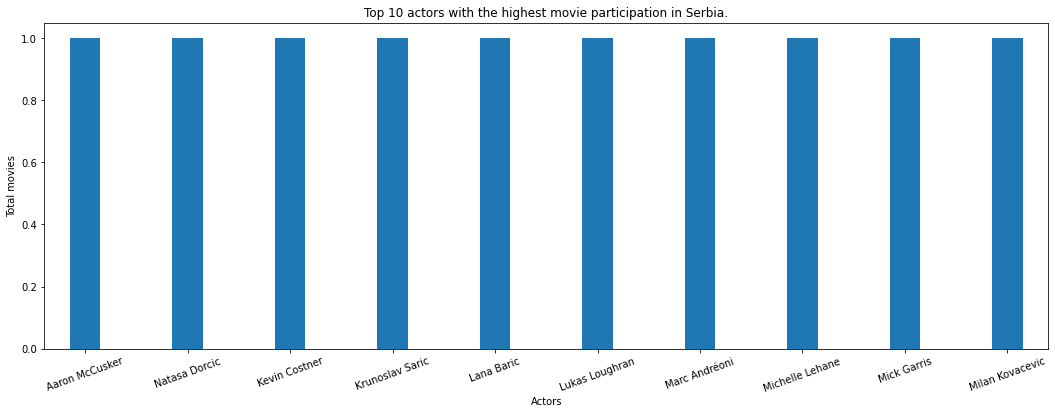

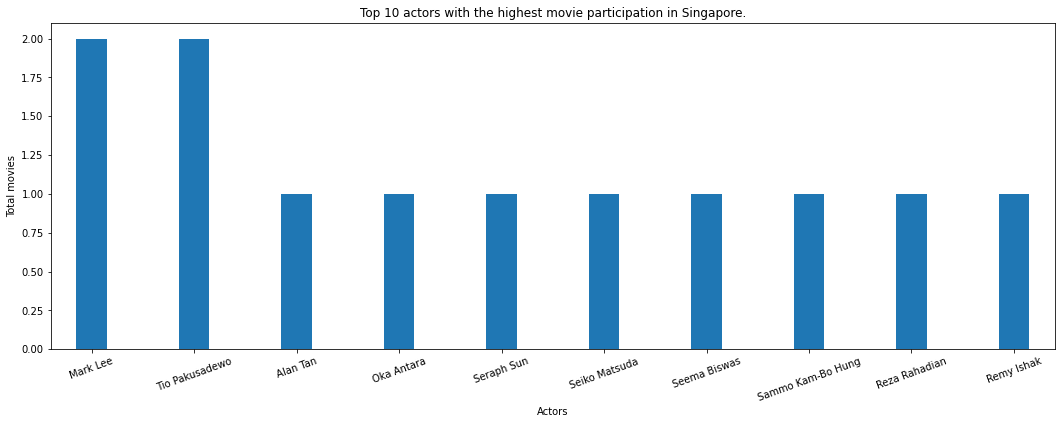

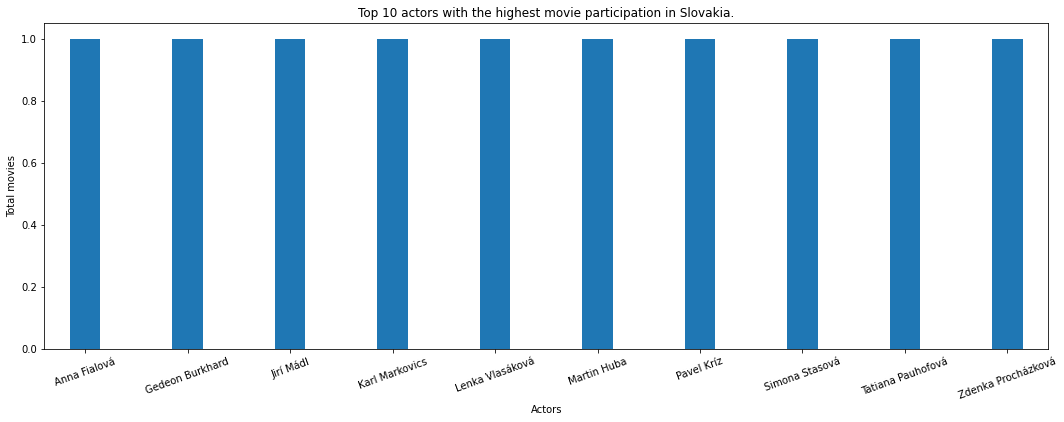

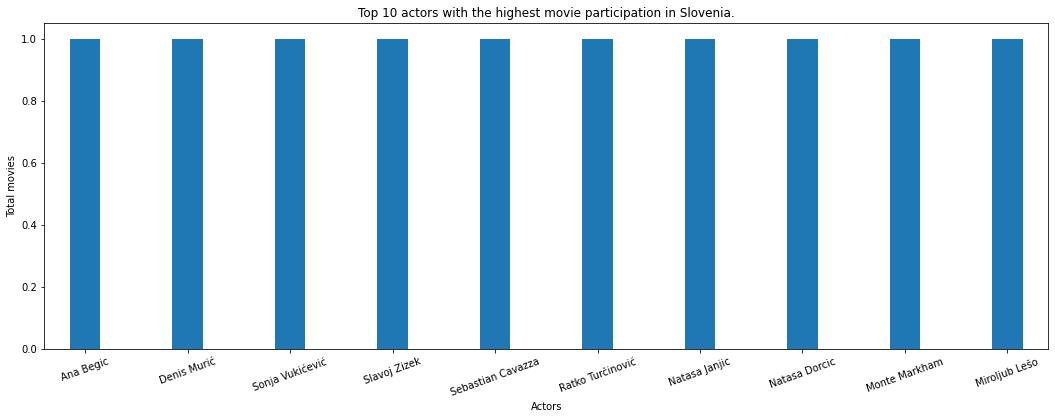

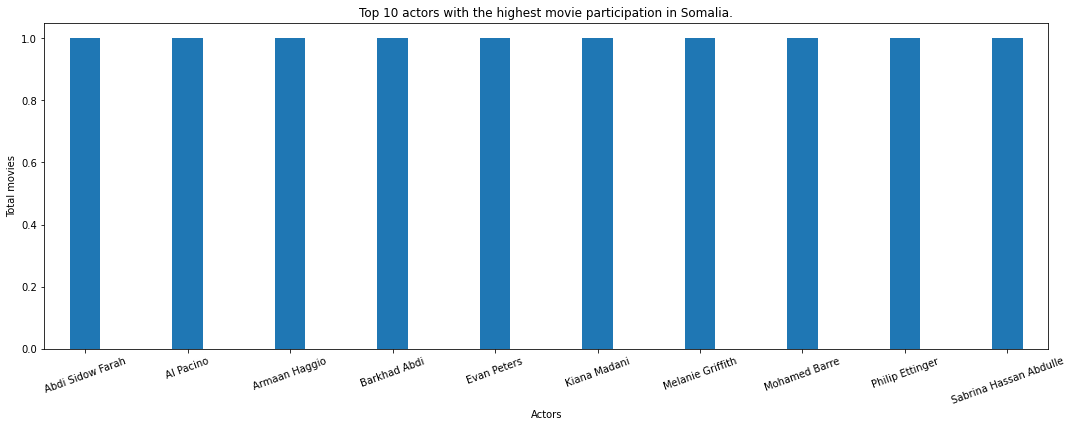

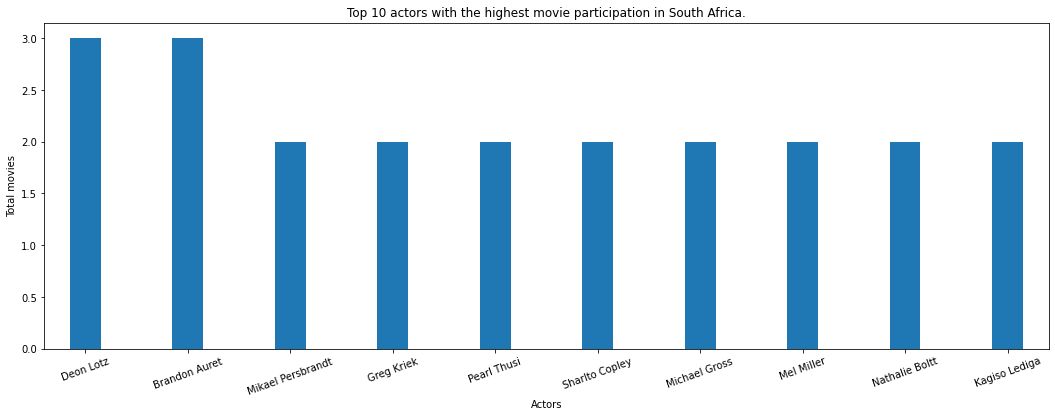

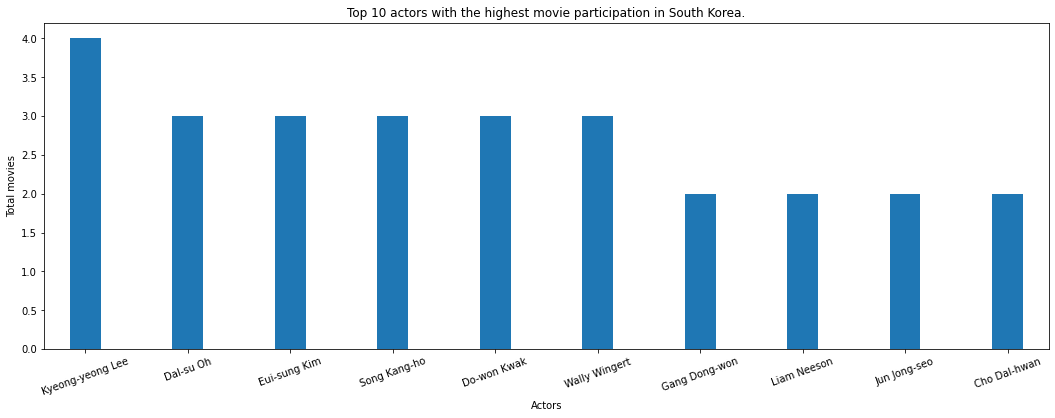

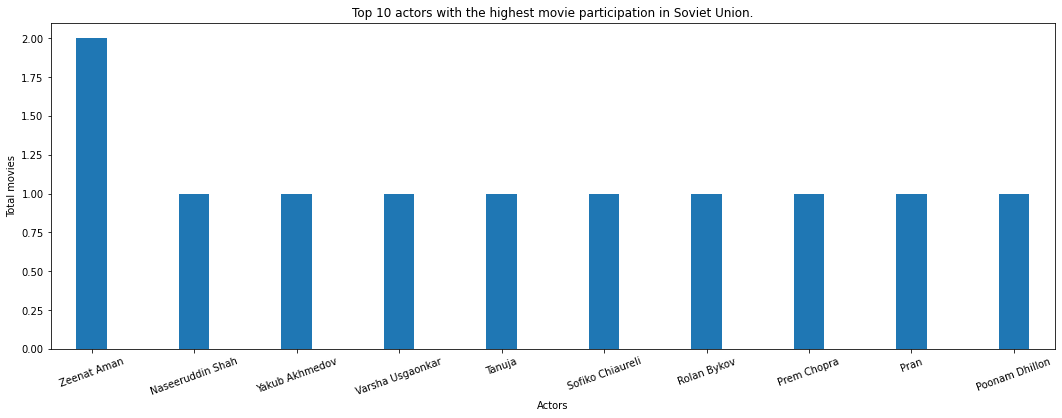

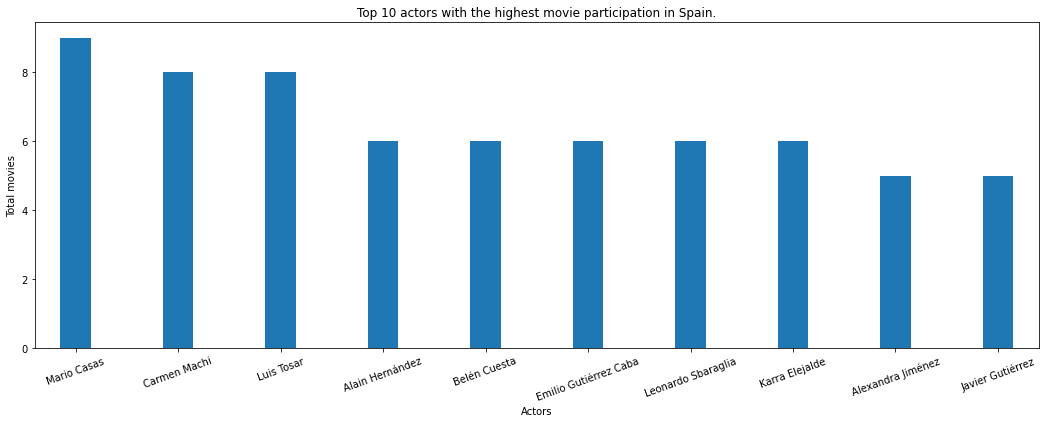

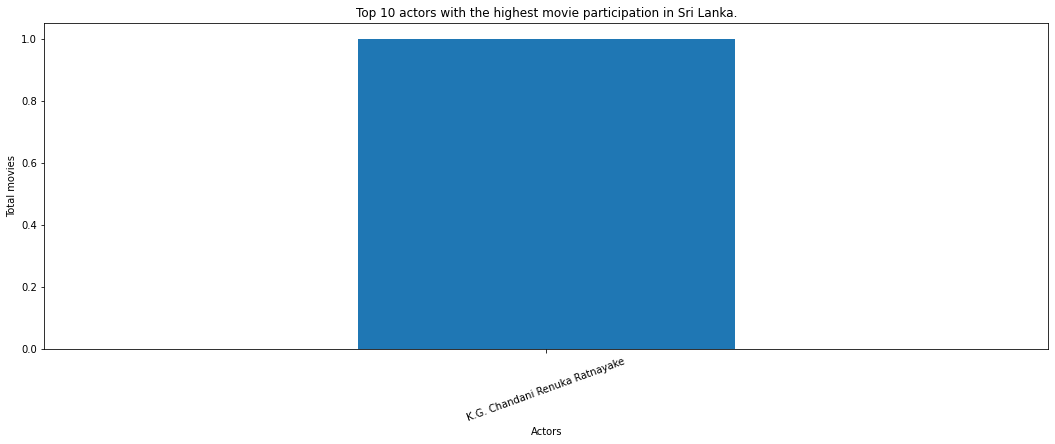

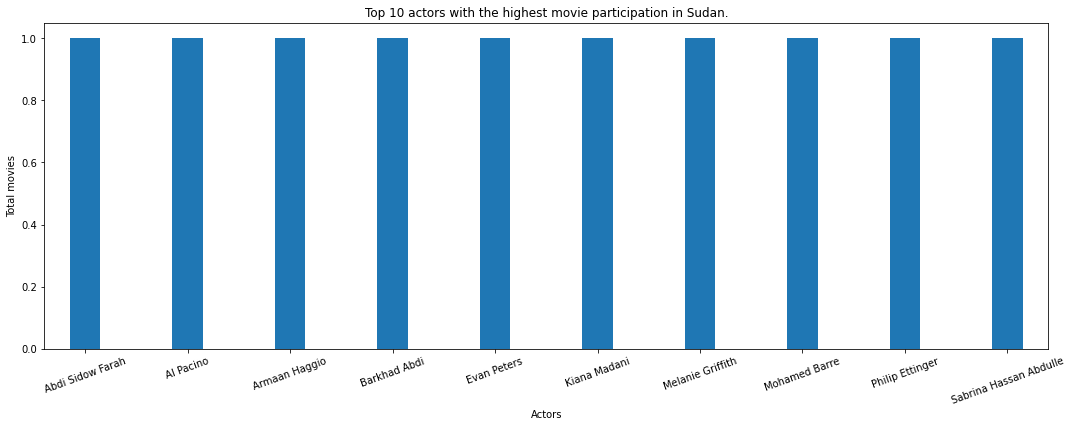

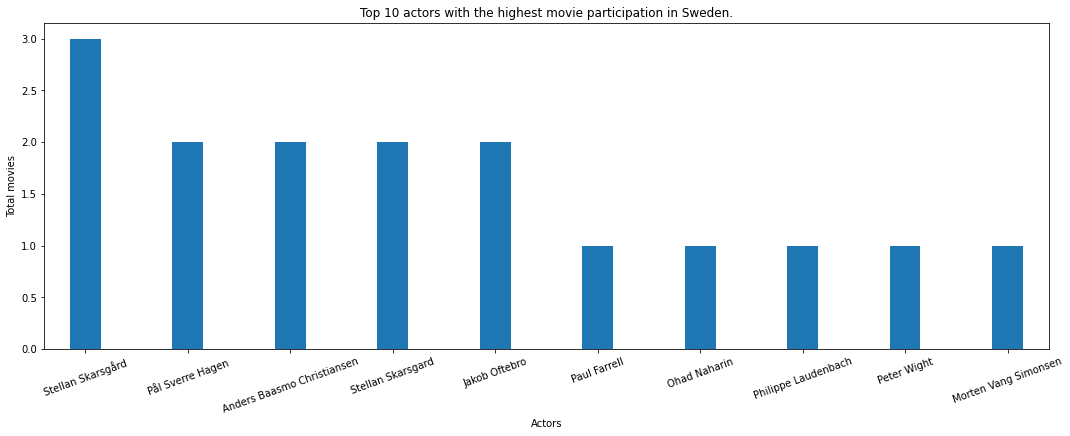

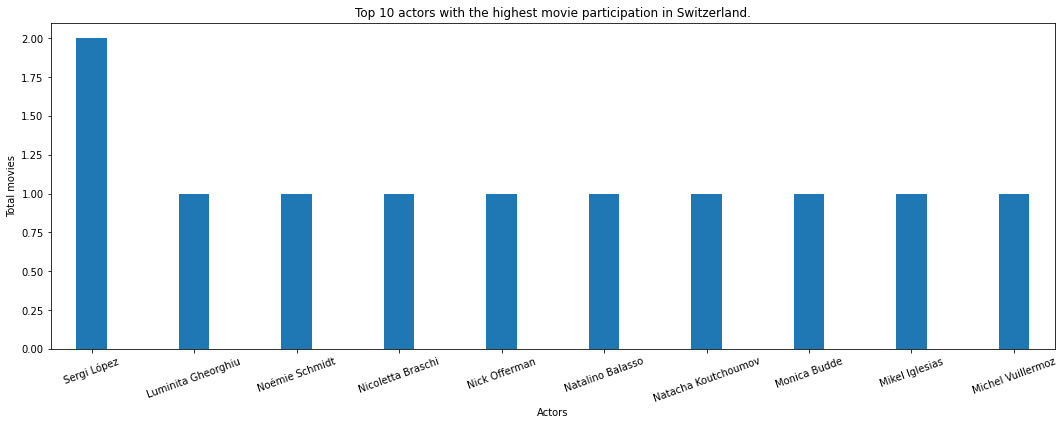

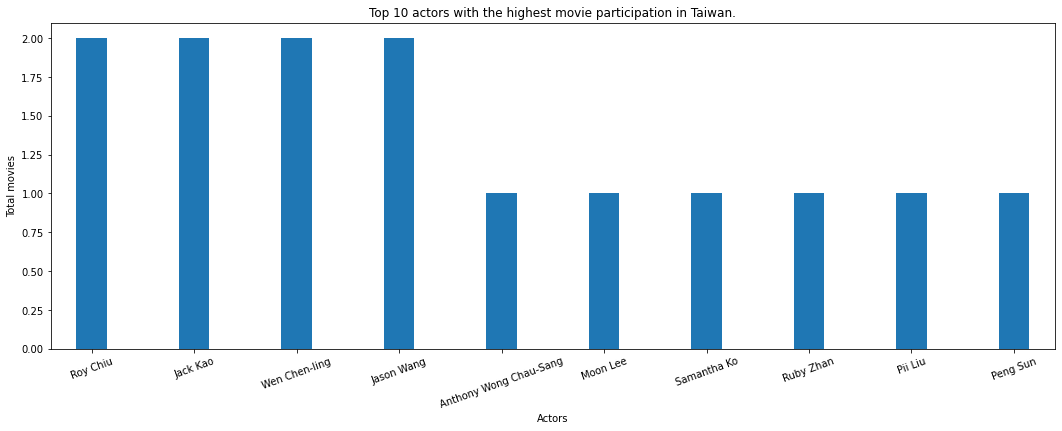

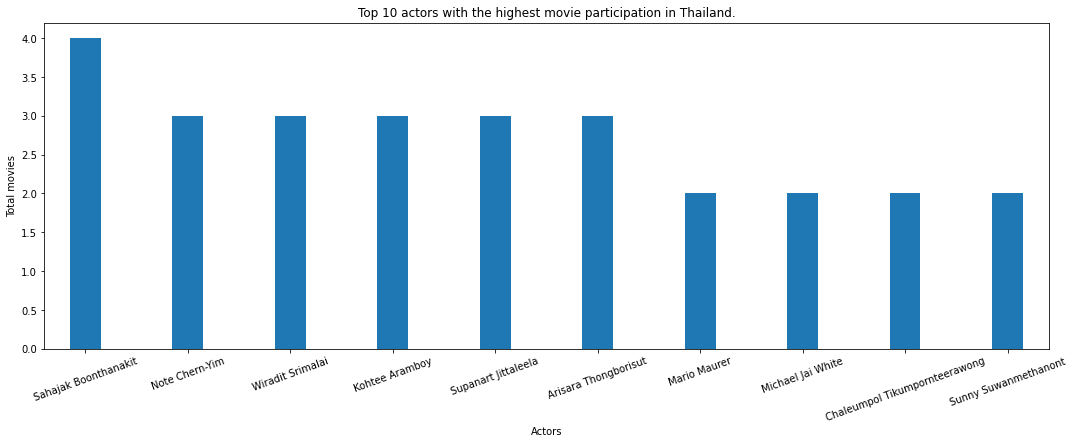

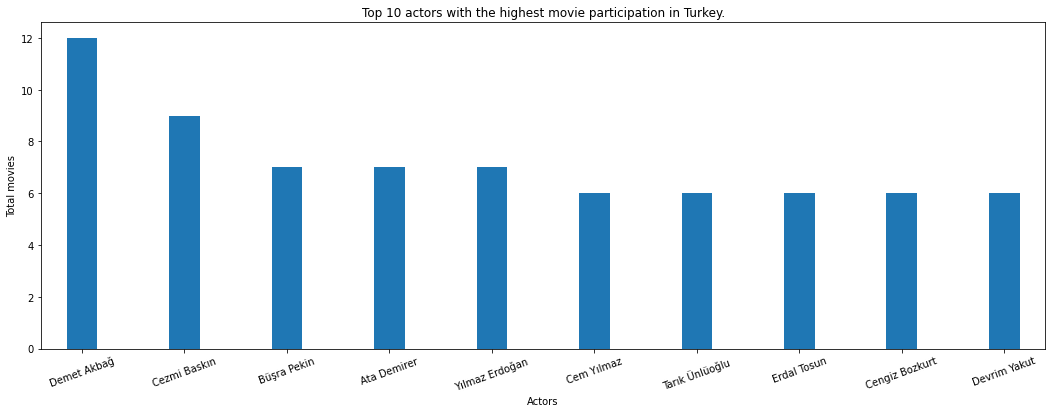

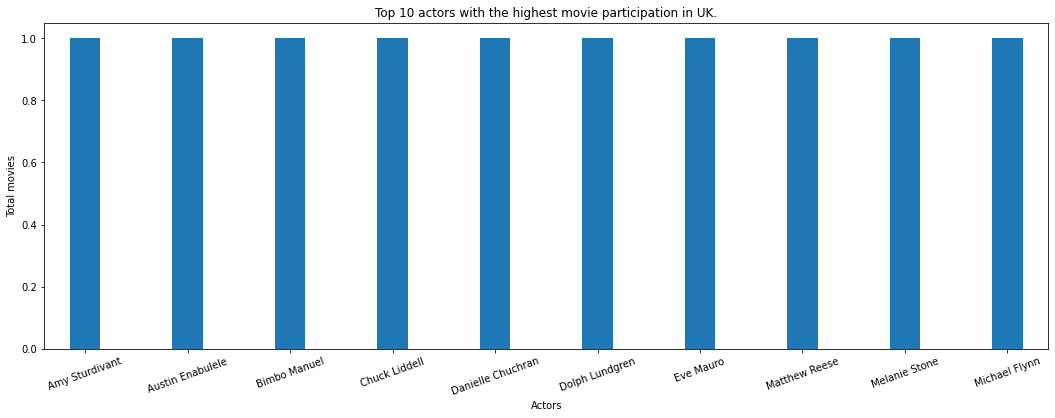

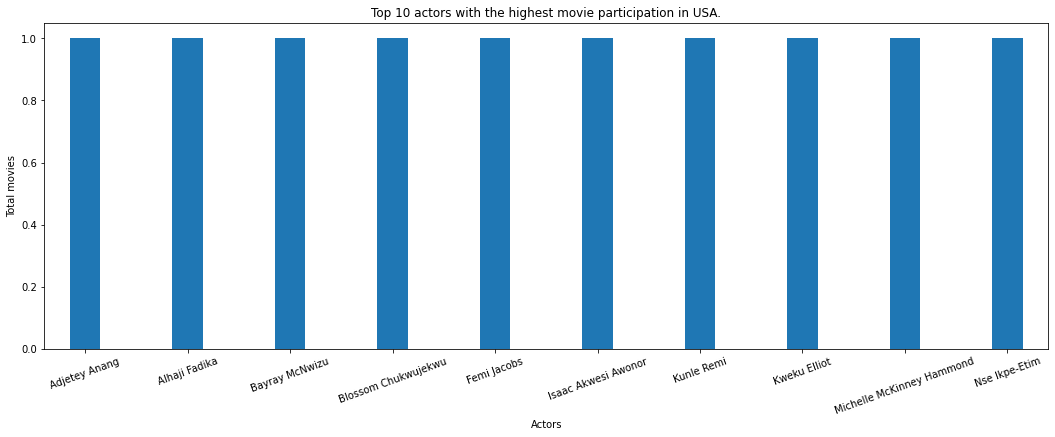

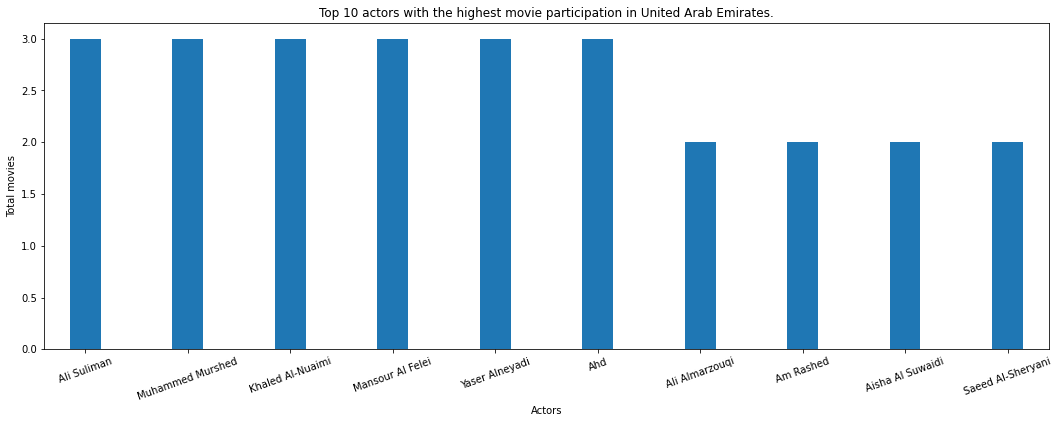

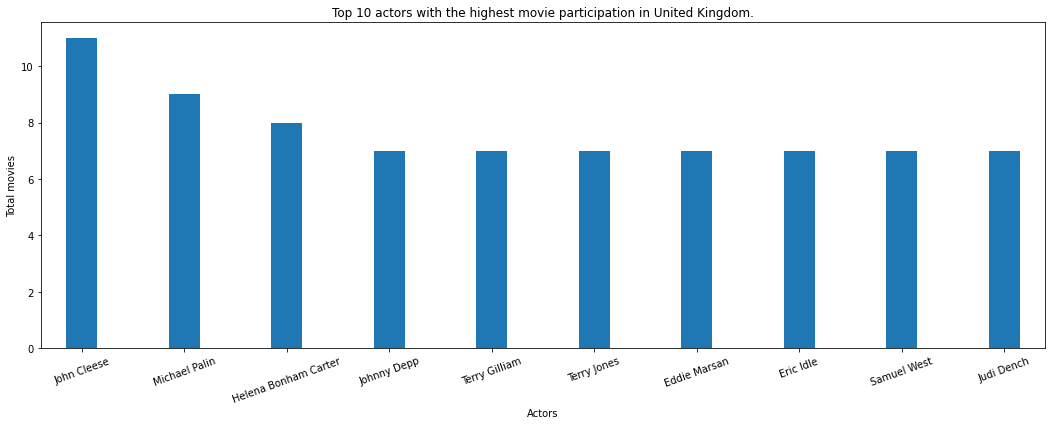

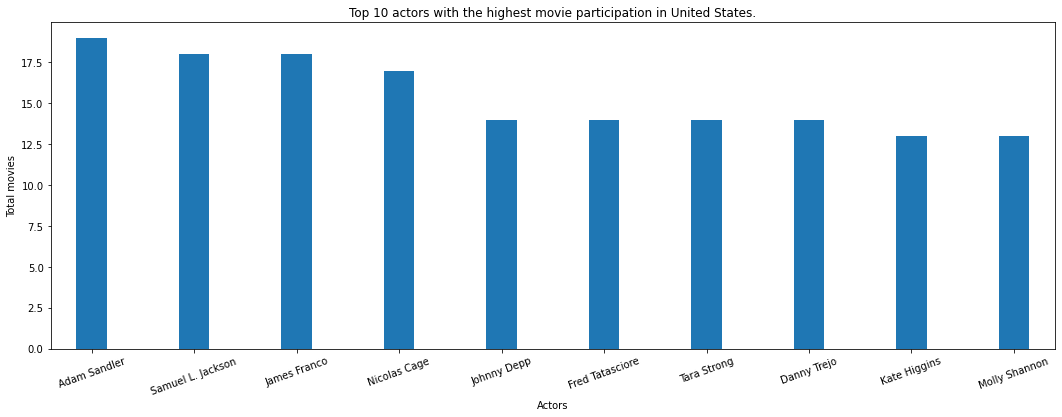

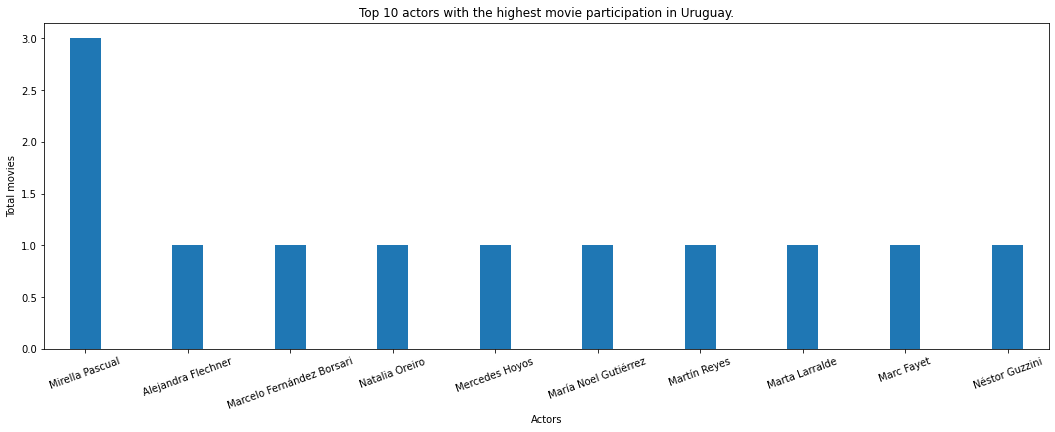

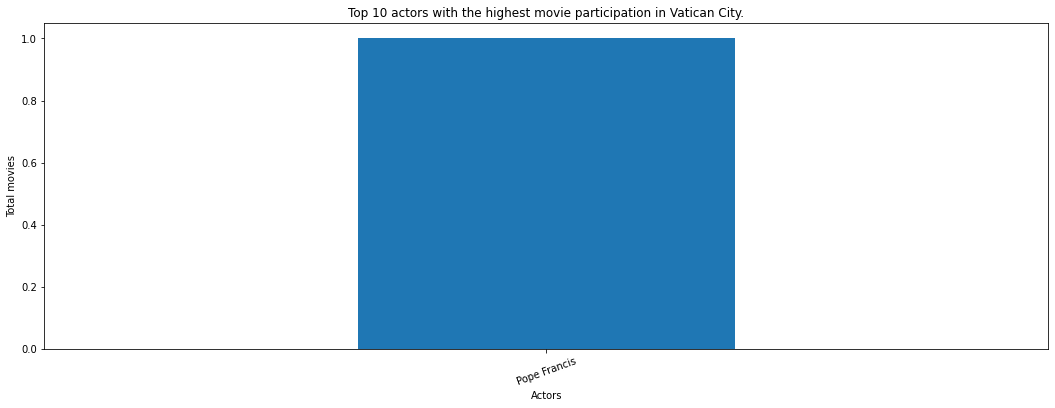

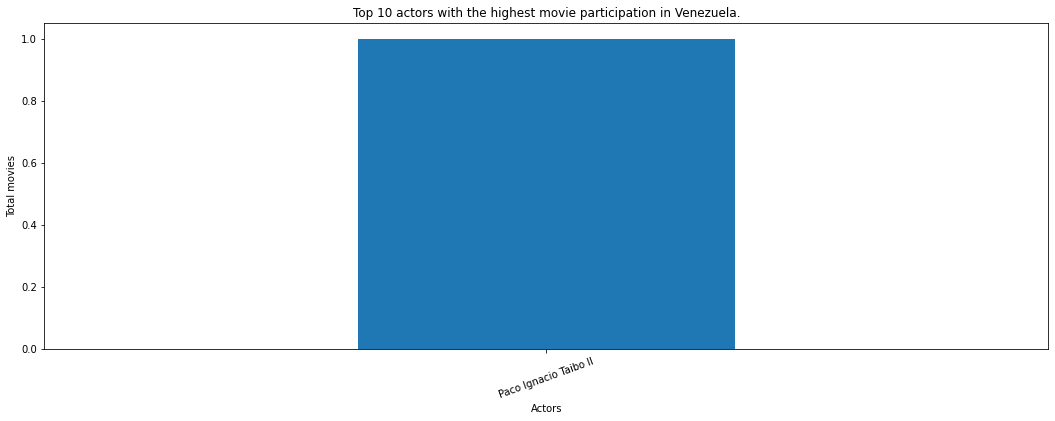

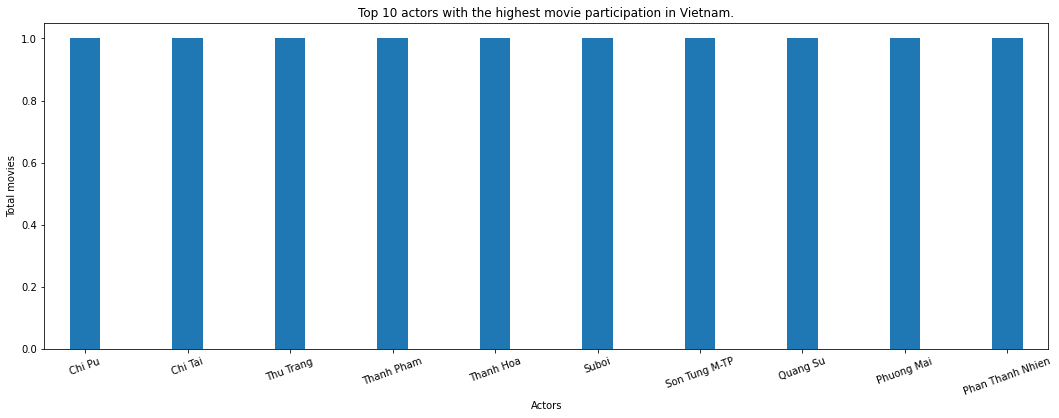

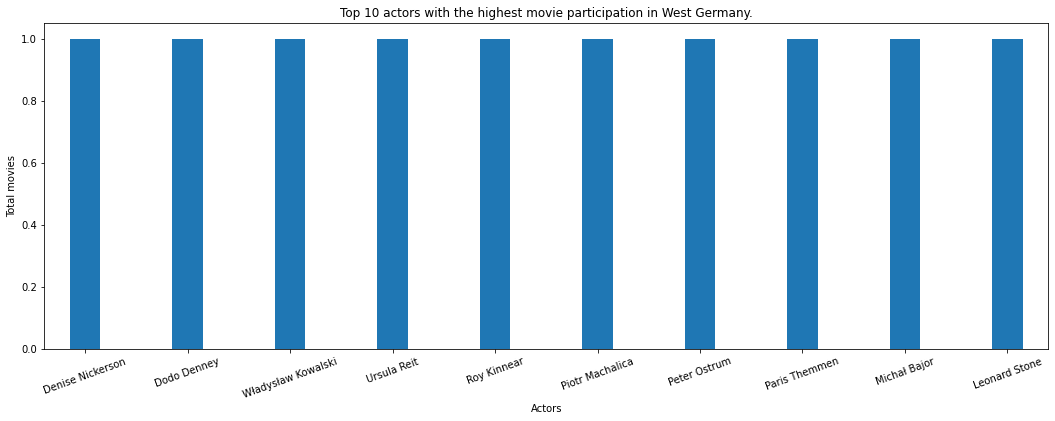

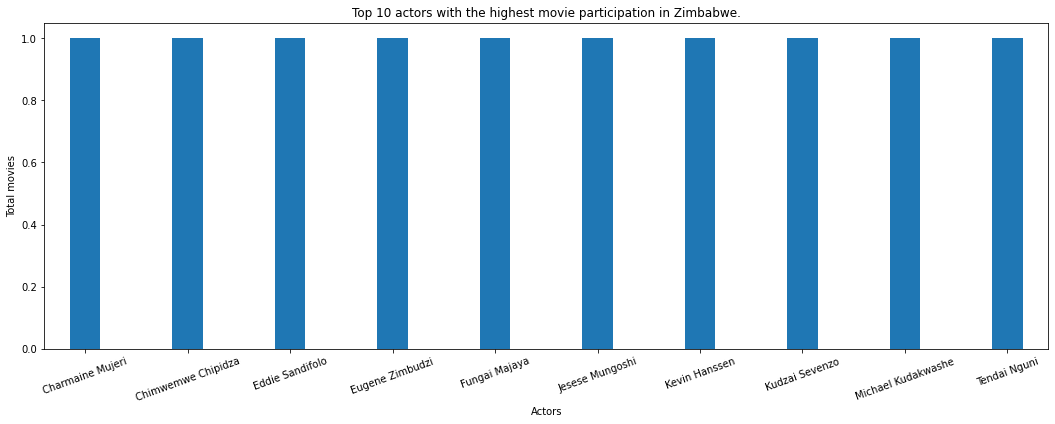

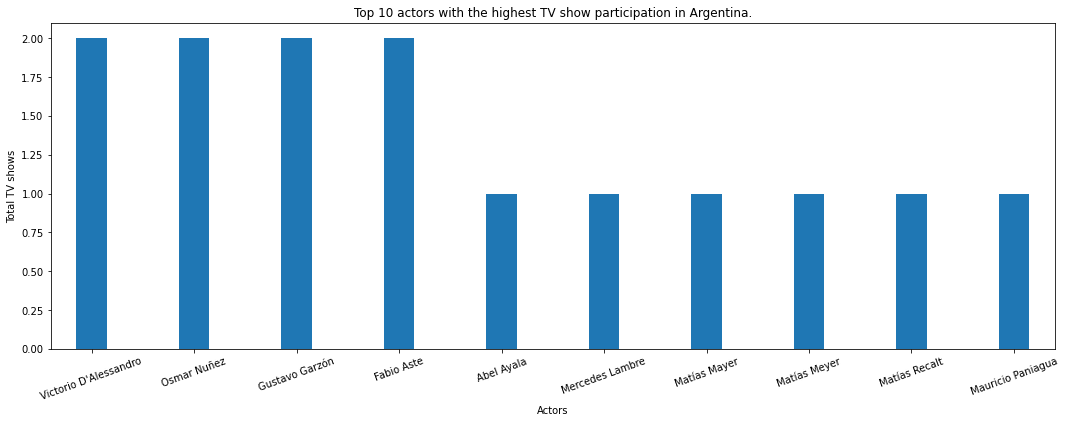

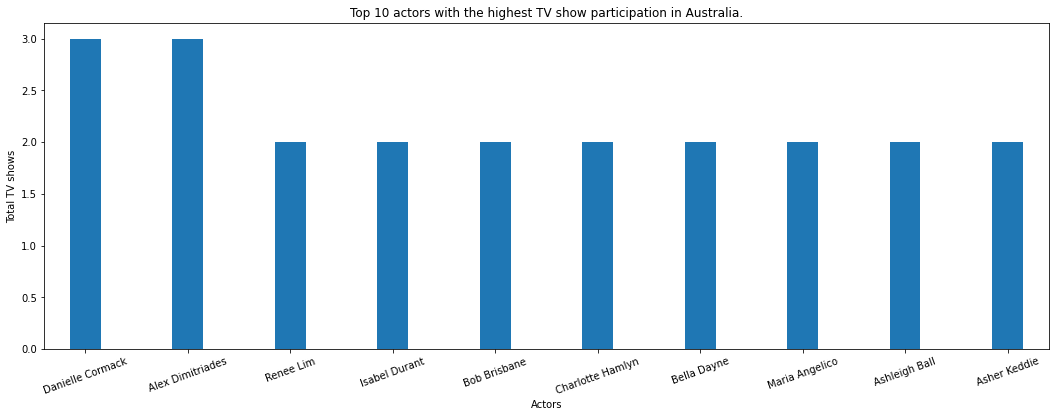

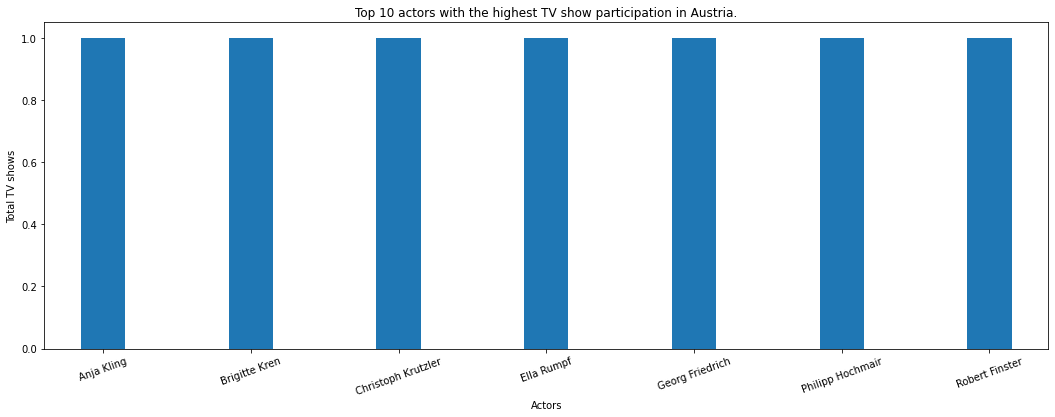

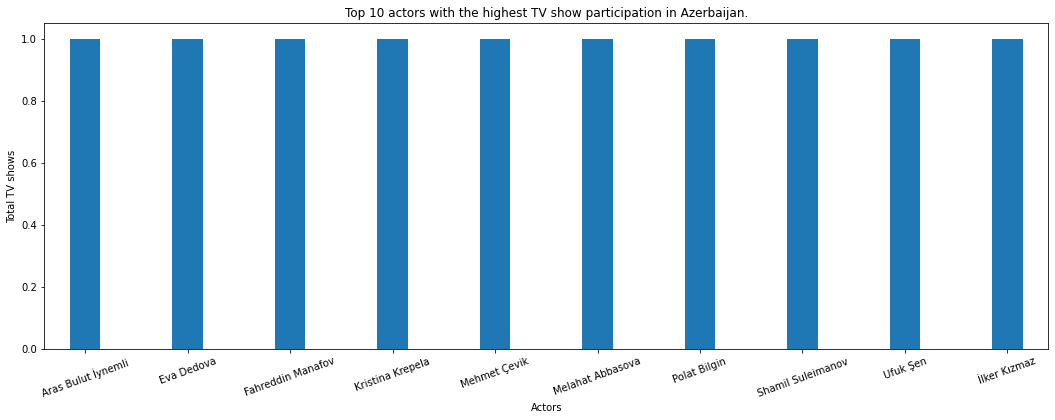

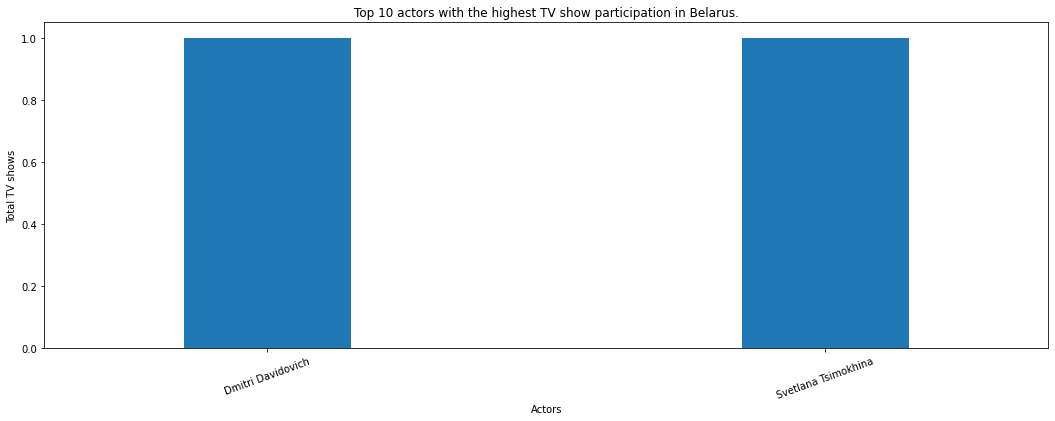

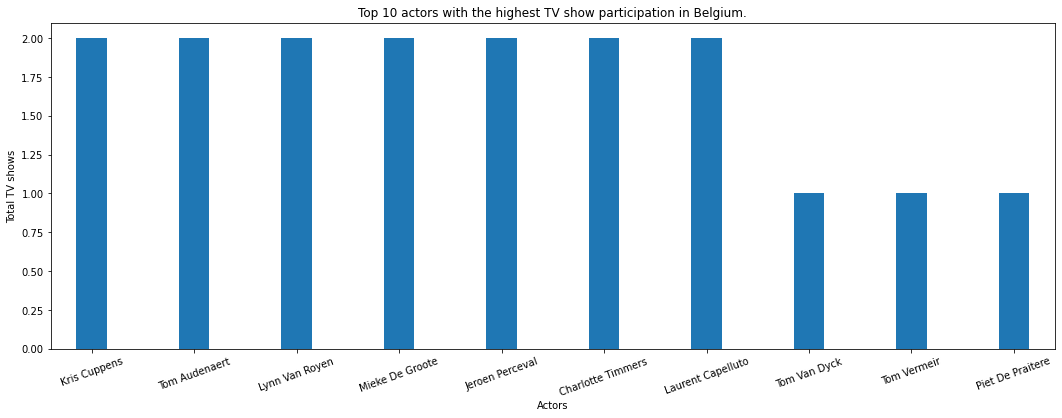

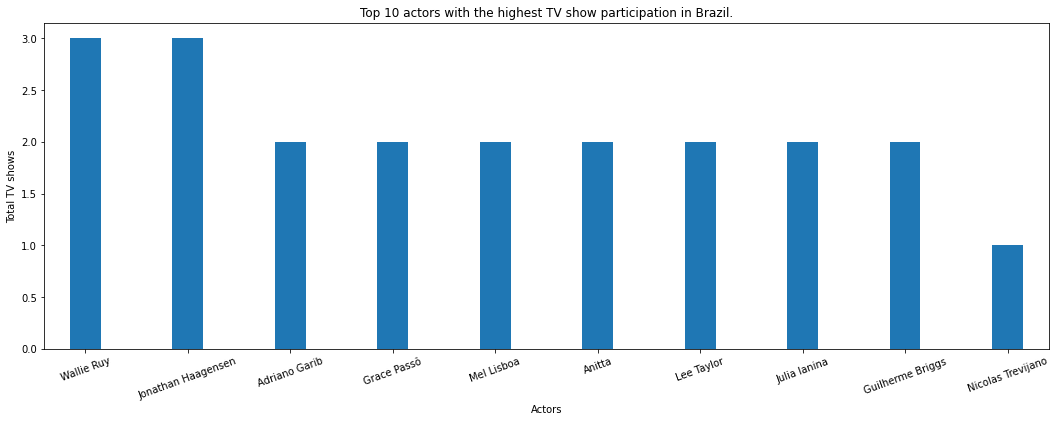

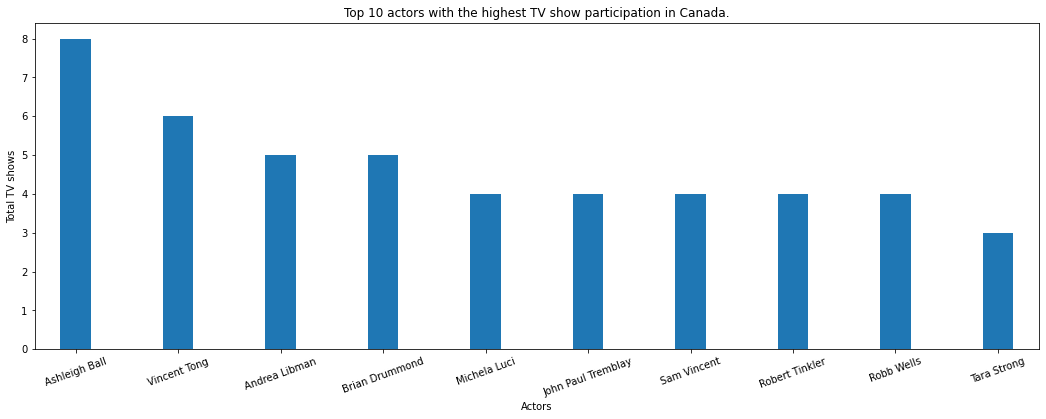

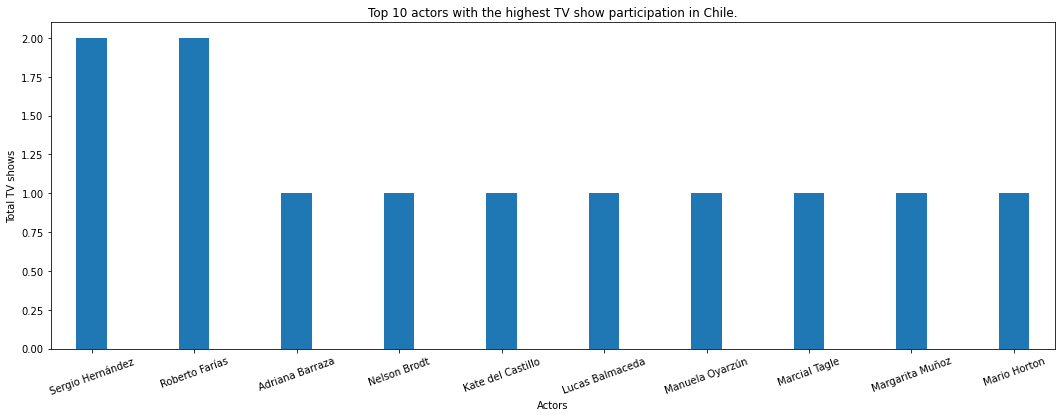

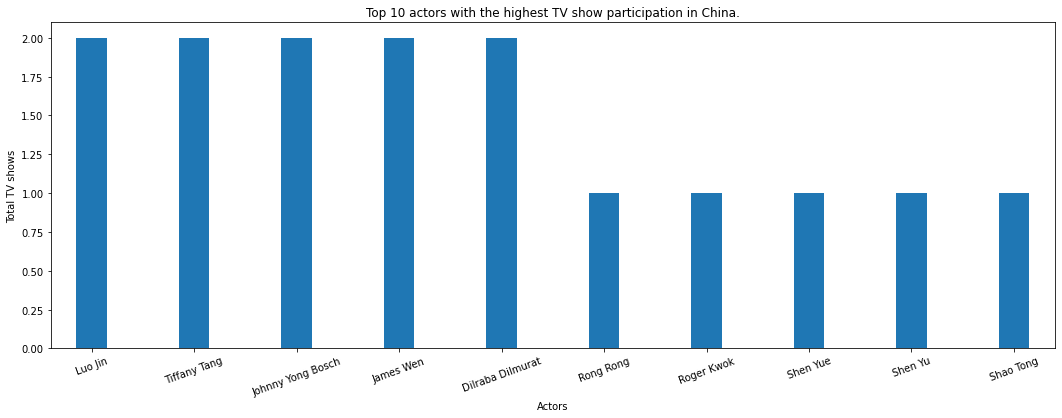

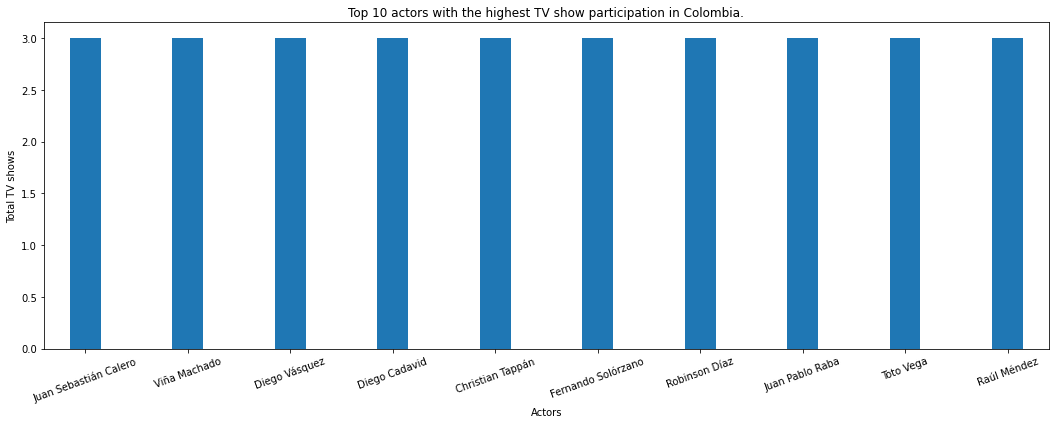

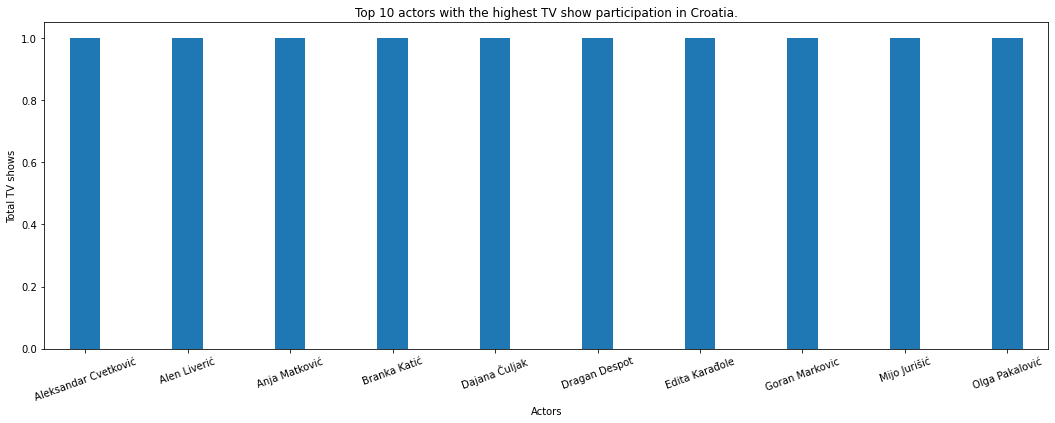

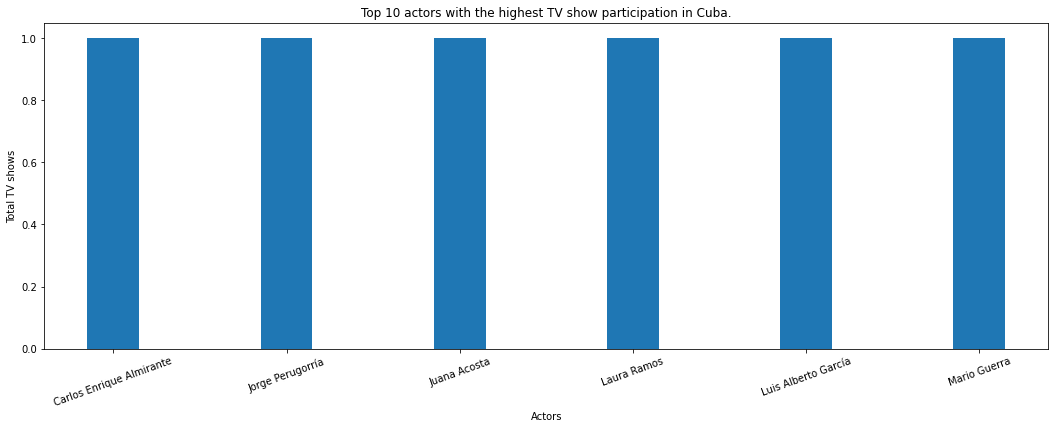

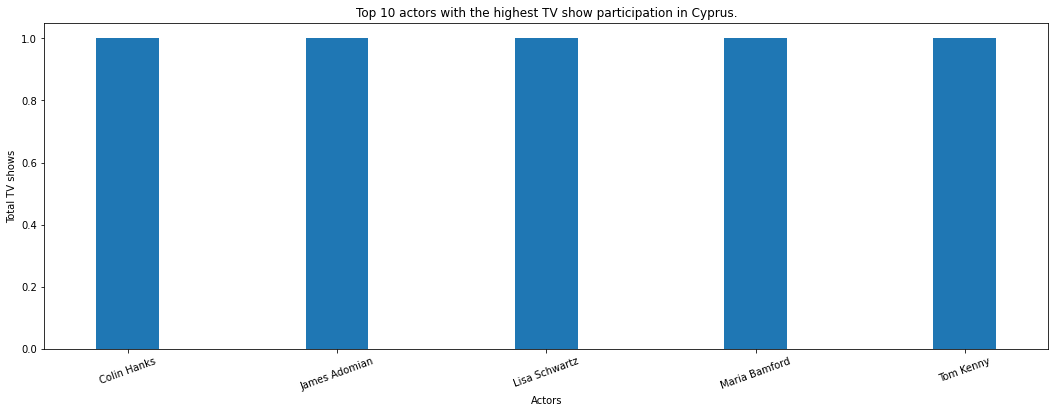

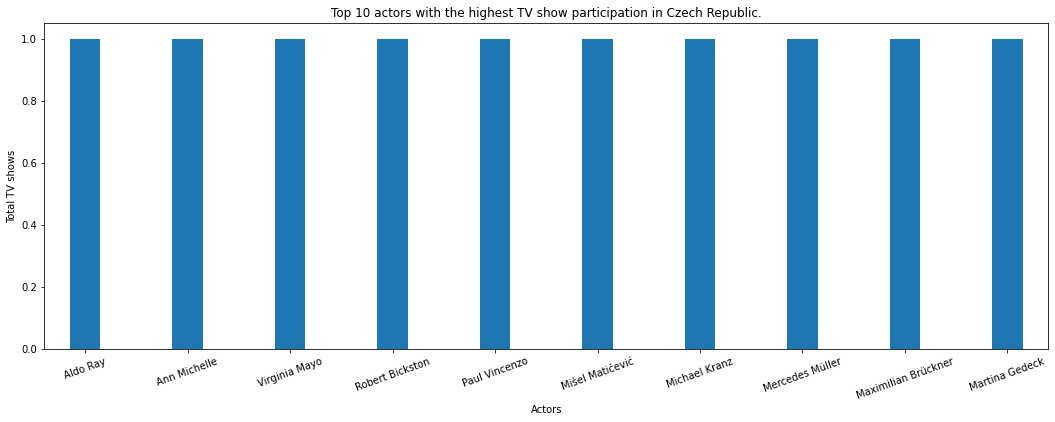

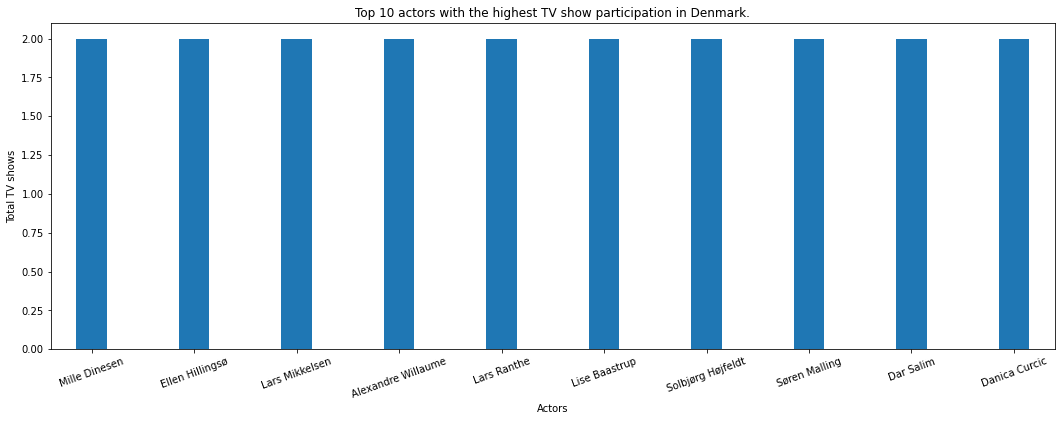

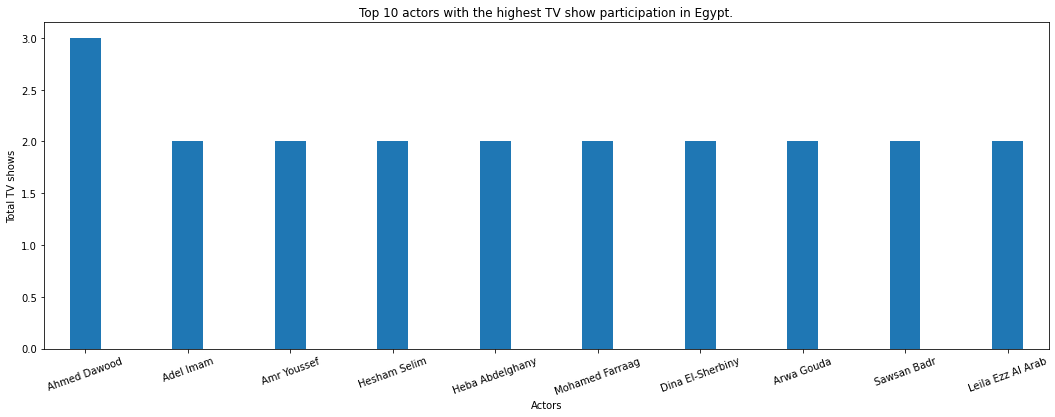

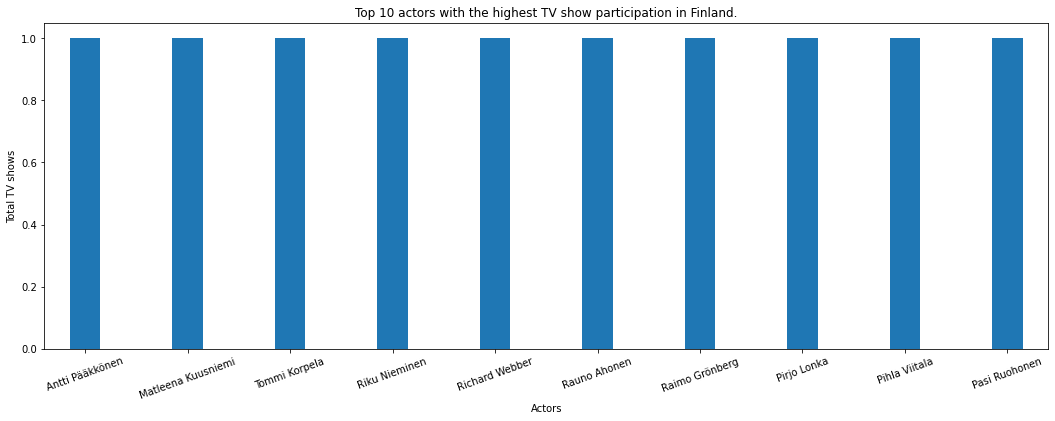

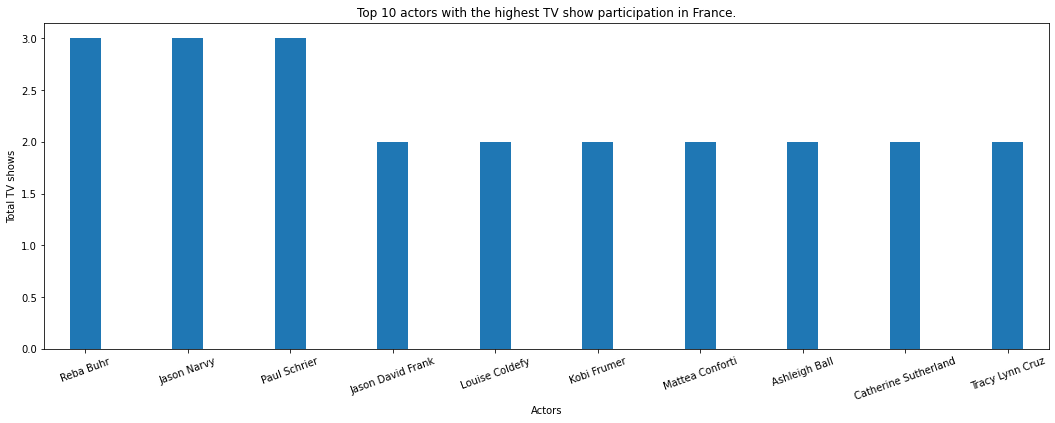

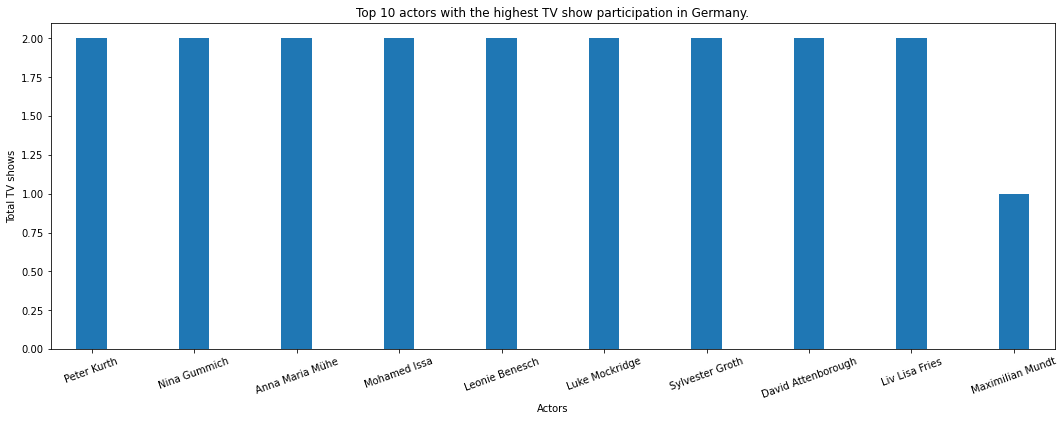

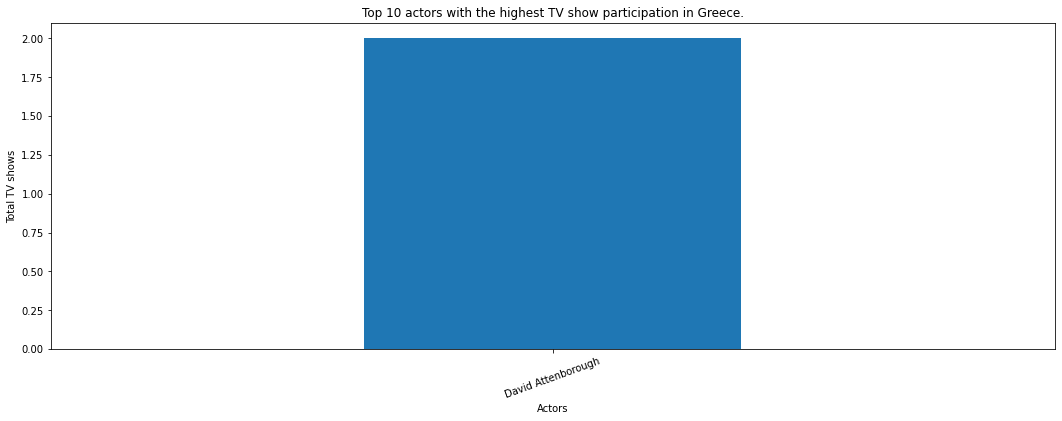

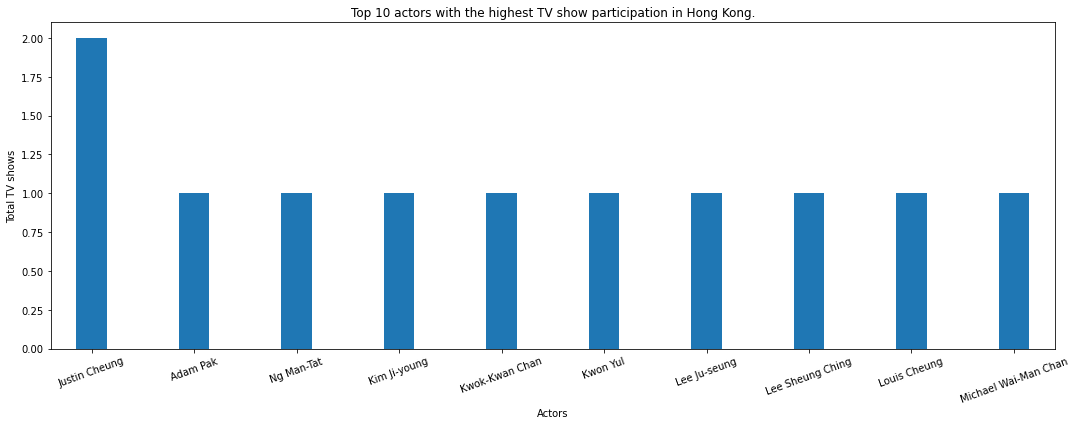

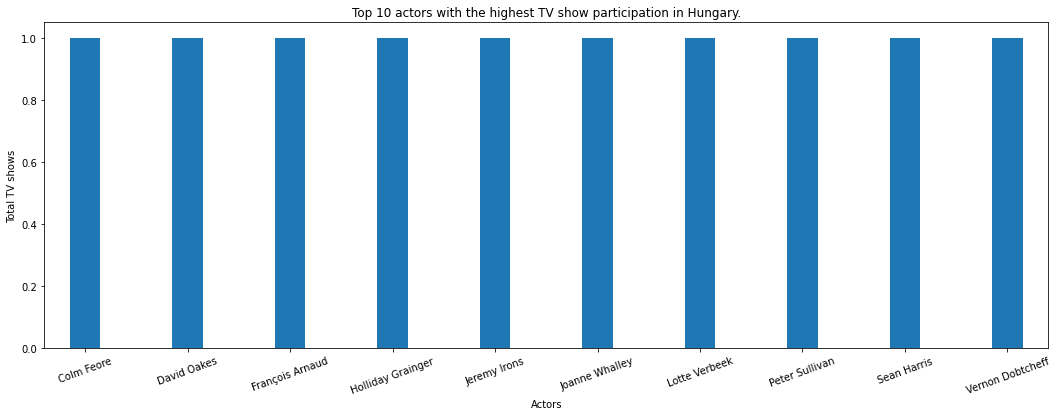

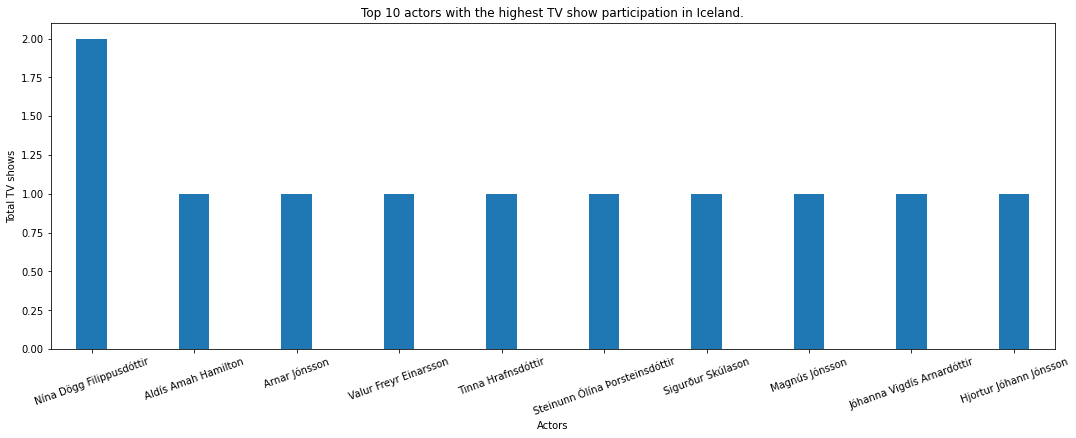

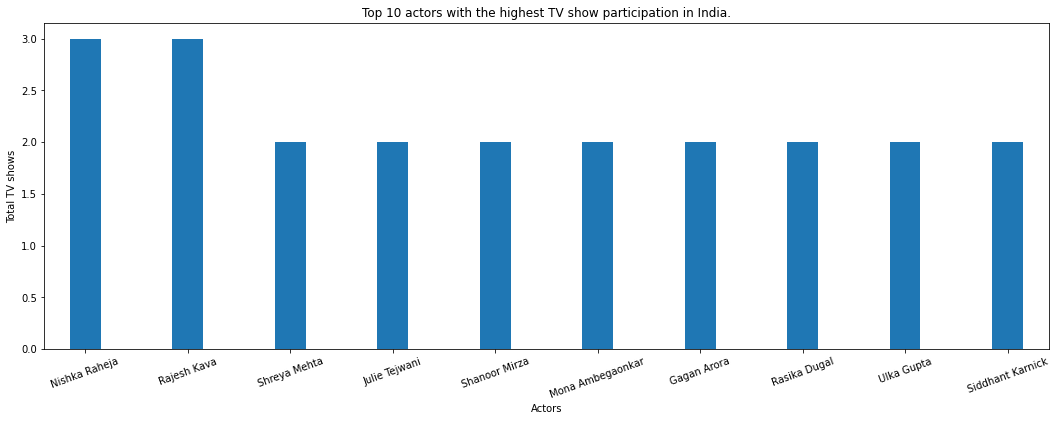

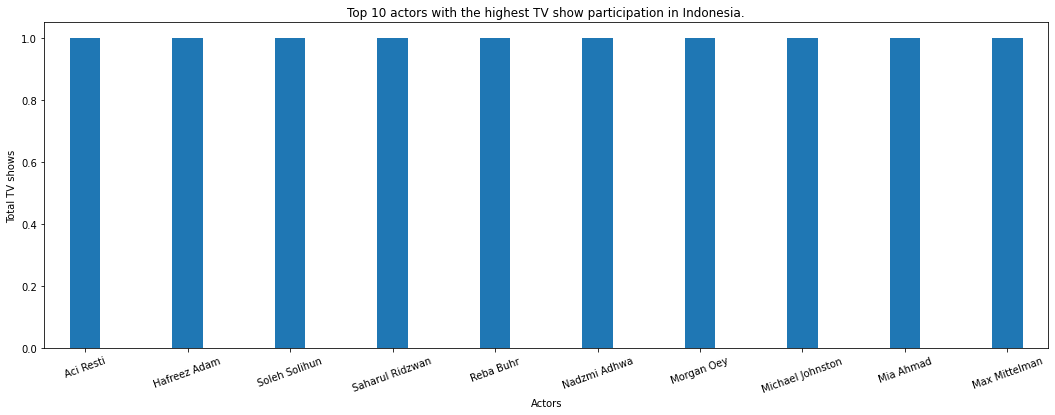

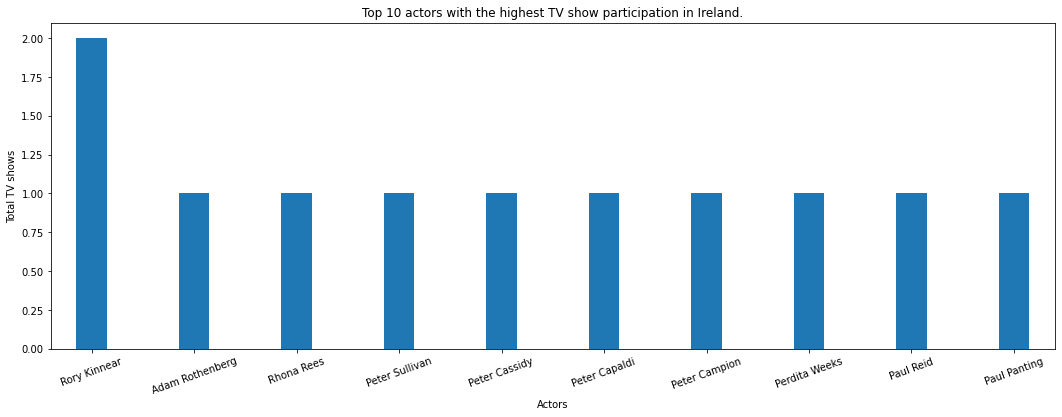

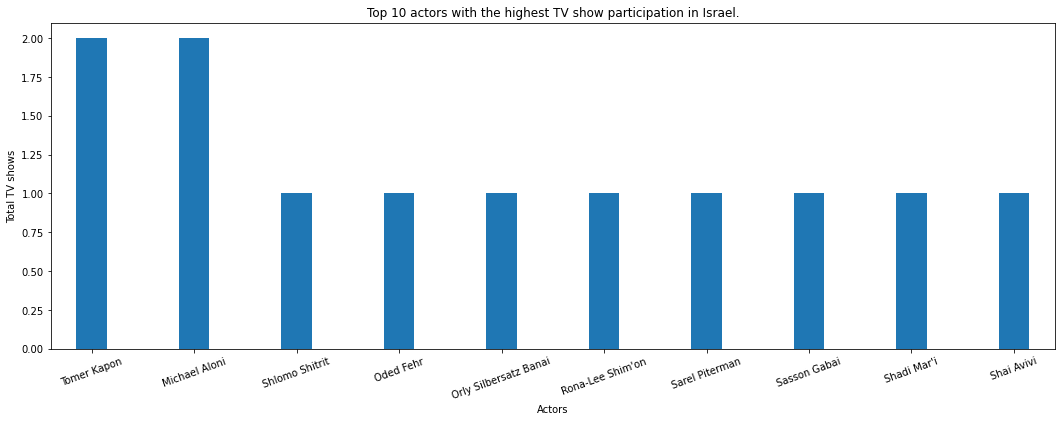

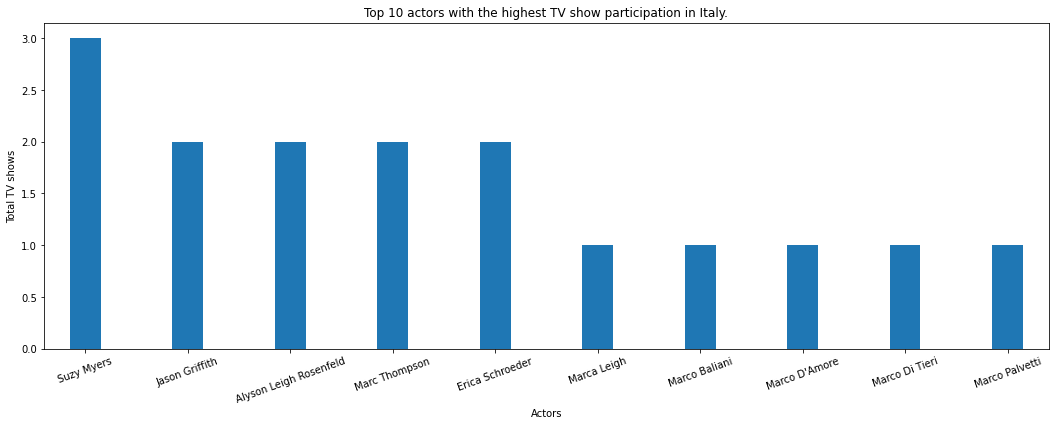

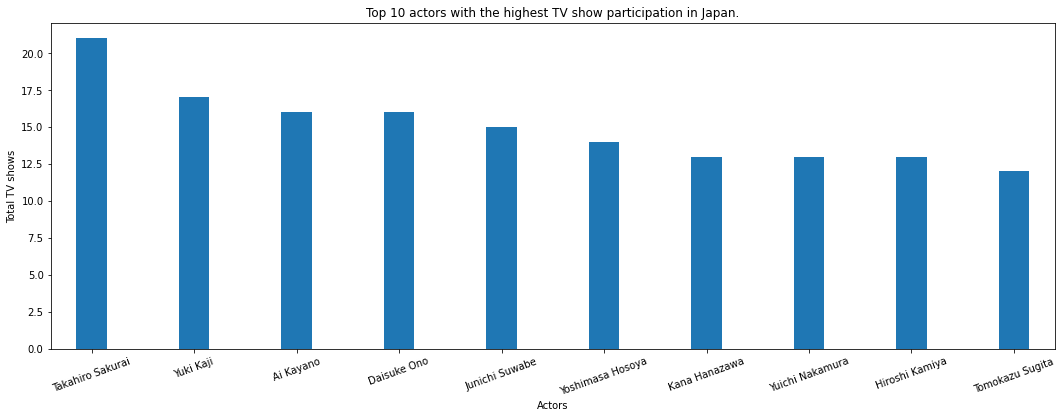

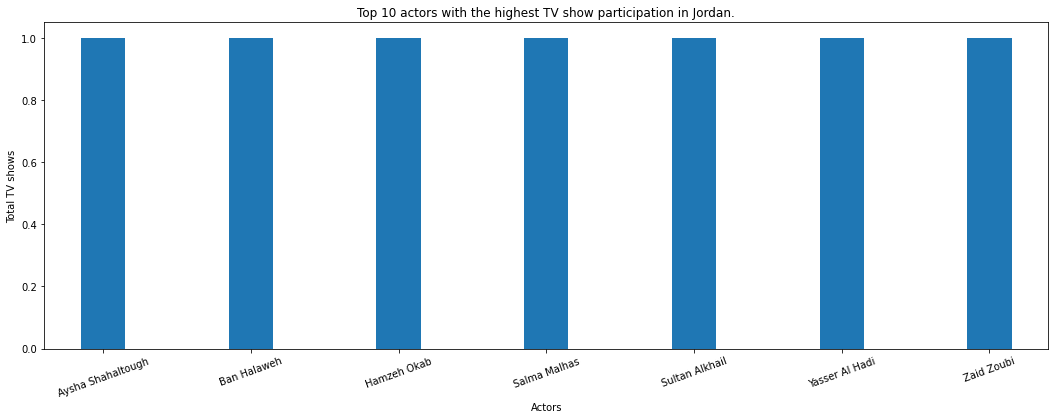

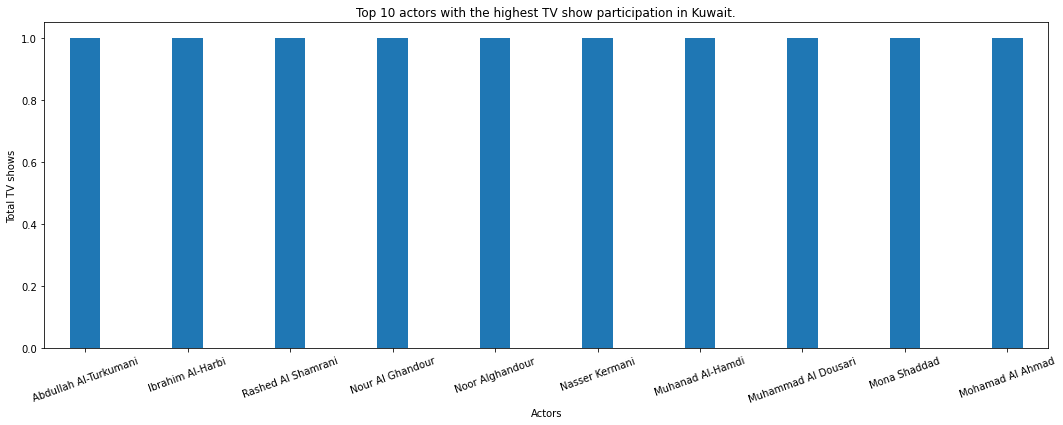

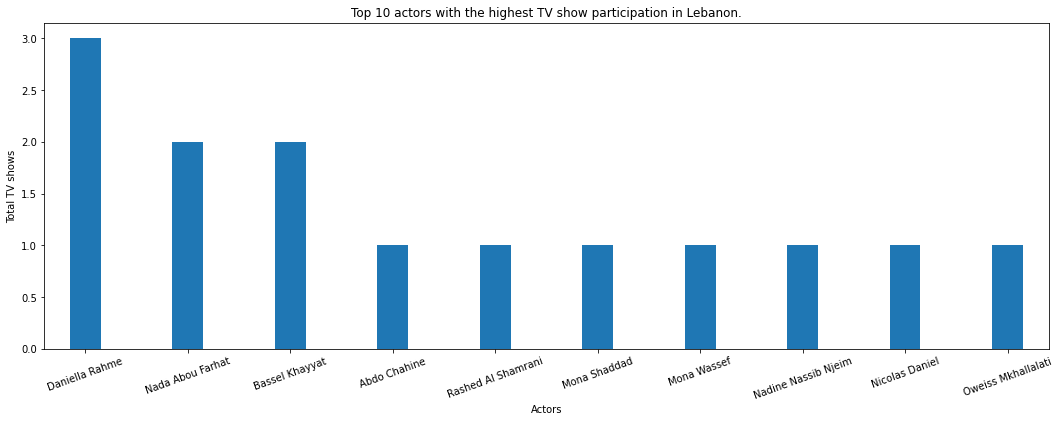

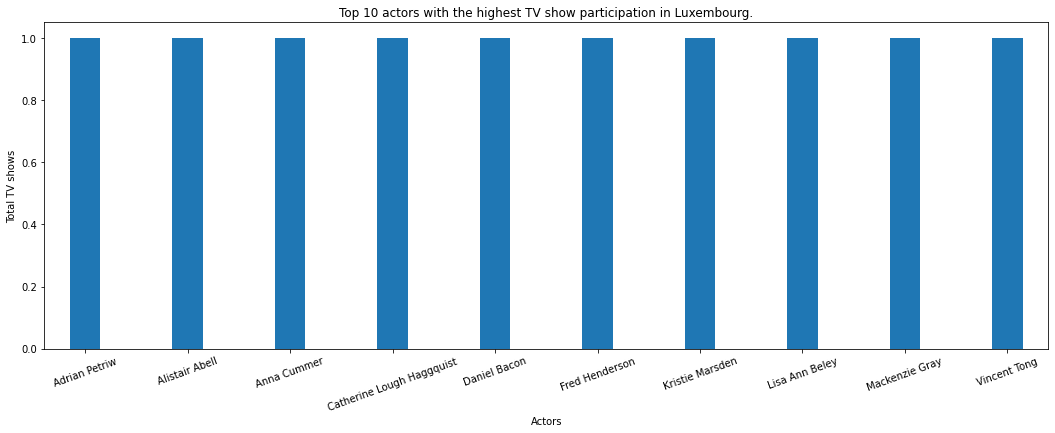

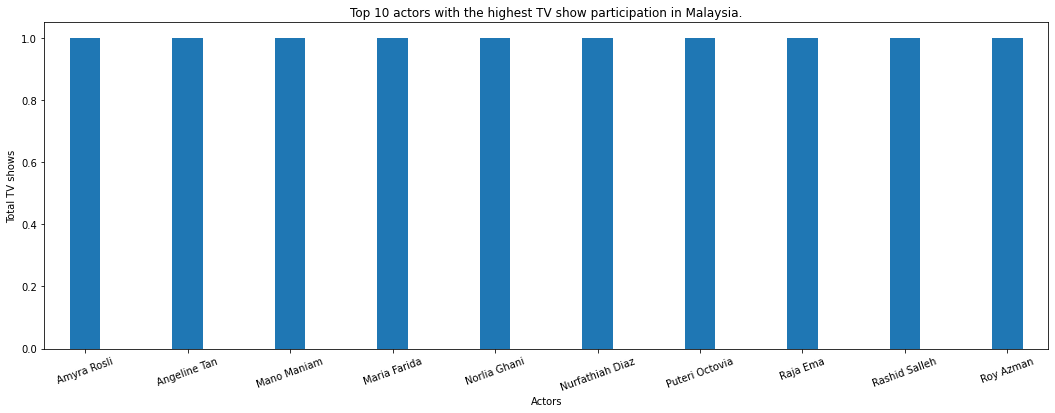

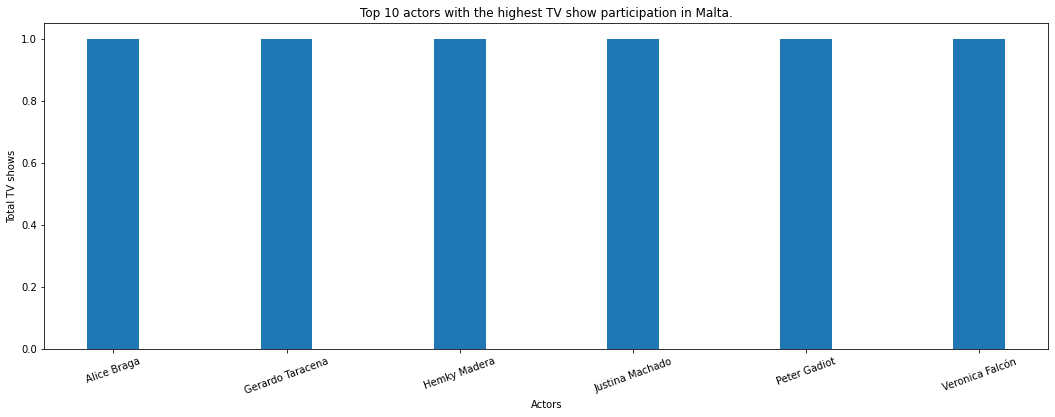

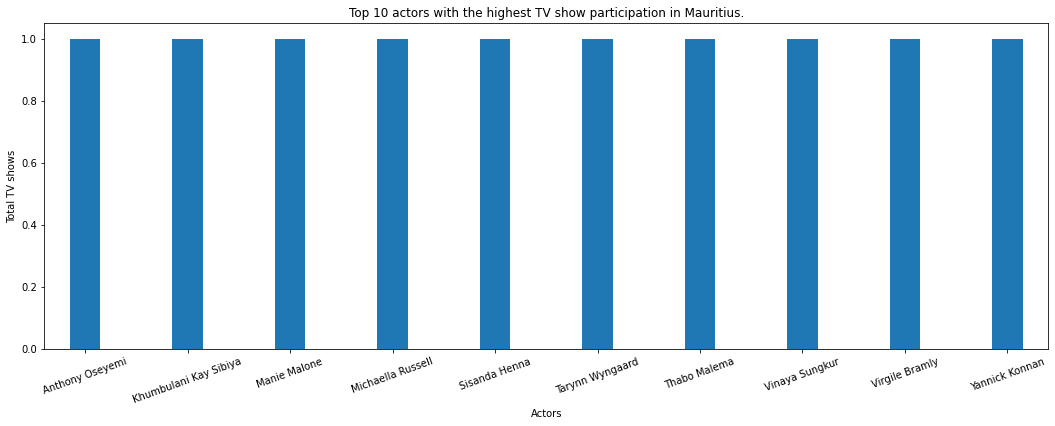

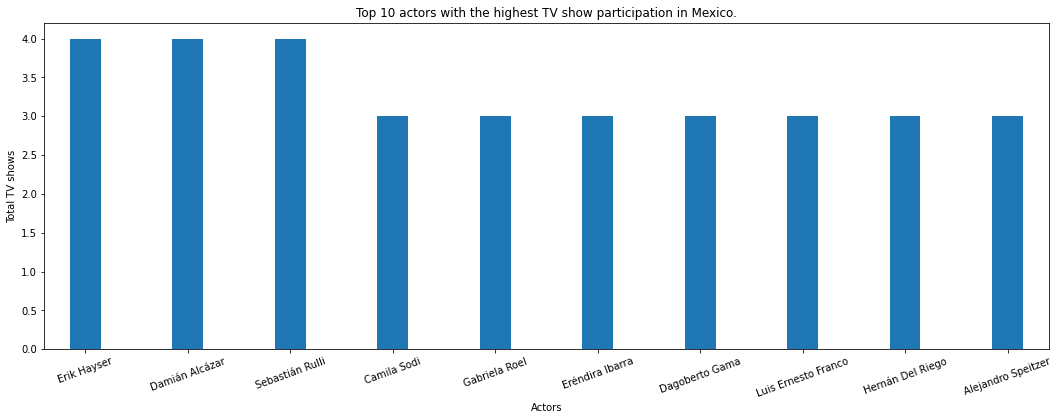

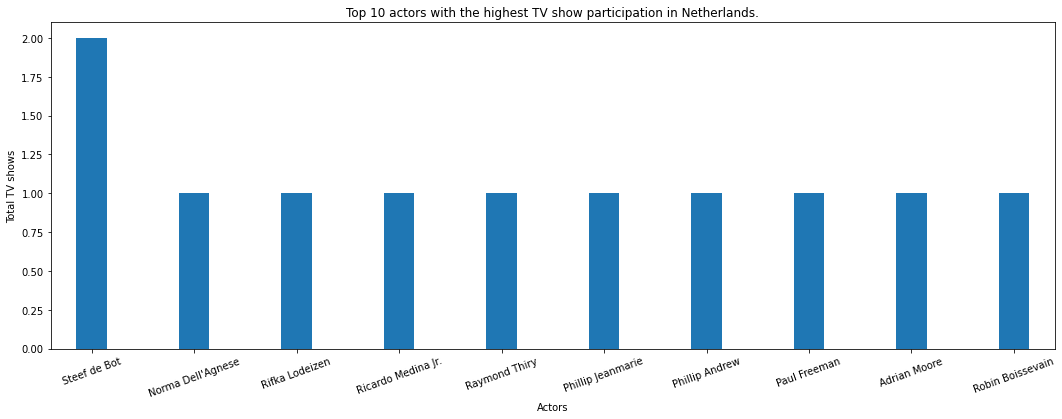

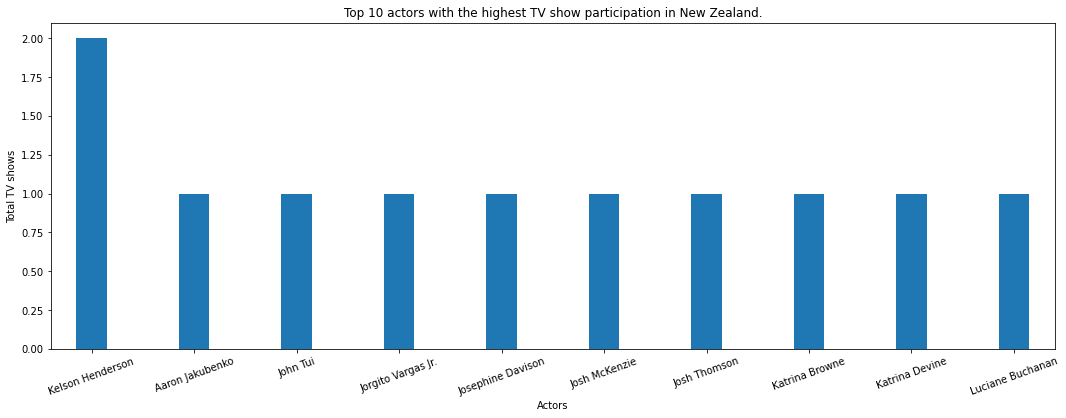

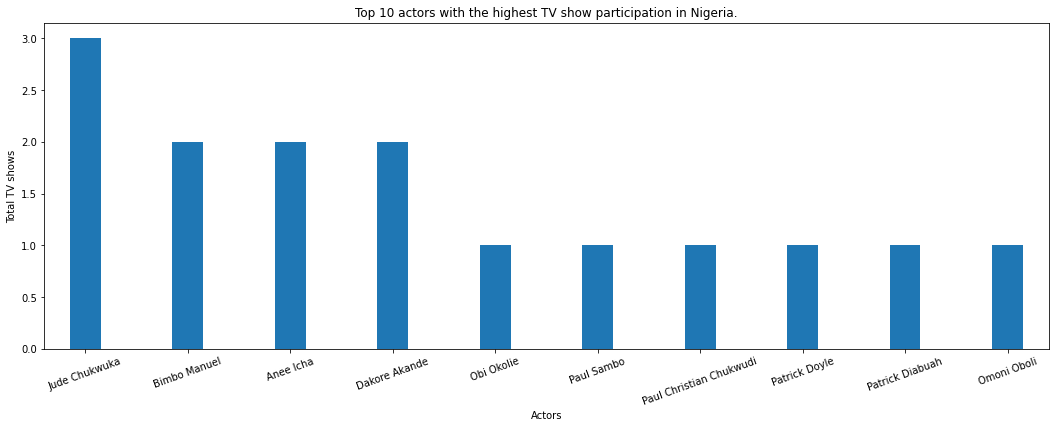

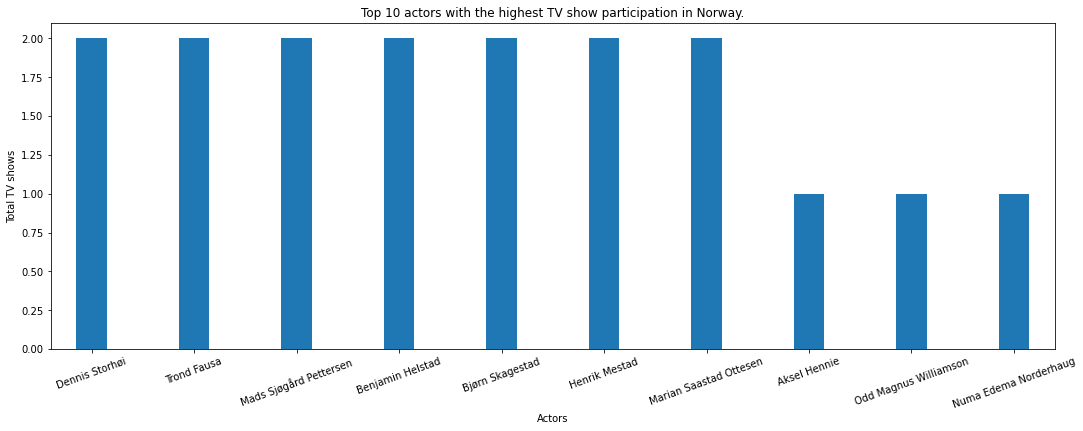

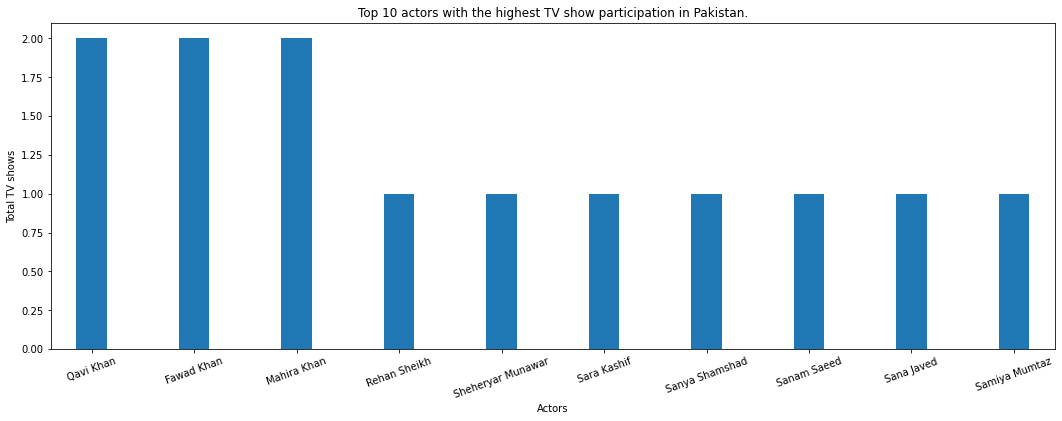

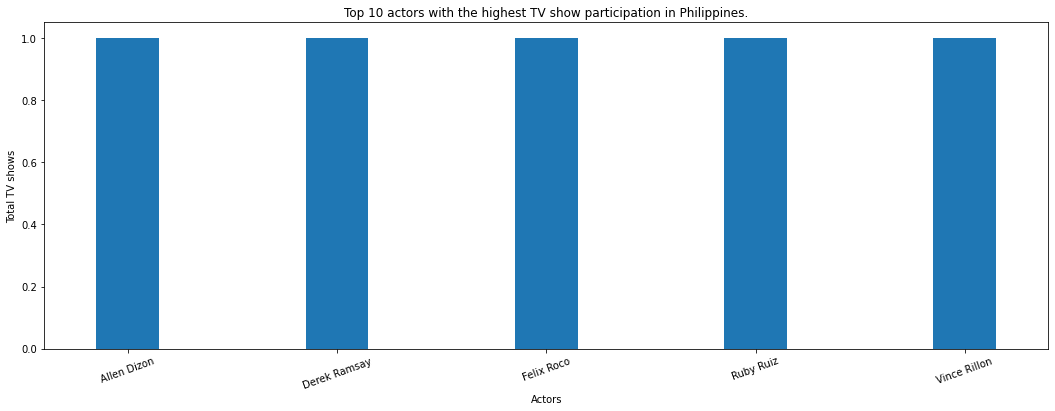

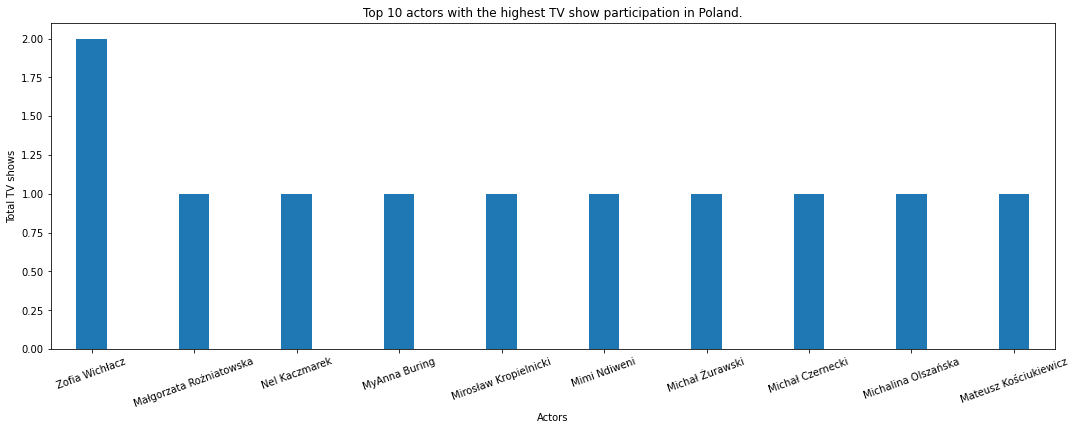

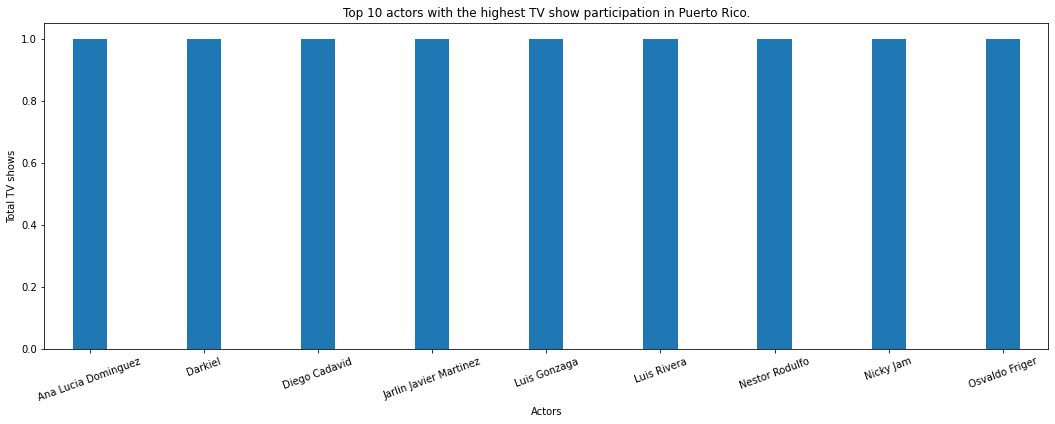

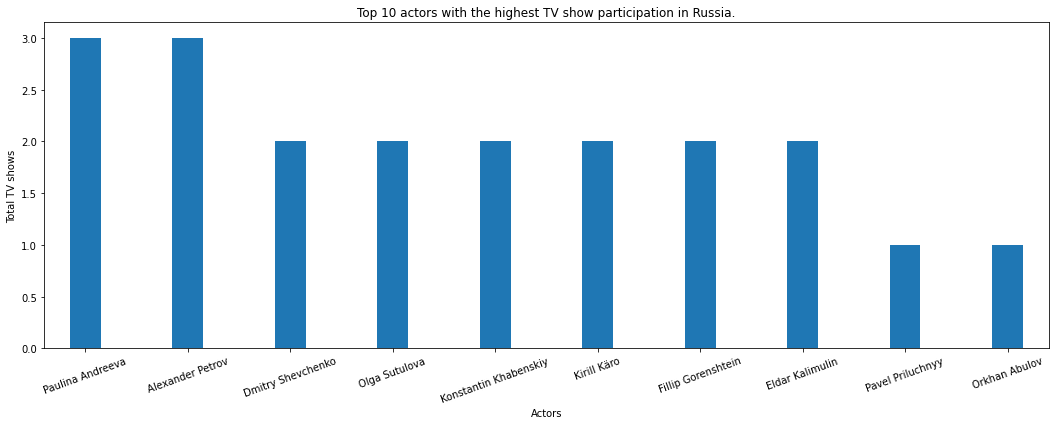

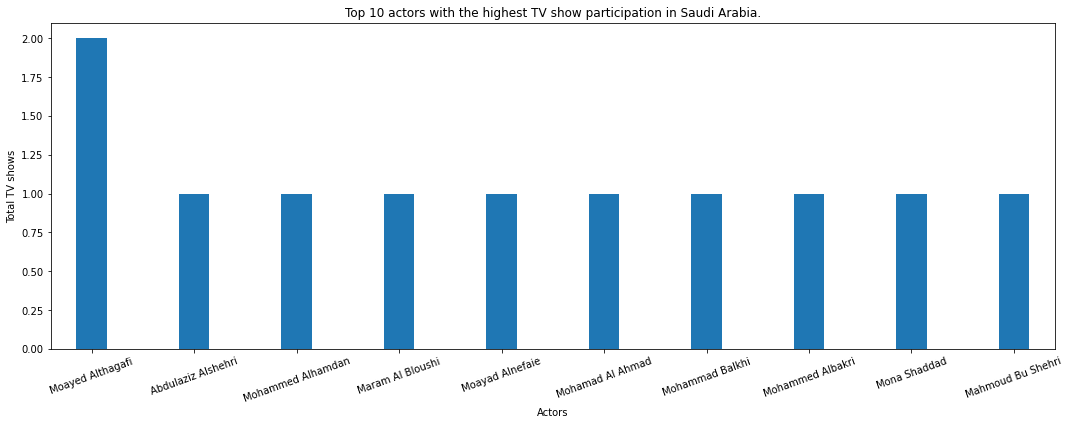

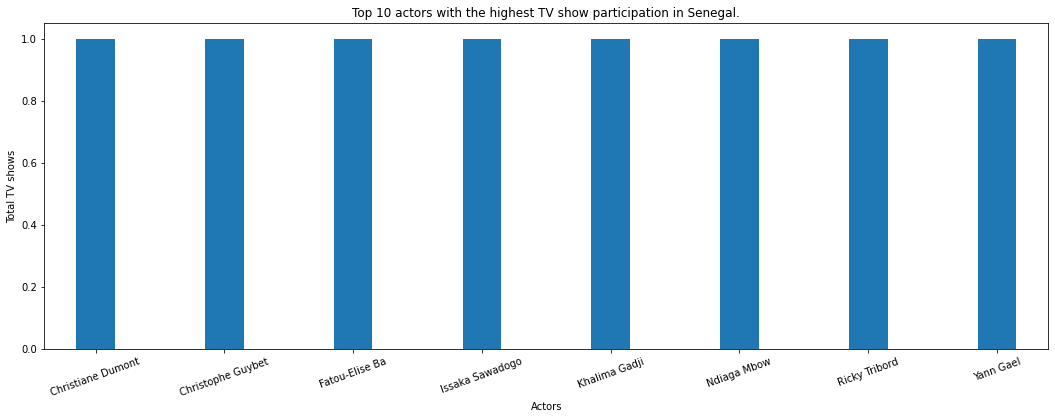

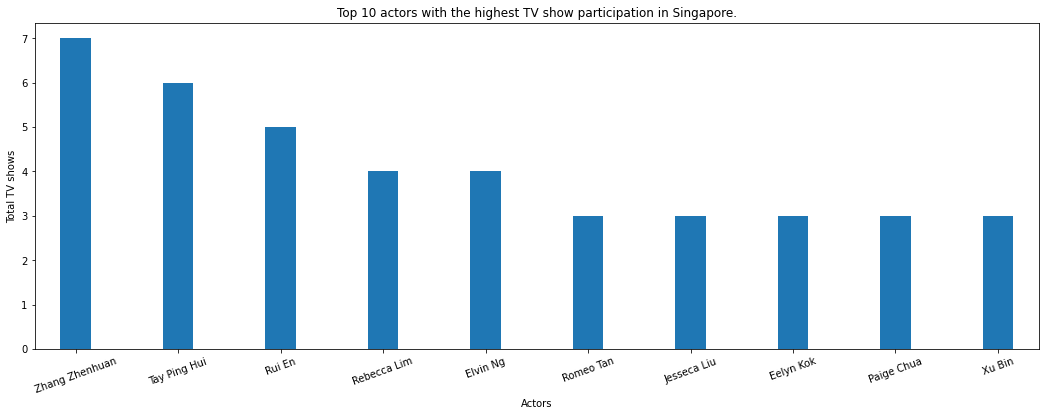

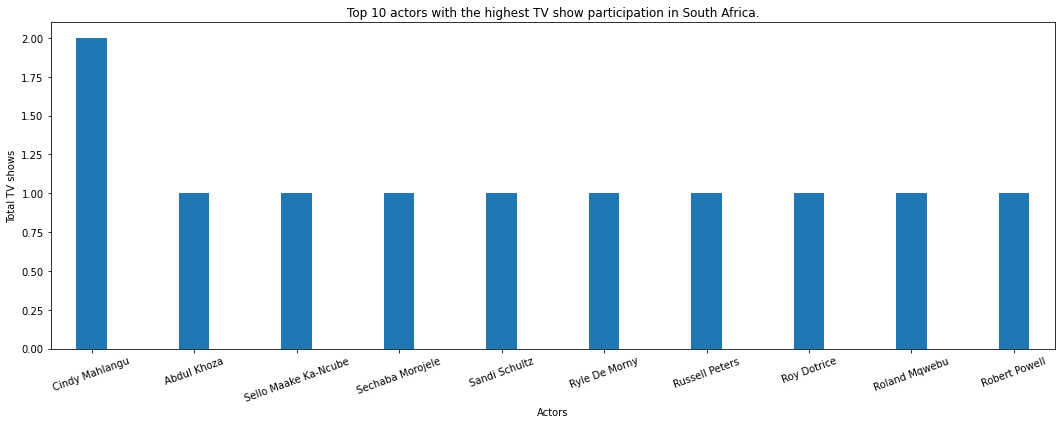

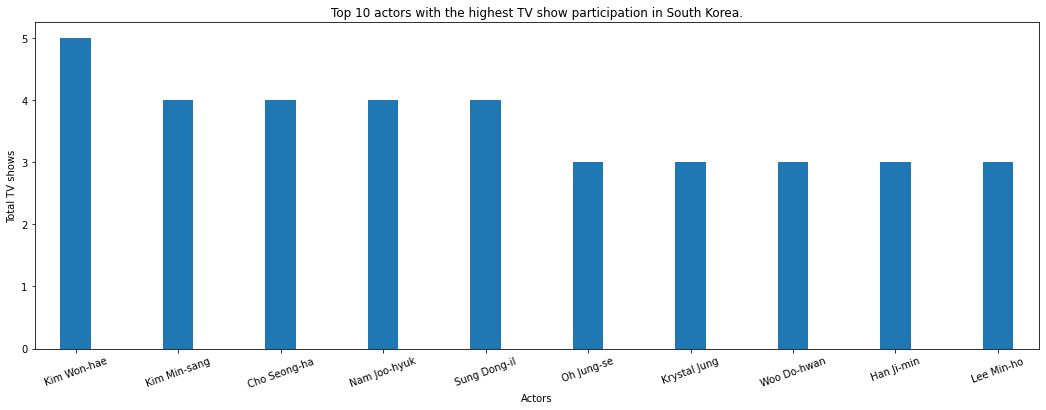

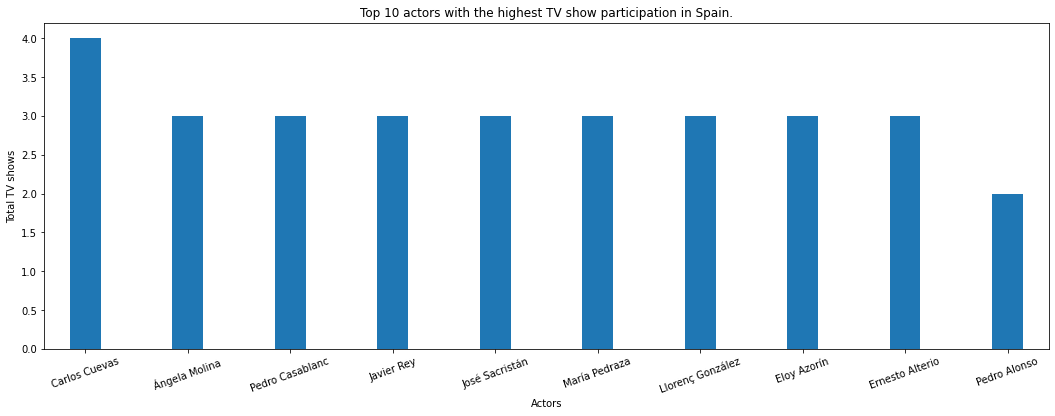

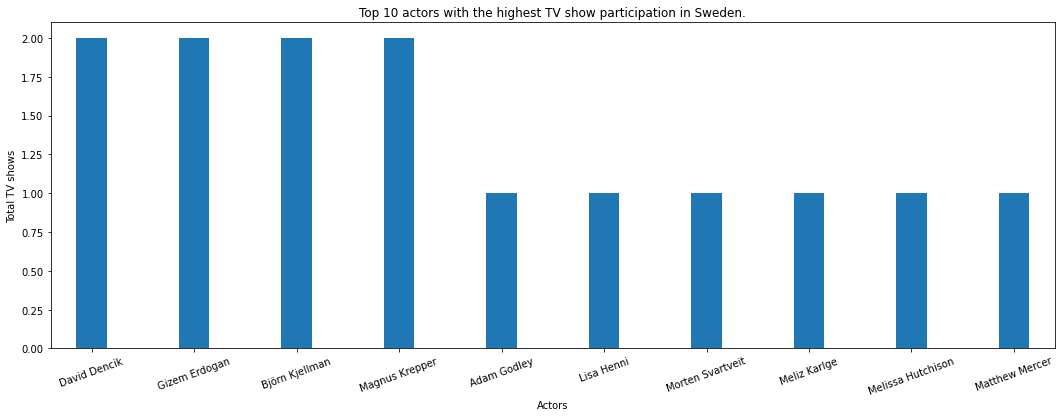

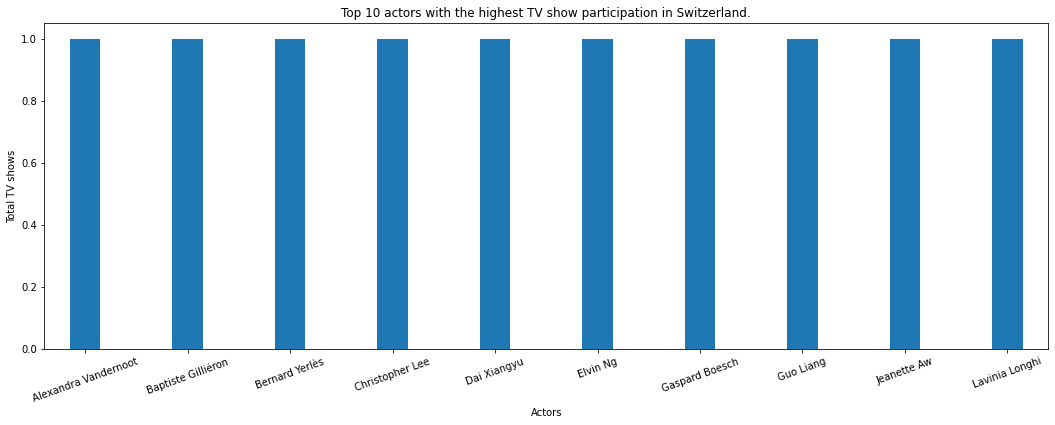

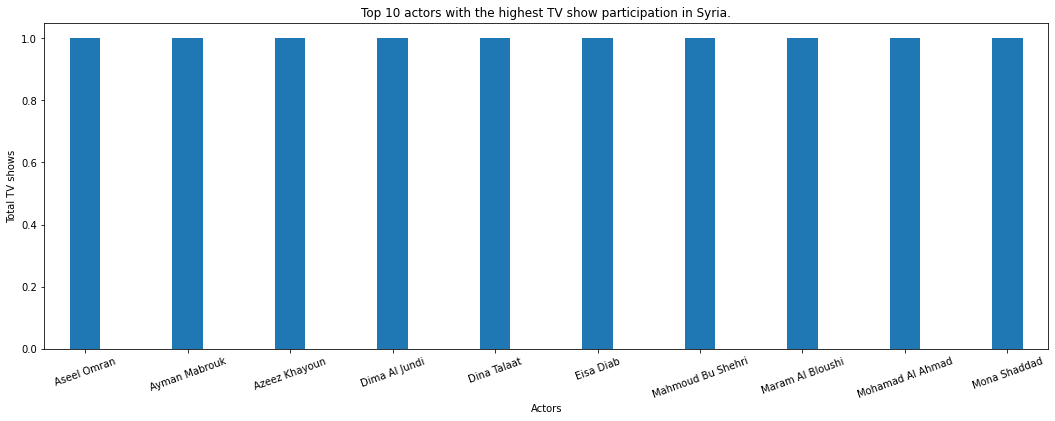

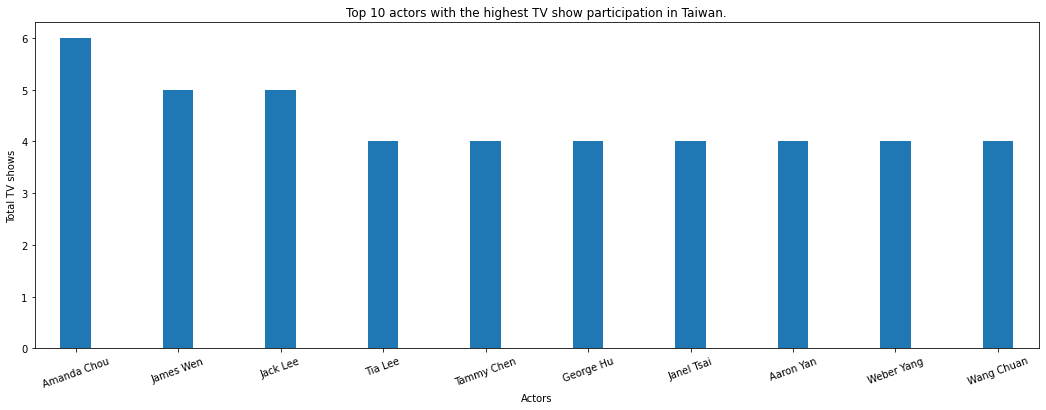

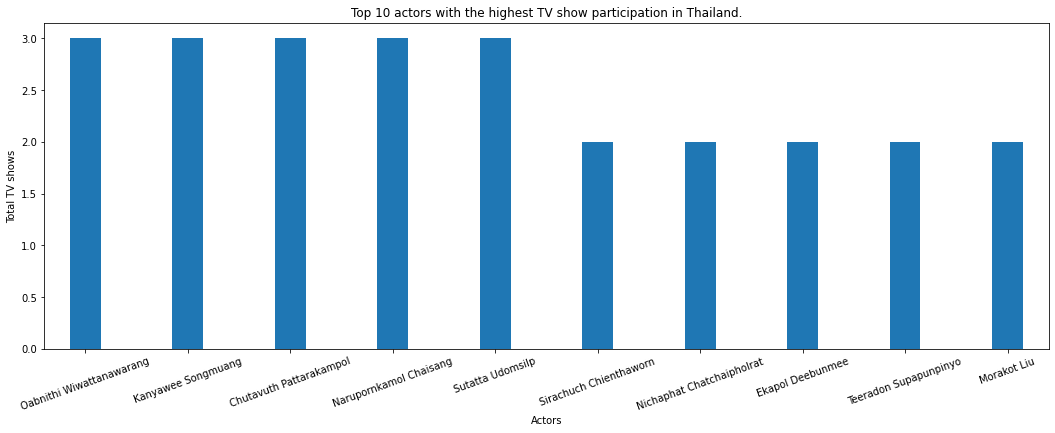

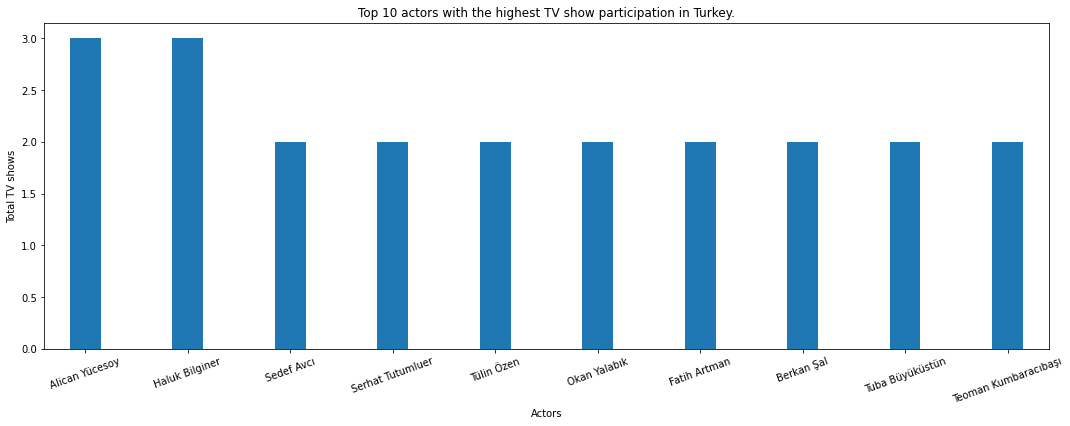

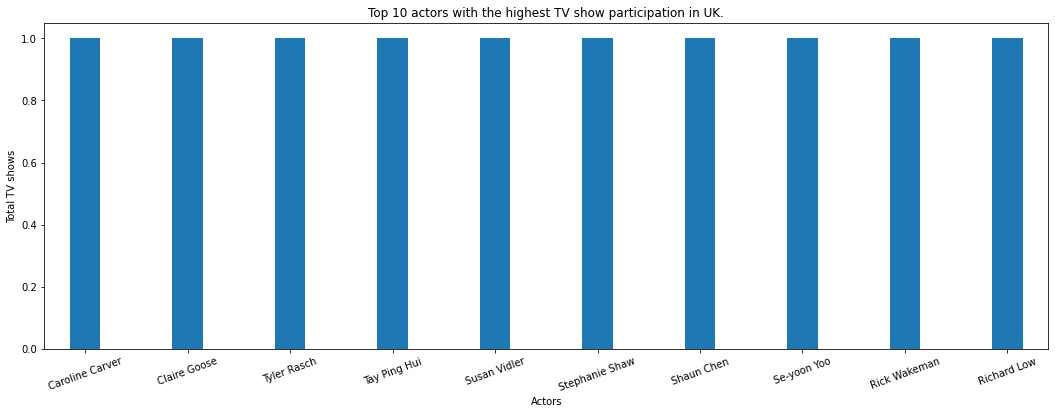

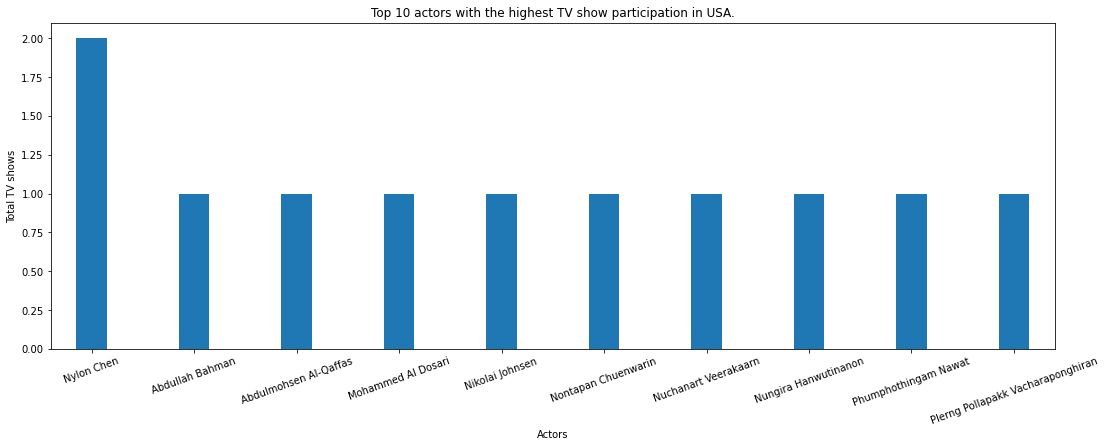

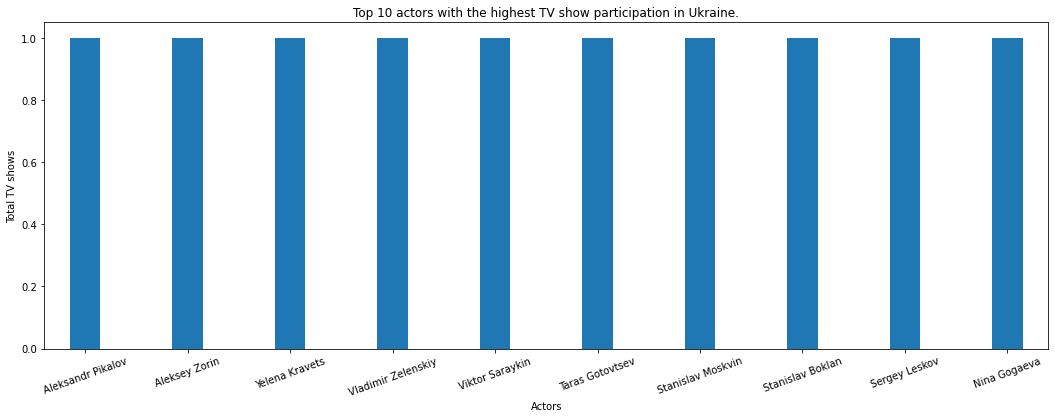

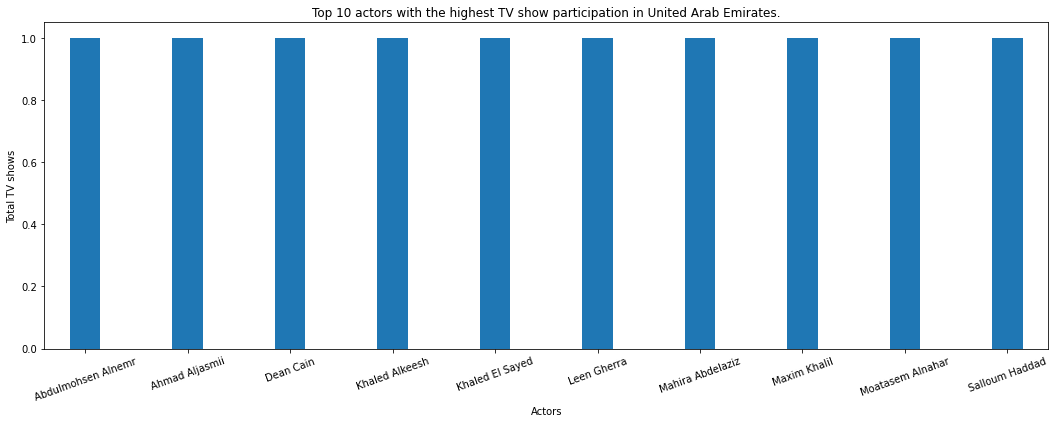

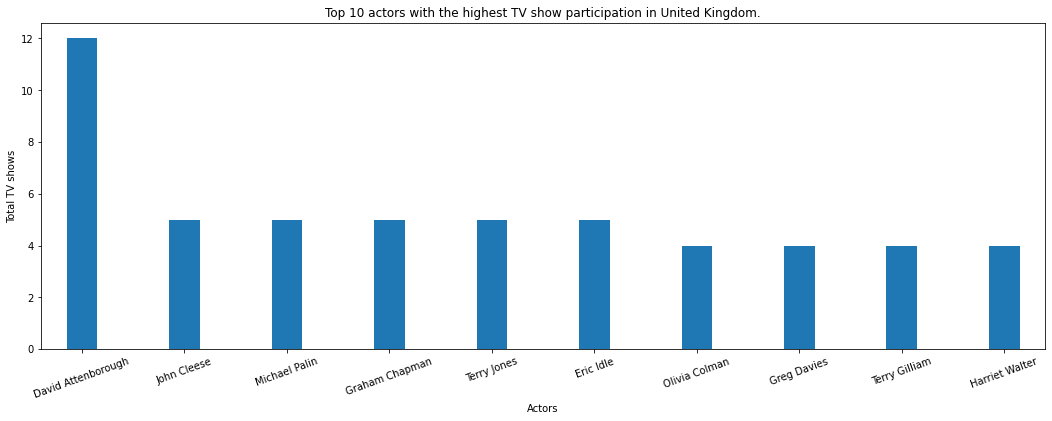

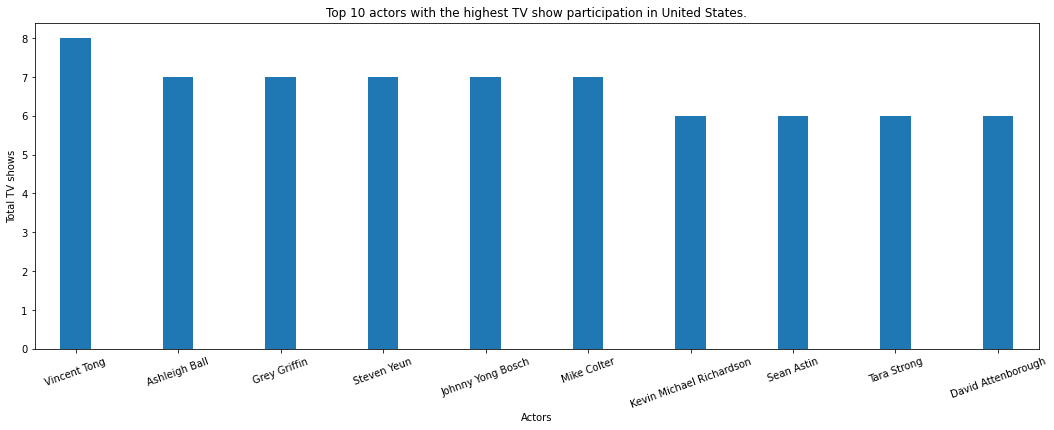

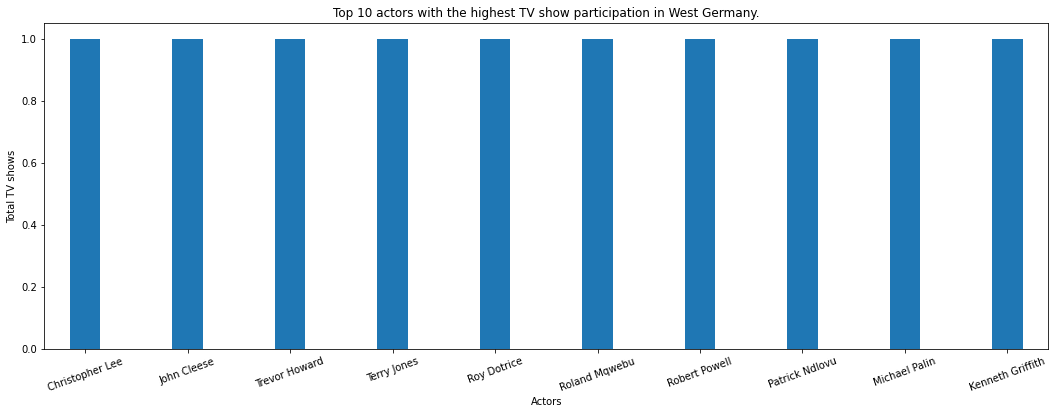

In [ ]:
'''
Utility function that:
> Explodes a specific column's fields to multiple individual rows
> Cleans any whitespace and '\n' from a specific column's fields  
'''
def clean_explode(df, column):
    df[column] = df[column].str.strip().str.split(',')
    df = df.explode(column)
    df[column] = df[column].apply(lambda x: str(x).strip())
    df = df.reset_index(drop=True)
    return df

'''
Computes and plots the actors that took place to the most productions 
(movies and tv shows seperately) in every dataset's existing country
'''
def actors_per_country(info, ptype='movie'):

    # Explode properly all the necessary fields
    info = clean_explode(info, 'cast')
    info = clean_explode(info, 'country')
    
    # Group by country and cast and count all the productions 
    results = pd.DataFrame(info.groupby(by=['country', 'cast']).count()).reset_index()
    results.columns = ['country', 'actors', 'num_of_mov_part']

    # More data cleaning
    results = results.replace(to_replace='', value=float('NaN'))
    results.dropna(inplace=True)

    # For every unique country
    countries = {}
    for country in results['country'].unique():
        if country not in countries:
            countries[country] = 1

            # Create a new dataframe consisting of all the current country's 
            # actors and their summed up productions
            country_df = pd.DataFrame(results[results['country'] == country])
            country_df = country_df.sort_values(by='num_of_mov_part', ascending=False)
            
            # Plot the results (top N)
            topn = 10
            country_df.head(topn).plot(x='actors', y='num_of_mov_part', kind='bar', width=0.3, xlabel='Actors', legend=False,
                    ylabel=f'Total {ptype}s', title=f'Top {topn} actors with the highest {ptype} participation in {country}.', figsize=[18, 6])         

            plt.xticks(rotation=20)
            plt.show()

# Extract only the desired columns
info = nx_df[['type', 'country', 'cast', 'show_id']]
# Drop NaNs
info.dropna(inplace=True)
info = info.reset_index(drop=True)

# Divide the initial dataset into two seperate ones (Movies and TV Shows)
info_mov = info[info['type'] == 'Movie'].reset_index(drop=True)
info_tv = info[info['type'] == 'TV Show'].reset_index(drop=True)

actors_per_country(info_mov.drop(columns='type'))
actors_per_country(info_tv.drop(columns='type'), 'TV show')

### Ερώτημα 6.

*Το netflix υποστηρίζει ότι παρέχει πλούσιο περιεχόμενο για όλες τις ηλικίες.
Αληθεύει αυτό; Φτιάξτε ένα γράφημα το οποίο συγκεντρώνει το πλήθος των
ταινιων ανάλογα με την προτεινόμενη ηλικία (αναφερόμαστε στη στήλη rating). Τα
όρια καθορίζονται σύμφωνα με τον παρακάτω [πίνακα](http://users.uoa.gr/~sdi1800105/tede/hw1/age_array.png). Κάντε το ίδιο γράφημα και
για τις σειρές.*


In [ ]:
def map_rating_to_age(rating):
  ages = { 'Little Kids' : ['G', 'TV-Y', 'TV-G'],
           'Older Kids' : ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG'],
           'Teens' : ['PG-13', 'TV-14'],
           'Mature' : ['R', 'NC-17', 'TV-MA'] }
  for age in ages.keys():
    if rating in ages[age]:
      return age
  return ''

def get_info6(nx_df, title):
  info = nx_df[['type', 'rating']].where(nx_df['type'] == title).dropna()
  # Create new rows, each having exactly 1 rating (by splitting multi-rating productions)
  info['rating'] = info['rating'].str.strip().str.split(',')
  info = info.explode('rating')
  # Convert ratings to Group Age (Little Kids, Teens, etc)
  info['rating'] = info.apply(lambda row : map_rating_to_age(row.rating), axis=1)
  # Rule out Ratings that don't have a match to a Group Age based on the age array
  info = info[ info['rating'] != '' ]
  info = info.groupby(by=['rating']).count().reset_index()
  info = info.rename({'type' : (title + 's'), 'rating' : 'Rating'}, axis=1)
  info = info.sort_values(by=[title + 's'], ascending=False).set_index('Rating')
  return info

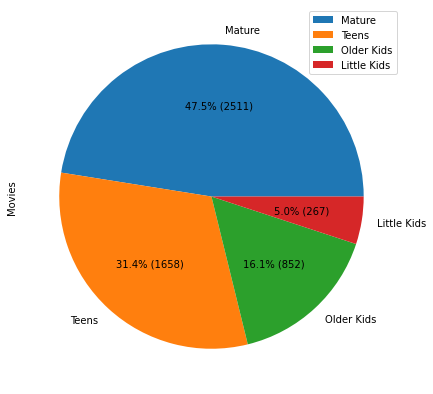

In [ ]:
def rating_among_movies():
  movie_info = get_info6(nx_df, 'Movie')
  total_movies = movie_info['Movies'].sum()
  movie_info.plot(kind = 'pie', subplots=True, figsize = (7, 7), 
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_movies))
  plt.show()

rating_among_movies()

Με βάση το Dataset που μελετάμε, παρατηρούμε ότι ο ισχυρισμός του Netflix δεν αληθεύει. Συγκεκριμένα, παρατηρούμε ότι η πλειοψηφία των ταινιών αφορούν **Mature** κοινό, έπεται η ηλικία των **Teens** και ακολουθούν **Older Kids** και **Little Kids**, με μεγάλη διαφορά όμως από τις 2 πρώτες ηλικιακές ομάδες. Παρατηρούμε ότι ο αριθμός των ταινιών που παρέχεται δεν είναι ισομοιρασμένος ανάμεσα στις ηλικιακές ομάδες, αλλά κλιμακώνεται ανάλογα με την ηλικία, υπερ των μεγαλύτερων.

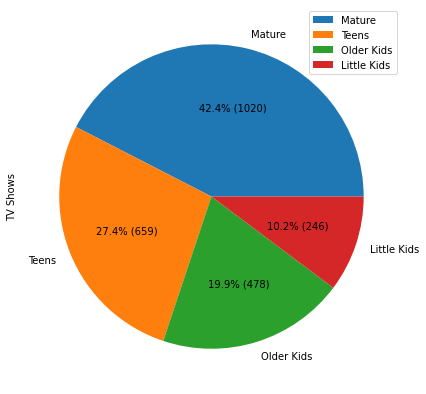

In [ ]:
def rating_among_shows():
  show_info = get_info6(nx_df, 'TV Show')
  total_series = show_info['TV Shows'].sum()
  show_info.plot(kind = 'pie', subplots=True, figsize = (7, 7), 
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_series))
  plt.show()

rating_among_shows()

Μελετώντας τις σειρές του Netflix, εξάγουμε παρόμοια συμπεράσματα με την κατανομή των ταινιών στις ηλικιακές ομάδες. Παρατηρούμε, ωστόσο, ότι η διαφορά ανάμεσα στις ηλικιακές ομάδες είναι μικρότερη από την αντίστοιχη των ταινιών. Δηλαδή, υπάρχουν (ποσοστιαία) περισσότερες σειρές για τις "μικρότερες" ηλικίες απ' ότι ταινίες.

### Ερώτημα 7.
*Αν ένας παραγωγός ήθελε να έχει υψηλή ακροαματικότητα, σκέφτεται ότι θα ήταν
ίσως καλύτερα να βγάλει την ταινία του σε μία εποχή που δεν υπάρχει
ανταγωνισμός. Κάντε ένα γράφημα με το περιεχόμενο που προστίθεται ανά μήνα
για να τον βοηθήσετε να επιλέξει τη σωστή χρονική περίοδο.*

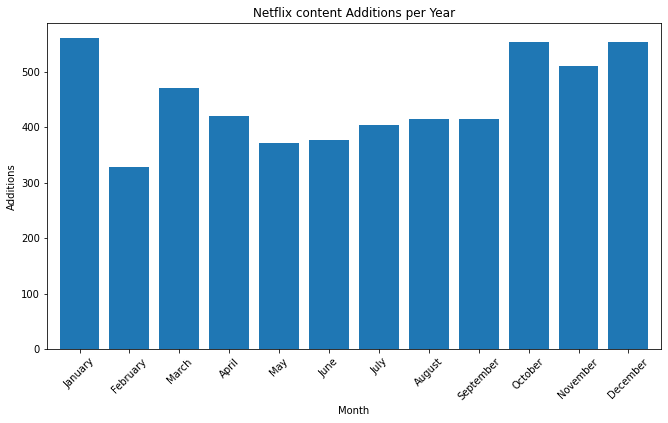

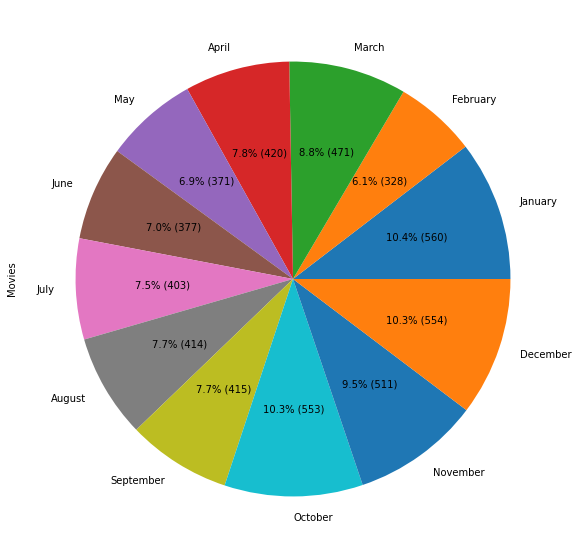

In [ ]:
def get_info7(nx_df, title):  # title is either 'Movie' or 'TV Show'
  # Get titles and date added
  info = nx_df[['type', 'date_added']].where(nx_df['type'] == title).dropna()
  # Replace 'date_added' field with *month* added
  info['date_added'] = info.apply(lambda row : str(row.date_added).split()[0], axis=1)
  info = info.groupby(by=['date_added']).count().reset_index()
  info.rename({'type' : (title +'s')}, axis=1, inplace=True)
  # Convert 'date_added' to Categorical column so we can sort by month
  info['date_added'] = pd.Categorical(info['date_added'], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
  info = info.sort_values('date_added').set_index('date_added')
  return info


def content_additions_per_month():
  movie_info = get_info7(nx_df, 'Movie')
  movie_info.plot(kind='bar', legend=False, width=0.8, xlabel='Month',
              ylabel='Additions', title='Netflix content Additions per Year', figsize = (11, 6))
  plt.xticks(rotation=45)
  plt.show()
  print()
  total_movies = movie_info['Movies'].sum()
  movie_info.plot(kind = 'pie', subplots=True, figsize = (10, 10), legend=False,
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_movies))
  plt.show()

content_additions_per_month()

Παρατηρούμε ότι το περισσότερο περιεχόμενο προστίθεται στο διάστημα Οκτώβριος-Ιανουάριος (10% των ταινιών κάθε μήνα), ενώ το λιγότερο παρατηρείται τον Φεβρουάριο (6.1%) και ακολουθεί ο Μάιος (6.9%). Συνεπώς, θα ήταν προτιμότερο για τον παραγωγό να βγάλει την ταινία του στο Netflix τον Φεβρουάριο.

### Ερώτημα 8.
*Ετοιμάστε ένα γράφημα που παρουσιάζει συγκεντρωτικά τα είδη του περιεχομένου
(αναφερόμαστε στη στήλη listed_in).*


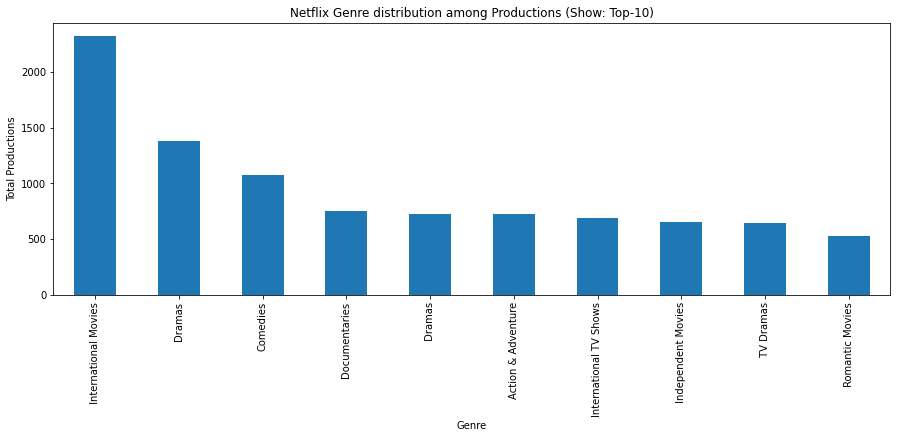

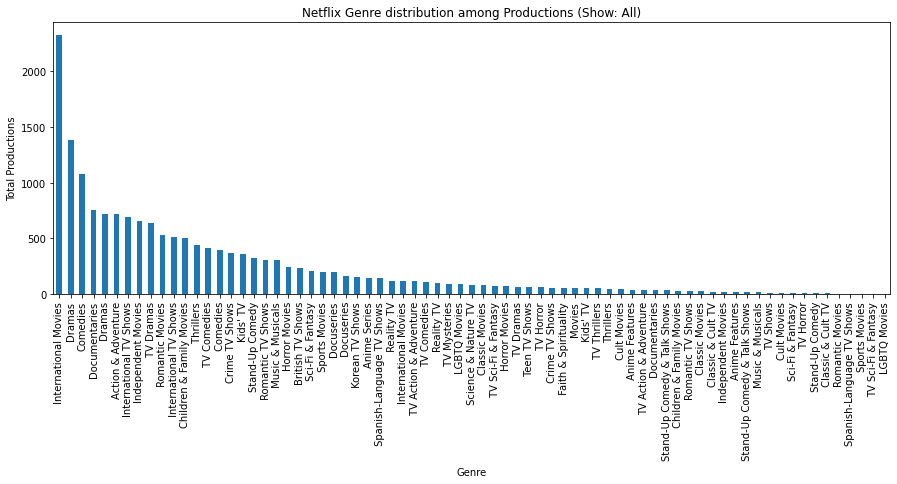

In [ ]:
def get_genre_stats(topk = 8):
  genre_info = nx_df[['listed_in']].dropna().rename({'listed_in' : 'Genre'}, axis=1)
  # Create new rows, each having exactly 1 genre (by splitting multi-genre productions)
  genre_info['Genre'] = genre_info['Genre'].str.strip().str.split(',')
  genre_info = genre_info.explode('Genre')
  genre_info = genre_info.explode('Genre').reset_index()
  genre_info = genre_info.groupby(by=['Genre']).count()
  genre_info.rename({'index' : 'Count'}, axis=1, inplace=True)
  genre_info = genre_info.sort_values(by=['Count'], ascending=False)

  def plot_topk_genre(info, topk):
    desc = f'(Show: Top-{topk})'
    if topk == len(genre_info.index):
      desc = '(Show: All)'
    genre_info.head(topk).plot(kind='bar', width=0.5, xlabel='Genre', legend=False, figsize = (15,5),
                          ylabel='Total Productions', title=f'Netflix Genre distribution among Productions {desc}')
    plt.show()
    print()

  plot_topk_genre(genre_info, topk)
  plot_topk_genre(genre_info, genre_info.size)

get_genre_stats(topk = 10)

Παρατηρούμε ότι το είδος με το περισσότερο περιεχόμενο (με διαφορά σχεδόν 1000 παραγωγών από το 2ο) είναι το **International Movies**, ενδεικτικό ίσως της διάδοσης και χρήσης του Netflix σε παγκόσμιο επίπεδο. 

### Ερώτημα 9.
*Μελετηστε τους σκηνοθέτες ανά χώρα και παρουσιάστε σχετικά γραφήματα.*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

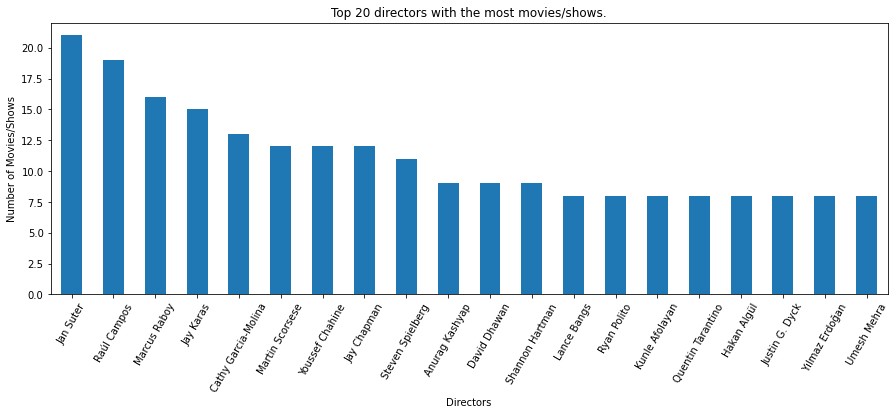

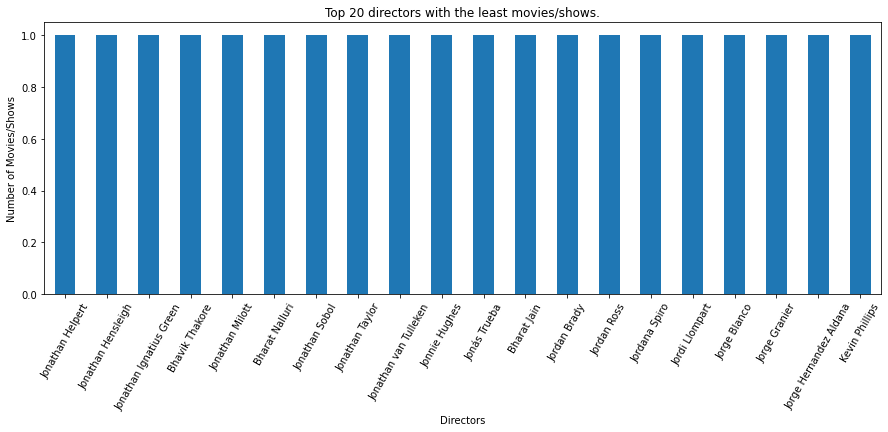

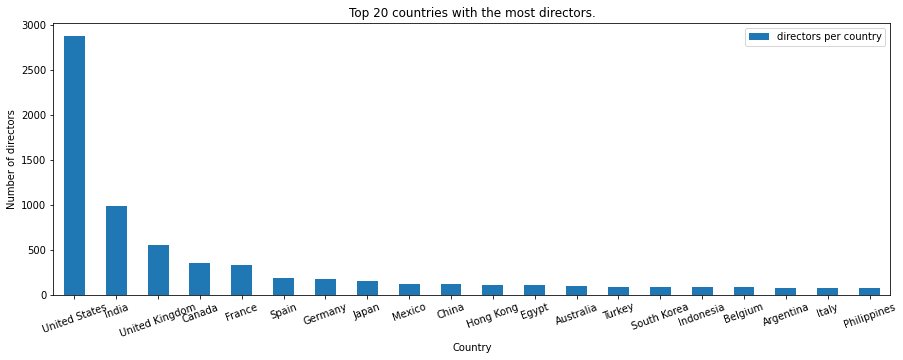

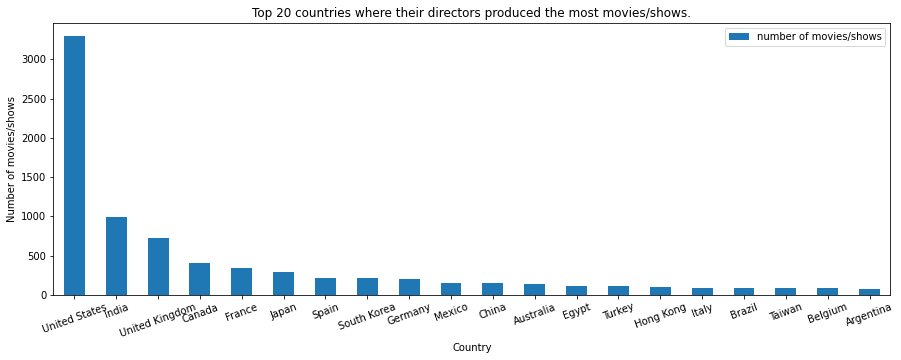

In [ ]:
'''
Utility function that:
> Explodes a specific column's fields to multiple individual rows
> Cleans any whitespace and '\n' from a specific column's fields  
'''
def clean_explode(df, column):
    df[column] = df[column].str.strip().str.split(',')
    df = df.explode(column)
    df[column] = df[column].apply(lambda x: str(x).strip())
    df = df.reset_index(drop=True)
    return df

top_n = 20
# Select only the directors and the show ids
directors = nx_df[['director', 'show_id']]
# Cleanup
directors.dropna(inplace=True)
directors = directors.reset_index(drop=True)

directors = clean_explode(directors, 'director')
# Count for each director, the number of shows he has produced
directors = pd.DataFrame(directors.groupby(by=['director']).count()).reset_index()
directors.columns = ['director', 'count']
directors.sort_values(by='count', ascending=False, inplace=True)

# Plot top N results
directors.head(top_n).plot(x='director', y='count', kind='bar', xlabel='Directors', ylabel='Number of Movies/Shows', 
                           figsize=[15, 5], legend=False, title=f'Top {top_n} directors with the most movies/shows.')

plt.xticks(rotation = 60)

directors.tail(top_n).plot(x='director', y='count', kind='bar', xlabel='Directors', ylabel='Number of Movies/Shows', 
                           figsize=[15, 5], legend=False, title=f'Top {top_n} directors with the least movies/shows.')

plt.xticks(rotation = 60)

# Select only the directors and the countries
dir_per_countr = nx_df[['country', 'director']]
# Cleanup
dir_per_countr.dropna(inplace=True)
dir_per_countr.reset_index(drop=True, inplace=True)

dir_per_countr = clean_explode(dir_per_countr, 'country')
dir_per_countr = clean_explode(dir_per_countr, 'director')

# Count the number of directors in each country
dir_per_countr = pd.DataFrame(dir_per_countr.groupby(by=['country']).count()).reset_index()
dir_per_countr.columns = ['country', 'directors per country']
# Cleanup
dir_per_countr = dir_per_countr.replace(to_replace='', value=float('NaN'))
dir_per_countr.dropna(inplace=True)
dir_per_countr.sort_values(by='directors per country', ascending=False, inplace=True)

# Plot top N results
dir_per_countr.head(top_n).plot(x='country', y='directors per country', kind='bar', xlabel='Country', ylabel='Number of directors',
        figsize=[15, 5], title=f'Top {top_n} countries with the most directors.')

plt.xticks(rotation=20)

# Collect the total number of movies/shows produced by a specific country's directors
prod_per_dirs = nx_df[['country', 'show_id']]
prod_per_dirs.dropna(inplace=True)
prod_per_dirs.reset_index(drop=True, inplace=True)

prod_per_dirs = clean_explode(prod_per_dirs, 'country')

prod_per_dirs = pd.DataFrame(prod_per_dirs.groupby(by=['country']).count()).reset_index()
prod_per_dirs.columns = ['country', 'number of movies/shows']

prod_per_dirs = prod_per_dirs.replace(to_replace='', value=float('NaN'))
prod_per_dirs.dropna(inplace=True)
prod_per_dirs.sort_values(by='number of movies/shows', ascending=False, inplace=True)

# Plot top N results
prod_per_dirs.head(top_n).plot(x='country', y='number of movies/shows', kind='bar', xlabel='Country', ylabel='Number of movies/shows',
        figsize=[15, 5], title=f'Top {top_n} countries where their directors produced the most movies/shows.')

plt.xticks(rotation=20)

### Ερώτημα 10.
*Μελετήστε τις σειρές και παρουσιάστε ένα γράφημα που τις δείχνει ανάλογα με τον αριθμό των seasons.*

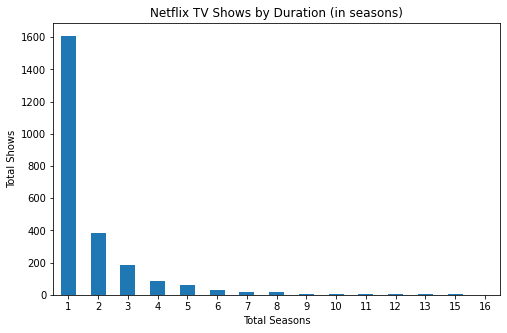

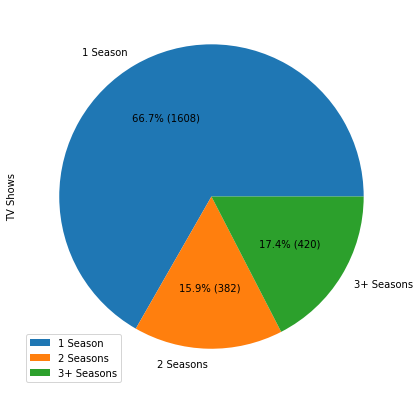

In [ ]:
def categorize_series(duration):
  if duration >= 3:
    return '3+ Seasons'
  sufix = ''
  if duration == 2:
    sufix = 's'
  return str(duration) + ' Season' + sufix
  

def shows_per_seasons():
  show_info = nx_df[['type', 'duration']].where(nx_df['type'] == 'TV Show').dropna()
  # Transform 'duration' to indicate the number (int) of seasons for each show 
  show_info['duration'] = show_info.apply(lambda row : int(str(row.duration).strip().split()[0]), axis=1)
  # Group by the Number of Seasons
  show_info = show_info.groupby(by=['duration']).count()
  show_info = show_info.sort_values(by=['duration'])
  show_info.rename({'type' : 'TV Shows'}, axis=1, inplace=True)
  show_info.plot(kind='bar', width=0.5, xlabel='Total Seasons', legend=False, figsize = (8, 5),
                          ylabel='Total Shows', title='Netflix TV Shows by Duration (in seasons)')
  plt.xticks(rotation=0)
  plt.show()
  print()

  # Exhibit the distribution among 1, 2, 3+ Seasons shows
  show_info = show_info.reset_index()
  show_info['duration'] = show_info.apply(lambda row : categorize_series(row.duration), axis=1)
  show_info = show_info.groupby(by=['duration']).sum()
  total_shows = show_info['TV Shows'].sum()
  show_info.plot(kind = 'pie', subplots=True, figsize = (7, 7), 
                  autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*total_shows))
  plt.show()

shows_per_seasons()

Παρατηρούμε ότι η συντριπτική πλειοψηφία των σειρών του Netflix αποτελείται από σειρές με 1 σεζόν. Οι σειρές με 1 σεζόν είναι περίπου 4 φορές περισσότερες από τις σειρές με 2 σεζόν, οι οποίες με τη σειρά τους είναι περίπου διπλάσιες από τις σειρές με 3 σεζόν. Η μεγαλύτερη σειρά που υπάρχει στο Netflix έχει διάρκεια 16 σεζόν.

### Ερώτημα 11.
*Αξιοποιήστε τα υπόλοιπα αρχεία της εργασίας για να απαντήσετε στο ερώτημα:
Ποιές είναι οι ταινίες με την πιο υψηλή βαθμολογία; Θα χρειαστεί να συννενώσετε
κατάλληλα τα αρχεία που σας δίνονται ώστε να κρατήσετε τις ταινίες του netflix για τις οποίες υπάρχουν ratings στο IMBD.*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

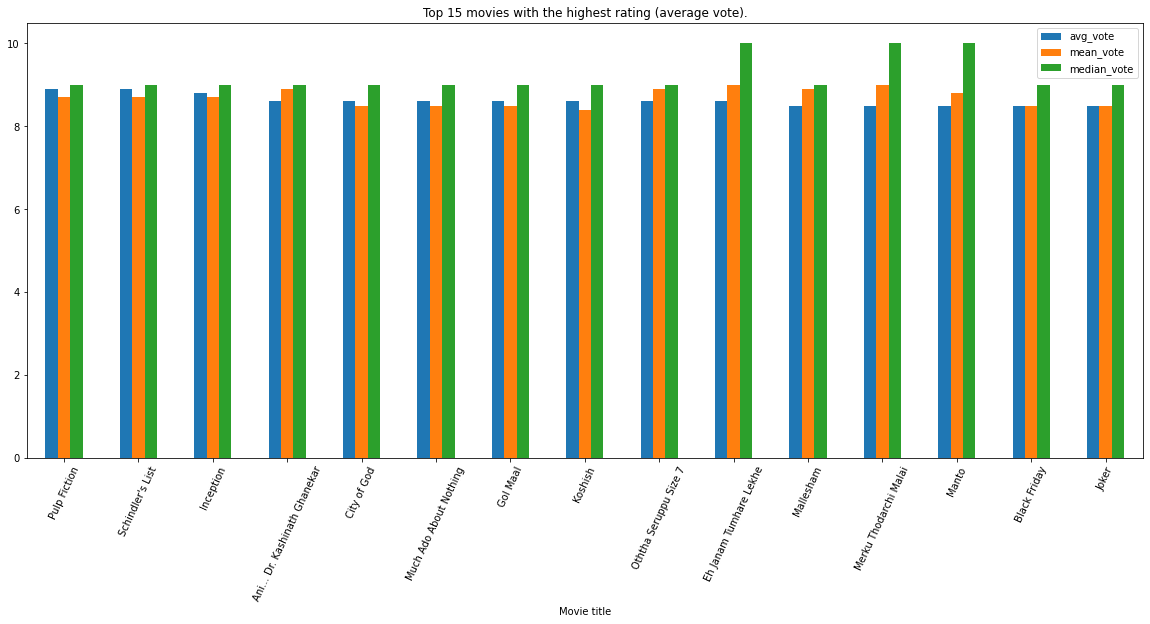

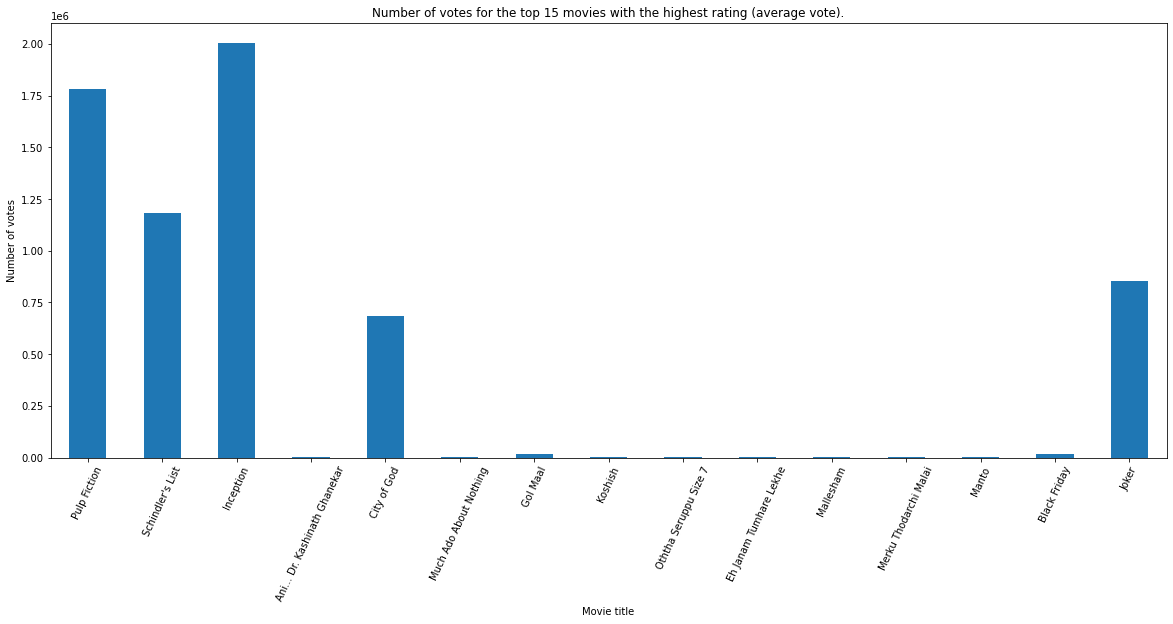

In [ ]:
# Collect all movies from netflix
netfx = nx_df[['title']].where(nx_df['type'] == 'Movie').dropna()
# Collect id, mean and median vote from IMDb ratings
imdb_ratings = imdb_r_df[['imdb_title_id', 'mean_vote', 'median_vote']].dropna()
# Collect id, title, average vote and total votes from IMDb movies
imdb_mov = imdb_m_df[['imdb_title_id', 'title', 'avg_vote', 'votes']].dropna()

# Join the 2 IMDb dataframes together, on movie id
imdb = imdb_ratings.join(imdb_mov.set_index('imdb_title_id'), on='imdb_title_id')

# Join (inner) the previous dataframe with the netflix movies on title
info = imdb.join(netfx.set_index('title'), on='title', how='inner')
info.reset_index(drop=True, inplace=True)

# Sort the final dataframe based on the average vote
info = info.drop(columns='imdb_title_id').sort_values(by='avg_vote', ascending=False)

# Plot the results
top_n = 15
info.head(top_n).plot(x='title', y=['avg_vote', 'mean_vote', 'median_vote'], kind='bar', xlabel='Movie title', 
        figsize=[20, 8], title=f'Top {top_n} movies with the highest rating (average vote).')

plt.xticks(rotation=65)

info.head(top_n).plot(x='title', y='votes', kind='bar', xlabel='Movie title', ylabel='Number of votes', label=False,
        figsize=[20, 8], title=f'Number of votes for the top {top_n} movies with the highest rating (average vote).', legend=False)

plt.xticks(rotation=65)

## 2. Recommendation system

### Αρχικοποίηση κατάλληλων συναρτήσεων και containers
Αρχίζοντας, κάθε τίτλος και περιγραφή, από τη στιγμή που θα χρησιμοποιηθούν στην εξαγωγή προτεινόμενων ταινιών, θα πρέπει να διοχετευτούν σε μία lemmatisation διαδικασία, με σκοπό να παραμείνουν μόνο οι κοινές ρίζες των λέξεων που τις απαρτίζουν. Έτσι, για το lemmatisation process επιλέχθηκε η βιβλιοθήκη *spaCy*, ενώ για το stopwords container επιλέχθηκε η βιβλιοθήκη *NLTK*. 

In [ ]:
import pandas as pd
# Import the appropriate vectorizers (CountVect., and TF-IDF Vect.)
from sklearn.feature_extraction.text import CountVectorizer as cvect
from sklearn.feature_extraction.text import TfidfVectorizer as tfvect

# Use an advanced stopword container via NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Import spacy for the lemmatisation process
import spacy
nlp = spacy.load('en_core_web_sm')

# Function to return a list of lemmas (without punctuation and pronouns)
lemmatok = lambda doc: [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-' and not token.is_punct]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# First of all, lemmatise all of the titles and descriptions
nx_df_lem = nx_df.copy()
nx_df_lem['description'] = nx_df_lem['description'].apply(lambda x: " ".join(lemmatok(x)))
nx_df_lem['title'] = nx_df_lem['title'].apply(lambda x: " ".join(lemmatok(x)))

# Extract descriptions and titles and merge them into individual strings
desc_l = nx_df_lem['description'].to_list()
title_l = nx_df_lem['title'].to_list()
desc_titles = [( desc_l[i] + ' ' + title_l[i] ) for i in range(len(desc_l))]

### 1.α - Boolean Bag of Words (BoW)

In [ ]:
# BoW

# Declare vectorizers (unigram, bigram)
cv_uni = cvect(ngram_range=(1, 1), stop_words=stopwords.words(), min_df=5, max_df=0.96, max_features=3000, binary=True)
cv_bi = cvect(ngram_range=(2, 2), stop_words=stopwords.words(), min_df=2, binary=True)
cv_unibi = cvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000, binary=True)

# Transform 
cv_tr_u = cv_uni.fit_transform(desc_titles)
cv_tr_b = cv_bi.fit_transform(desc_titles)
cv_tr_ub = cv_unibi.fit_transform(desc_titles)

# Create the respective dataframes

# DataFrame consisting of unigrams
cv_u_df = pd.DataFrame(cv_tr_u.toarray(), columns = cv_uni.get_feature_names(), index= nx_df_lem['show_id'])
# DataFrame consisting of bigrams
cv_b_df = pd.DataFrame(cv_tr_b.toarray(), columns = cv_bi.get_feature_names(), index= nx_df_lem['show_id'])
# DataFrame consisting of both unigrams and bigrams
cv_df = pd.DataFrame(cv_tr_ub.toarray(), columns = cv_unibi.get_feature_names(), index= nx_df_lem['show_id'])

### 1.β - Term Frequency - Inverse Document Frequency (TF-IDF)

In [ ]:
# TF-IDF

# Declare vectorizers (unigram, bigram)
tf_uni = tfvect(ngram_range=(1, 1), stop_words=stopwords.words(), min_df=2, max_df=0.96, max_features=3000)
tf_bi = tfvect(ngram_range=(2, 2), stop_words=stopwords.words(), min_df=2)
tf_unibi = tfvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000)

# Transform 
tf_tr_u = tf_uni.fit_transform(desc_titles)
tf_tr_b = tf_bi.fit_transform(desc_titles)
tf_tr_ub = tf_unibi.fit_transform(desc_titles)

# Create the respective dataframes

# DataFrame consisting of unigrams
tf_u_df = pd.DataFrame(tf_tr_u.toarray(), columns = tf_uni.get_feature_names(), index= nx_df_lem['show_id'])
# DataFrame consisting of bigrams
tf_b_df = pd.DataFrame(tf_tr_b.toarray(), columns = tf_bi.get_feature_names(), index= nx_df_lem['show_id'])
# DataFrame consisting of both unigrams and bigrams
tf_df = pd.DataFrame(tf_tr_ub.toarray(), columns = tf_unibi.get_feature_names(), index= nx_df_lem['show_id'])

**Σχόλια:** Όσον αφορά στη ρύθμιση των παραμέτρων `min_df`, `max_df` και `max_features` κατά τη δήλωση των vectorizers, οι τιμές αποδόθηκαν μέσω πολλαπλών πειραμάτων με σκοπό την ταυτόχρονη ικανοποίηση όλων των παρακάτω:
1. Ικανοποιητική απόδοση των εκπαιδευμένων μοντέλων στα ζητούμενα ερωτήματα.
2. Χρόνος εκπαίδευσης των μοντέλων εντός λογικών πλαισίων.
3. Εκπαίδευση των μοντέλων χωρίς την κατανάλωση όλης της προσφερόμενης RAM του Google Colab.

### 2. Συμπερίληψη συναρτήσεων

Προκειμένου να υπολογισθούν οι αναπαραστάσεις βάσει μεθόδων **Jaccard-Tanimoto** και **cosine similarity**, έχει συμπεριληφθεί η συνάρτηση `cdist()` από τη βιβλιοθήκη `sciPy`, η οποία υπολογίζει την απόσταση μεταξύ των δύο εισόδων της βάσει μίας μετρικής. Στην προκειμένη άσκηση, οι μετρικές που θα χρησιμοποιηθούν είναι η 'jaccard' και η 'cosine'.

In [ ]:
from scipy.spatial.distance import cdist

#### Συνάρτηση υπολογισμού ομοιότητας
Η παρακάτω συνάρτηση `similar()`, ενθυλακώνει την `cdist()`, εξυπηρετώντας πλήρως τις απαιτήσεις του παρόντος project.

In [ ]:
'''
Receives two dataframes, df1, df2 and a metric

Computes the distance between each pair of the two collections of inputs.

Returns a 2D list
'''
def similar(df1, df2, metric):
    return 1-cdist(df1, df2, metric)

### 2.α 
#### Αξιοποίηση της μεθόδου `similar()` με τη μετρική *jaccard* για τον υπολογισμό της ομοιότητας ταινιών με τη μέθοδο *Jaccard-Tanimoto* δοθέντων των feature vectors τους.


In [ ]:
# BoW - unigram
cv_uni_sim = similar(cv_u_df, cv_u_df, 'jaccard')
# BoW - bigram
cv_bi_sim = similar(cv_b_df, cv_b_df, 'jaccard')
# BoW unigram & bigram
cv_sim = similar(cv_df, cv_df, 'jaccard')

### 2.β
#### Αξιοποίηση της `similar()` με τη μετρική *cosine* για τον υπολογισμό της ομοιότητας ταινιών με τη μέθοδο *Cosine Similarity* δοθέντων των feature vectors τους.

In [ ]:
# TF-IDF - unigram
tf_uni_sim = similar(tf_u_df, tf_u_df, 'cosine')
# TF-IDF - bigram
tf_bi_sim = similar(tf_b_df, tf_b_df, 'cosine')
# TF-IDF unigram & bigram
tf_sim = similar(tf_df, tf_df, 'cosine')

#### Διαδικασία δημιουργίας λεξικών
Παρακάτω, υπάρχει η συνάρτηση που μετατρέπει την έξοδο (2D array) της διαδικασίας `similar()` σε ένα λεξικό, το οποίο παρουσιάζει **για κάθε** ταινία του dataset τις **100 πιο όμοιες** ταινίες της. Τα κλειδιά που την αποτελούν είναι *show ids* (π.χ *s123*), ενώ οι αντίστοιχες τιμές είναι λίστες από tuples. Κάθε tuple αποτελείται από δύο πεδία:
1. Το πρώτο πεδίο είναι ένας δεκαδικός αριθμός (εκτίμηση ομοιότητας από τη μέθοδο *Jaccard-Tanimoto* ή *Cosine Similarity*).
2. Το δεύτερο πεδίο είναι ένα *show id*.

In [ ]:
def dict_prep(l):
    d = {}
    # Form the keys
    for i in range(len(l)):
        idx = 's' + str(i+1) 
        d[idx] = l[i]

    # Form the respective tuples, sort them and keep top 100
    for j, key in enumerate(d):
        l = list(d[key])
        d[key] = [(l[i], 's' + str(i+1)) for i in range(len(l))]
        d[key] = [k for k in d[key] if k[1] != key]
        d[key].sort(reverse=True)
        d[key] = d[key][:100]

    return d

#### Τελειοποίηση των αποτελεσμάτων
Αφότου κληθεί η συνάρτηση `similar()` **για κάθε** ένα από τα παραγόμενα DataFrames, δομούνται τα αντίστοιχα λεξικά, με σκοπό την ταχύτατη απόσπαση της ζητούμενης πληροφορίας.

In [ ]:
# Form all the necessary dictionaries
cv_uni_sim = dict_prep(cv_uni_sim) 
cv_bi_sim = dict_prep(cv_bi_sim) 
cv_sim = dict_prep(cv_sim) 

tf_uni_sim = dict_prep(tf_uni_sim) 
tf_bi_sim = dict_prep(tf_bi_sim) 
tf_sim = dict_prep(tf_sim) 

In [ ]:
# Function for stat printing
def pretty_print(l, title, N):
    print(f'Top {N} recommended productions for "{title}":')
    print('-----------------------------------------------')
    print('INDEX -- TITLE -- SIMILARITY')
    for i, (est, t) in enumerate(l):
        print(f'{i+1}. -- {t} -- {str(est)[:4]}')

### 3. Πρόβλεψη βάσει τίτλου.
Η συνάρτηση `get_similar_movies1()` δέχεται τον τίτλο μίας ταινίας, έναν αριθμό `N`, μία μέθοδο και ένα ngram tuple. Βάσει όλων των πιθανών εισόδων, ανταποκρίνεται πλήρως, επιστρέφοντας τις προτεινόμενες `N` ταινίες βάσει ομοιότητας, ανάλογα με τον εισαγόμενο τίτλο. Η απόσπαση πληροφοριών βασίζεται εξ'ολοκλήρου στα 6 εκπαιδευμένα dictionaries.

In [ ]:
'''
Receives a movie title, a number, a method and a ngram tuple
Returns the top "N" most similar movies to the given movie title

If "method" is "boolean", the information is being extracted from the BoW method's trained dataset
If "method" is "tf-idf", the information is being extracted from the TF-IDF method's trained dataset

If "ngram" is (1, 1), the information is only being extracted from the set trained on unigrams
If "ngram" is (1, 2), the information is being extracted from the set trained on unigrams and bigrams
If "ngram" is (2, 2), the information is only being extracted from the set trained on bigrams
'''
def get_similar_movies1(movie_title, N=10, method='boolean', ngram=(1, 2)):
    # Try and fetch the given title's show id
    try:
        id = nx_df[nx_df['title'] == movie_title]['show_id'].values[0]
    except:
        print(f'Error, "{movie_title}" does not exist in the database.')
        return None

    sims = None
    # Boolean method
    if method == 'boolean':
        # Extract the appropriate list of similar movie ids from a trained set
        sdata = cv_uni_sim[id] if ngram==(1, 1) else cv_sim[id] if ngram==(1, 2)  \
                else cv_bi_sim[id] if ngram==(2, 2) else None

        if sdata == None:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return sdata
        # Keep only the top "N" movies
        sims = sdata[:N]

    # TF-IDF method
    elif method == 'tf-idf':
        # Extract the appropriate list of similar movie ids from a trained set
        sdata = tf_uni_sim[id] if ngram==(1, 1) else tf_sim[id] if ngram==(1, 2)  \
                else tf_bi_sim[id] if ngram==(2, 2) else None
        
        if sdata == None:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return sdata
        sims = sdata[:N]
        
    else:
        print('Error, method parameter has to be either "boolean" or "tf-idf".')
        return None
    # Return the resulting movie titles and similarity rates instead of movie ids
    return [(val, nx_df[nx_df['show_id'] == id2]['title'].values[0]) for (val, id2) in sims]

#### Παρουσίαση των αποτελεσμάτων
Η συνάρτηση `get_similar_movies1()` εκτελείται για κάθε πιθανή έγκυρη είσοδο, με αριθμό επιθυμητών προτεινόμενων ταινιών ίσο με 10 και τίτλους ταινιών `Surviving Escobar - Alias JJ` και `Last Breath`.

In [ ]:
N = 10
mtitle = 'Surviving Escobar - Alias JJ'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 1)), mtitle, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 2)), mtitle, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(2, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 1)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(2, 2)), mtitle, N)

mtitle = 'Last Breath'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 1)), mtitle, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 2)), mtitle, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(2, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 1)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(2, 2)), mtitle, N)



[Boolean - Unigrams]> Top 10 Recommended productions for "Surviving Escobar - Alias JJ" : 

Top 10 recommended productions for "Surviving Escobar - Alias JJ":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY
1. -- Alias JJ, la celebridad del mal -- 0.15
2. -- The Darkest Dawn -- 0.14
3. -- 7:19 -- 0.13
4. -- El señor de los Cielos -- 0.12
5. -- Omar & Salma 2 -- 0.11
6. -- The Paper -- 0.10
7. -- All About Love -- 0.10
8. -- Ali & Alia -- 0.10
9. -- Familiye -- 0.10
10. -- Cleverman -- 0.10


[Boolean - Unigrams & Bigrams]> Top 10 Recommended productions for "Surviving Escobar - Alias JJ" : 

Top 10 recommended productions for "Surviving Escobar - Alias JJ":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY
1. -- The Darkest Dawn -- 0.19
2. -- Alias JJ, la celebridad del mal -- 0.17
3. -- El señor de los Cielos -- 0.13
4. -- 7:19 -- 0.13
5. -- All About Love -- 0.12
6. -- Los tiempos de Pablo Escobar -- 0.12
7. -- La Viuda Negra 

### Παρατηρήσεις και Συμπεράσματα

#### **BoW**
Παρόλο που το μοντέλο του boolean BoW πίνακα των unigrams είναι πολύ κατανοητό και εύκολα υλοποιήσιμο, είναι πολύ αραιό και δε λαμβάνει υπόψην καθόλου τη σειρά με την οποία εμφανίζονται οι λέξεις στο κείμενο. Επιπρόσθετα, ο BoW πίνακας των bigrams συγκεντρώνει μεν περισσότερο περιεχόμενο, αφού μπορεί να λάβει υπόψην και τη σειρά των λέξεων ανά δυάδες, ωστόσο αυτό δεν περιορίζει και αυτόν τον πίνακα από το να είναι επόσης πολύ αραιός και να μη συγκεντρώνει ικανοποιητικό ποσό πληροφορίας για την εξαγωγή αξιόπιστων αποτελεσμάτων.

#### **TF-IDF**
Τα μοντέλα του TF-IDF πίνακα των unigrams και bigrams είναι παρόμοια με εκείνα του μοντέλου ΒoW, με τη σημαντική θετική διαφορά ότι μετράται η ποσότητα που εκφράζει το κατά πόσο μία λέξη ή μία δυάδα λέξεων (unigrams ή bigrams αντίστοιχα) είναι σπάνια ανάμεσα σε όλα τα αρχεία. Ωστόσο, η πληροφορία (ειδικά στα bigrams) είναι αραιά κατανεμημένη και σε πολλά σημεία μη-επαρκής για την εξαγωγή συμπερασμάτων.

### 4. Πρόβλεψη βάσει περιγραφής / λέξεων κλειδιών.
Η συνάρτηση `get_similar_movies2()` δέχεται μία περιγραφή, έναν αριθμό `N`, μία μέθοδο και ένα ngram tuple. Βάσει όλων των πιθανών εισόδων, ανταποκρίνεται πλήρως, επιστρέφοντας τις προτεινόμενες `N` ταινίες βάσει ομοιότητας, ανάλογα με την εισαγόμενη περιγραφή.

In [ ]:
'''
Receives a description, a number, a method and a ngram tuple
Returns the top "N" most similar movies to the given keywords/description

If "method" is "boolean", the information is being trained with BoW method
If "method" is "tf-idf", the information is being trained with TF-IDF method

If "ngram" is (1, 1), the information is only being extracted from the set trained on unigrams
If "ngram" is (1, 2), the information is being extracted from the set trained on unigrams and bigrams
If "ngram" is (2, 2), the information is only being extracted from the set trained on bigrams
'''
def get_similar_movies2(descr, N=10, method='tf-idf', ngram=(1, 2)):
    
    dsc = descr
    # Lemmatise the given description
    descr = " ".join(lemmatok(descr))
    # Add the given description to the dataset
    descriptions = nx_df_lem['description'].to_list() + [descr]
    # Add an index for the user's input description
    new_indices = nx_df_lem['show_id'].append(pd.Series(['User arg']))

    # Transform all the existing descriptions along with the user's input and create 
    # the appropriate DataFrames (based on the provided method & ngram)
    sims = None
    # Boolean method
    if method == 'boolean':
        df = None
        if ngram==(1, 2):
            tr_ub = cv_unibi.fit_transform(descriptions)
            df = pd.DataFrame(tr_ub.toarray(), columns = cv_unibi.get_feature_names(), index=new_indices)
        
        elif ngram==(1, 1):
            tr_u = cv_uni.fit_transform(descriptions)
            df = pd.DataFrame(tr_u.toarray(), columns = cv_uni.get_feature_names(), index=new_indices)

        elif ngram==(2, 2):
            tr_b = cv_bi.fit_transform(descriptions)
            df = pd.DataFrame(tr_b.toarray(), columns = cv_bi.get_feature_names(), index=new_indices)
        
        else:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return None

        # Keep a dataframe consisting only of the user's input feature vector 
        df1 = df.tail(1)
        df.drop(df.tail(1).index, inplace=True)
        # Compute and keep only the top "N" most similar movies to the user's description via similar()
        sdata = dict_prep(similar(df1, df, 'jaccard'))
        sims = list(sdata.values())[0][:N]

    elif method == 'tf-idf':
        df = None
        if ngram==(1, 2):
            tr_ub = tf_unibi.fit_transform(descriptions)
            df = pd.DataFrame(tr_ub.toarray(), columns = tf_unibi.get_feature_names(), index=new_indices)

        elif ngram==(1, 1):
            tr_u = tf_uni.fit_transform(descriptions)
            df = pd.DataFrame(tr_u.toarray(), columns = tf_uni.get_feature_names(), index=new_indices)

        elif ngram==(2, 2):
            tr_b = tf_bi.fit_transform(descriptions)    
            df = pd.DataFrame(tr_b.toarray(), columns = tf_bi.get_feature_names(), index=new_indices)

        else:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return None
        
        df1 = df.tail(1)
        df.drop(df.tail(1).index, inplace=True)
        # Compute and keep only the top "N" most similar movies to the user's description via similar()
        sdata = dict_prep(similar(df1, df, 'cosine'))
        sims = list(sdata.values())[0][:N]
        
    else:
        print('Error, method parameter has to be either "boolean" or "tf-idf".')
        return None

    # Return the resulting movie titles and similarity rates instead of movie ids
    return [(val, nx_df[nx_df['show_id'] == id2]['title'].values[0]) for (val, id2) in sims]

#### Παρουσίαση των αποτελεσμάτων
Η συνάρτηση `get_similar_movies2()` εκτελείται για κάθε πιθανή έγκυρη είσοδο, με αριθμό επιθυμητών προτεινόμενων ταινιών ίσο με 10 και περιγραφές `Love story of teenagers at high school` και `Psycological thriller with psychic patients`.

In [ ]:
N = 10
dsc = 'Love story of teenagers at high school'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 1)), dsc, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 2)), dsc, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(2, 2)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 1)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 2)), dsc, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(2, 2)), dsc, N)


dsc = 'Psycological thriller with psychic patients'
print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 1)), dsc, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 2)), dsc, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(2, 2)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 1)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 2)), dsc, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(2, 2)), dsc, N)



[Boolean - Unigrams]> Top 10 Recommended productions based on the description "Love story of teenagers at high school" : 

Top 10 recommended productions for "Love story of teenagers at high school":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY
1. -- Milea -- 0.26
2. -- Angel Beats! -- 0.25
3. -- Christmas Crush -- 0.23
4. -- The Knight Before Christmas -- 0.21
5. -- Lovesick -- 0.21
6. -- Kocan Kadar Konus -- 0.21
7. -- Derry Girls -- 0.21
8. -- Back to the 90s -- 0.19
9. -- The Kissing Booth -- 0.19
10. -- Tall Girl -- 0.19


[Boolean - Unigrams & Bigrams]> Top 10 Recommended productions based on the description "Love story of teenagers at high school" : 

Top 10 recommended productions for "Love story of teenagers at high school":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY
1. -- Milea -- 0.35
2. -- Angel Beats! -- 0.26
3. -- Lovesick -- 0.25
4. -- Back to the 90s -- 0.23
5. -- Christmas Crush -- 0.23
6. -- The Knigh

### Πιθανοί λόγοι αστοχίας

Υπάρχουν διάφοροι λόγοι για τους οποίους μπορούν τα μοντέλα να αποτύχουν στο να παράξουν μία λογική εκτίμηση βάσει μίας παρεχόμενης περιγραφής. Για παράδειγμα, η λέξη *break* μπορεί να δηλώνει το χωρισμό ενός ζεύγους (break up), το κάταγμα σε ένα κόκκαλο ή ακόμα και ένα ολιγόλεπτο διάλειμμα. Οι αλγόριθμοι που έχουν υλοποιηθεί παραπάνω δεν δύνανται να διαχωρίσουν τα νοήματα σε τέτοιο βαθμό σαφήνειας, με αποτέλεσμα να παράγουν αρκετά ανακριβή αποτελέσματα. Άλλο ένα παράδειγμα που οδηγεί σε παραπλανητικά αποτελέσματα, είναι η ύπαρξη πολλαπλών λέξεων συνώνυμων μεταξύ τους και όχι η ομαδοποίησή τους σε μία λέξη νοηματικά ισοδύναμη. Για παράδειγμα, οι λέξεις *Group, Clique, Gang, Club* μπορεί να υπάρχουν διάσπαρτες σε ένα κείμενο και πράγματι να αποδίδουν το ίδιο νόημα, χωρίς όμως να ομαδοποιηθούν εν τέλει *έξυπνα* όπου είναι απαραίτητο, αλλοιώνοντας το νόημα ορισμένων περιγραφών. Τέλος, ένας πολύ συνηθισμένος λόγος αστοχίας, είναι η ύπαρξη μη-επαρκούς ποσού πληροφορίας στο σετ δεδομένων, με αποτέλεσμα κάποιες προτεινόμενες ταινίες να ανήκουν σε πλήρως διαφορετικό είδος σχετικά με την αρχική ταινία.


T E Λ Ο Σ    

P R O J E C T 1